# SARIMAX
This notebook builds on top of <i>SARIMAX + Exog Var</i> notebook. Previously, intercept was defined as part of the SARIMAX model. 
>- However, in this notebook intercept is defined differently, by adding a column of 1s since temperature knots do require an intercept.
>- Here also, no seasonal or non-seasonal differencing is done.

> It is important to note that in TS regression even though regressional residuals were found stationary, significant autocorrelation does exist.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [2]:
# Loading the data
load_long = pd.read_csv(r"C:\Users\singh\Desktop\TUD (All Semesters)\Courses - Semester 6 (TU Dresden)\Thesis Work\Exploratory Code\load_history_long.csv").sort_values(by = "timestamp")

# Filtering for Zone 1, applying log transformation on load (after rescaling)
load_long_z1 = load_long
load_long_z1["load_rs"] = load_long_z1.load / 1000
load_long_z1["log_load_rs"] = np.log(load_long_z1.load_rs)
load_long_z1 = load_long_z1.loc[load_long_z1.zone_id == 1,:].sort_values(by = "timestamp").reset_index(drop=True)
load_long_z1.head()

C:\Users\singh\anaconda3\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


zone_id  year  month  day   hour     load            timestamp  load_rs  \
0        1  2004      1    1  00:30  16853.0  2004-01-01 00:30:00   16.853   
1        1  2004      1    1  01:30  16450.0  2004-01-01 01:30:00   16.450   
2        1  2004      1    1  02:30  16517.0  2004-01-01 02:30:00   16.517   
3        1  2004      1    1  03:30  16873.0  2004-01-01 03:30:00   16.873   
4        1  2004      1    1  04:30  17064.0  2004-01-01 04:30:00   17.064   

   log_load_rs  
0     2.824529  
1     2.800325  
2     2.804390  
3     2.825715  
4     2.836971

Variance stabilisation is already done by rescaling the data and applying <b>log transformation</b> to the load values.<br>
The transformed values are represented by <i>log_load_rs</i> column.

In [3]:
# Loading the temperature data
temperature = pd.read_csv(r"C:\Users\singh\Desktop\TUD (All Semesters)\Courses - Semester 6 (TU Dresden)\Thesis Work\Exploratory Code\weighted_temperature.csv")
temperature.head()

timestamp     1     2     3     4     5     6     7     8     9  \
0  2004-01-01 00:30:00  46.0  38.0  44.0  45.0  42.0  44.0  45.0  43.0  41.0   
1  2004-01-01 01:30:00  46.0  36.0  42.0  43.0  42.0  43.0  44.0  44.0  39.0   
2  2004-01-01 02:30:00  45.0  35.0  40.0  41.0  40.0  42.0  41.0  42.0  36.0   
3  2004-01-01 03:30:00  41.0  30.0  36.0  37.0  39.0  38.0  40.0  34.0  35.0   
4  2004-01-01 04:30:00  39.0  30.0  34.0  33.0  40.0  38.0  35.0  30.0  33.0   

     10    11  temp_weighted  
0  42.0  36.0      42.338937  
1  43.0  32.0      41.239284  
2  43.0  31.0      39.591442  
3  39.0  30.0      36.243296  
4  35.0  34.0      34.600850

In [4]:
# Importing holiday dataframe
holiday_df = pd.read_csv(r"C:\Users\singh\Desktop\TUD (All Semesters)\Courses - Semester 6 (TU Dresden)\Thesis Work\Dataset\GEFCom2012\GEFCOM2012_Data\Load\Holiday_List.csv")

# Holidays in 2004
holiday_df["2004"]

0      Thursday, January 1
1       Monday, January 19
2      Monday, February 16
3           Monday, May 31
4           Monday, July 5
5      Monday, September 6
6       Monday, October 11
7    Thursday, November 11
8    Thursday, November 25
9      Friday, December 24
Name: 2004, dtype: object

## Processing the Data

In [5]:
# Filtering load for 2004
load_long_z1_2004 = load_long_z1.loc[load_long_z1.year == 2004, ['timestamp','year','month','day','hour','log_load_rs']]

# Filtering temperature for 2004
temperature_2004 = temperature.loc[temperature.timestamp <= '2004-12-31 23:30:00', ['timestamp', 'temp_weighted']]

# Combining load and temperature information
mul_df = load_long_z1_2004.merge(temperature_2004, on='timestamp', how='left')
mul_df.head()

timestamp  year  month  day   hour  log_load_rs  temp_weighted
0  2004-01-01 00:30:00  2004      1    1  00:30     2.824529      42.338937
1  2004-01-01 01:30:00  2004      1    1  01:30     2.800325      41.239284
2  2004-01-01 02:30:00  2004      1    1  02:30     2.804390      39.591442
3  2004-01-01 03:30:00  2004      1    1  03:30     2.825715      36.243296
4  2004-01-01 04:30:00  2004      1    1  04:30     2.836971      34.600850

In [6]:
# Adding holiday column
mul_df["holiday"] = 0

# Adding holiday information - for 2004
mul_df.loc[mul_df.timestamp <= "2004-01-01 23:30:00","holiday"] = 1
mul_df.loc[(mul_df.timestamp <= "2004-01-19 23:30:00") & (mul_df.timestamp >= "2004-01-19 00:30:00"),"holiday"] = 1
mul_df.loc[(mul_df.timestamp <= "2004-02-16 23:30:00") & (mul_df.timestamp >= "2004-02-16 00:30:00"),"holiday"] = 1
mul_df.loc[(mul_df.timestamp <= "2004-05-31 23:30:00") & (mul_df.timestamp >= "2004-05-31 00:30:00"),"holiday"] = 1
mul_df.loc[(mul_df.timestamp <= "2004-07-05 23:30:00") & (mul_df.timestamp >= "2004-07-05 00:30:00"),"holiday"] = 1
mul_df.loc[(mul_df.timestamp <= "2004-09-06 23:30:00") & (mul_df.timestamp >= "2004-09-06 00:30:00"),"holiday"] = 1
mul_df.loc[(mul_df.timestamp <= "2004-10-11 23:30:00") & (mul_df.timestamp >= "2004-10-11 00:30:00"),"holiday"] = 1
mul_df.loc[(mul_df.timestamp <= "2004-11-11 23:30:00") & (mul_df.timestamp >= "2004-11-11 00:30:00"),"holiday"] = 1
mul_df.loc[(mul_df.timestamp <= "2004-11-25 23:30:00") & (mul_df.timestamp >= "2004-11-25 00:30:00"),"holiday"] = 1
mul_df.loc[(mul_df.timestamp <= "2004-12-24 23:30:00") & (mul_df.timestamp >= "2004-12-24 00:30:00"),"holiday"] = 1
mul_df.head()

timestamp  year  month  day   hour  log_load_rs  temp_weighted  \
0  2004-01-01 00:30:00  2004      1    1  00:30     2.824529      42.338937   
1  2004-01-01 01:30:00  2004      1    1  01:30     2.800325      41.239284   
2  2004-01-01 02:30:00  2004      1    1  02:30     2.804390      39.591442   
3  2004-01-01 03:30:00  2004      1    1  03:30     2.825715      36.243296   
4  2004-01-01 04:30:00  2004      1    1  04:30     2.836971      34.600850   

   holiday  
0        1  
1        1  
2        1  
3        1  
4        1

Fourier terms are made differently for each portion of 2004. Hence they will be defined while testing for that particular period.

In [7]:
# Adding temperature knots for PLR

T_H = 55  # Heating Threshold
T_C = 65  # Cooling Threshold

# Construct the Heating Demand Knot: HDK = max(0, T_H - Temp)
## This captures load increase when temp is below T_H.
mul_df["HDK"] = np.where(
    mul_df["temp_weighted"] < T_H,  
    T_H - mul_df["temp_weighted"],  # Value if True: The positive difference
    0                               # Value if False: Zero
)

# Construct the Cooling Demand Knot; CDK = max(0, Temp - T_C)
## This captures load increase when temp is above T_C.
mul_df["CDK"] = np.where(
    mul_df["temp_weighted"] > T_C,  
    mul_df["temp_weighted"] - T_C,  # Value if True: The positive difference
    0                               # Value if False: Zero
)

mul_df.head()

timestamp  year  month  day   hour  log_load_rs  temp_weighted  \
0  2004-01-01 00:30:00  2004      1    1  00:30     2.824529      42.338937   
1  2004-01-01 01:30:00  2004      1    1  01:30     2.800325      41.239284   
2  2004-01-01 02:30:00  2004      1    1  02:30     2.804390      39.591442   
3  2004-01-01 03:30:00  2004      1    1  03:30     2.825715      36.243296   
4  2004-01-01 04:30:00  2004      1    1  04:30     2.836971      34.600850   

   holiday        HDK  CDK  
0        1  12.661063  0.0  
1        1  13.760716  0.0  
2        1  15.408558  0.0  
3        1  18.756704  0.0  
4        1  20.399150  0.0

In [8]:
# Adding a column of 1s to define the intercept for SARIMAX
mul_df["const"] = 1
mul_df.head()

timestamp  year  month  day   hour  log_load_rs  temp_weighted  \
0  2004-01-01 00:30:00  2004      1    1  00:30     2.824529      42.338937   
1  2004-01-01 01:30:00  2004      1    1  01:30     2.800325      41.239284   
2  2004-01-01 02:30:00  2004      1    1  02:30     2.804390      39.591442   
3  2004-01-01 03:30:00  2004      1    1  03:30     2.825715      36.243296   
4  2004-01-01 04:30:00  2004      1    1  04:30     2.836971      34.600850   

   holiday        HDK  CDK  const  
0        1  12.661063  0.0      1  
1        1  13.760716  0.0      1  
2        1  15.408558  0.0      1  
3        1  18.756704  0.0      1  
4        1  20.399150  0.0      1

## Combining Fourier Terms with SARIMAX
The model combines regressors in addition to fourier terms, as used in time series regression. Together they make all exogenous regressors. This is then combined with SARIMAX, where seasonal AR\MA components are also defined.

##### Testing on Last Week of Jan 2004 (Zone 1)
Last week of Jan 2004 is used for testing. Multiple SARIMAX models are evaluated and compared. 

In [9]:
# Creating training data
load_long_z1_2004_jan_train = mul_df.loc[mul_df.month == 1,:]
load_long_z1_2004_jan_train = load_long_z1_2004_jan_train.set_index("timestamp")
load_long_z1_2004_jan_train = load_long_z1_2004_jan_train[:'2004-01-24 23:30:00']
load_long_z1_2004_jan_train.index = pd.to_datetime(load_long_z1_2004_jan_train.index)
load_long_z1_2004_jan_train.head()

year  month  day   hour  log_load_rs  temp_weighted  \
timestamp                                                                  
2004-01-01 00:30:00  2004      1    1  00:30     2.824529      42.338937   
2004-01-01 01:30:00  2004      1    1  01:30     2.800325      41.239284   
2004-01-01 02:30:00  2004      1    1  02:30     2.804390      39.591442   
2004-01-01 03:30:00  2004      1    1  03:30     2.825715      36.243296   
2004-01-01 04:30:00  2004      1    1  04:30     2.836971      34.600850   

                     holiday        HDK  CDK  const  
timestamp                                            
2004-01-01 00:30:00        1  12.661063  0.0      1  
2004-01-01 01:30:00        1  13.760716  0.0      1  
2004-01-01 02:30:00        1  15.408558  0.0      1  
2004-01-01 03:30:00        1  18.756704  0.0      1  
2004-01-01 04:30:00        1  20.399150  0.0      1

From time series regression notebook, 2 harmonics with daily periodicity were found to be appropriate.

In [10]:
# Adding periodicities
from statsmodels.tsa.deterministic import Fourier
from statsmodels.tsa.deterministic import DeterministicProcess
periodicity = Fourier(period=24, order=2) # daily cycle i.e. 24 hours, 2 harmonics

# Defining the sine wave
dp = DeterministicProcess(
    index=load_long_z1_2004_jan_train.index,
    period=None,         # It's not defined so that frequency can be read from the index
    constant=False,      # defined later
    order=1,             # linear trend not required since seasonal diff made the series stationary
    seasonal=False,      # no seasonal dummies
    additional_terms=[periodicity], # 2 seperate waves will be generated
    drop=True            # if perfect collinearity exists, the terms can be dropped
)

waves = dp.in_sample()
waves.head()

trend  sin(1,24)  cos(1,24)  sin(2,24)     cos(2,24)
timestamp                                                                
2004-01-01 00:30:00    1.0   0.000000   1.000000   0.000000  1.000000e+00
2004-01-01 01:30:00    2.0   0.258819   0.965926   0.500000  8.660254e-01
2004-01-01 02:30:00    3.0   0.500000   0.866025   0.866025  5.000000e-01
2004-01-01 03:30:00    4.0   0.707107   0.707107   1.000000  6.123234e-17
2004-01-01 04:30:00    5.0   0.866025   0.500000   0.866025 -5.000000e-01

In [11]:
# Combining fourier terms with other variables
load_long_z1_2004_jan_train = load_long_z1_2004_jan_train.merge(waves, on='timestamp', how='left')
load_long_z1_2004_jan_train.head()

year  month  day   hour  log_load_rs  temp_weighted  \
timestamp                                                                  
2004-01-01 00:30:00  2004      1    1  00:30     2.824529      42.338937   
2004-01-01 01:30:00  2004      1    1  01:30     2.800325      41.239284   
2004-01-01 02:30:00  2004      1    1  02:30     2.804390      39.591442   
2004-01-01 03:30:00  2004      1    1  03:30     2.825715      36.243296   
2004-01-01 04:30:00  2004      1    1  04:30     2.836971      34.600850   

                     holiday        HDK  CDK  const  trend  sin(1,24)  \
timestamp                                                               
2004-01-01 00:30:00        1  12.661063  0.0      1    1.0   0.000000   
2004-01-01 01:30:00        1  13.760716  0.0      1    2.0   0.258819   
2004-01-01 02:30:00        1  15.408558  0.0      1    3.0   0.500000   
2004-01-01 03:30:00        1  18.756704  0.0      1    4.0   0.707107   
2004-01-01 04:30:00        1  20.399150  0.0      1    5.0   0.866025   

                     cos(1,24)  sin(2,24)     cos(2,24)  
timestamp                                                
2004-01-01 00:30:00   1.000000   0.000000  1.000000e+00  
2004-01-01 01:30:00   0.965926   0.500000  8.660254e-01  
2004-01-01 02:30:00   0.866025   0.866025  5.000000e-01  
2004-01-01 03:30:00   0.707107   1.000000  6.123234e-17  
2004-01-01 04:30:00   0.500000   0.866025 -5.000000e-01

In [12]:
# CHECKING MULTICOLLINEARITY
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif_data = pd.DataFrame()
vif_data["feature"] = load_long_z1_2004_jan_train[["HDK", "CDK", "const", "trend", "holiday", "sin(1,24)", "cos(1,24)", "sin(2,24)", "cos(2,24)"]].columns

vif_data["VIF"] = [variance_inflation_factor(load_long_z1_2004_jan_train[["HDK", "CDK", "const", "trend", "holiday", "sin(1,24)", "cos(1,24)", "sin(2,24)", "cos(2,24)"]].values, i)
                          for i in range(len(load_long_z1_2004_jan_train[["HDK", "CDK", "const", "trend", "holiday", "sin(1,24)", "cos(1,24)", "sin(2,24)", "cos(2,24)"]].columns))]
print(vif_data)

     feature       VIF
0        HDK  1.566867
1        CDK  1.111383
2      const  6.036285
3      trend  1.403970
4    holiday  1.016168
5  sin(1,24)  1.109278
6  cos(1,24)  1.077225
7  sin(2,24)  1.027926
8  cos(2,24)  1.008333


VIF <= 5; no considerable multicollinearity

In [13]:
# Comparing models - auto_arima (non-seasonal diff absent)

import pmdarima as pm
smodel_jan = pm.auto_arima(y = load_long_z1_2004_jan_train["log_load_rs"].asfreq('h'), 
                           X = load_long_z1_2004_jan_train[["HDK", "CDK", "const", "trend", "holiday", "sin(1,24)", "cos(1,24)", "sin(2,24)", "cos(2,24)"]].asfreq('h'),
                           start_p=0, start_q=0,test='adf',
                           max_p=3, max_q=3, m=24,
                           start_P=0, start_Q=0, max_P=2, max_Q=2, seasonal=True,
                           d=0, D=0, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[24] intercept   : AIC=inf, Time=nan sec
 ARIMA(1,0,0)(1,0,0)[24] intercept   : AIC=inf, Time=nan sec
 ARIMA(0,0,1)(0,0,1)[24] intercept   : AIC=inf, Time=nan sec
 ARIMA(0,0,0)(0,0,0)[24]             : AIC=-1043.896, Time=1.23 sec
 ARIMA(0,0,0)(1,0,0)[24] intercept   : AIC=inf, Time=nan sec
 ARIMA(0,0,0)(0,0,1)[24] intercept   : AIC=inf, Time=nan sec
 ARIMA(0,0,0)(1,0,1)[24] intercept   : AIC=inf, Time=nan sec
 ARIMA(1,0,0)(0,0,0)[24] intercept   : AIC=inf, Time=nan sec
 ARIMA(0,0,1)(0,0,0)[24] intercept   : AIC=inf, Time=nan sec
 ARIMA(1,0,1)(0,0,0)[24] intercept   : AIC=inf, Time=nan sec

Best model:  ARIMA(0,0,0)(0,0,0)[24]          
Total fit time: 1.256 seconds


C:\Users\singh\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


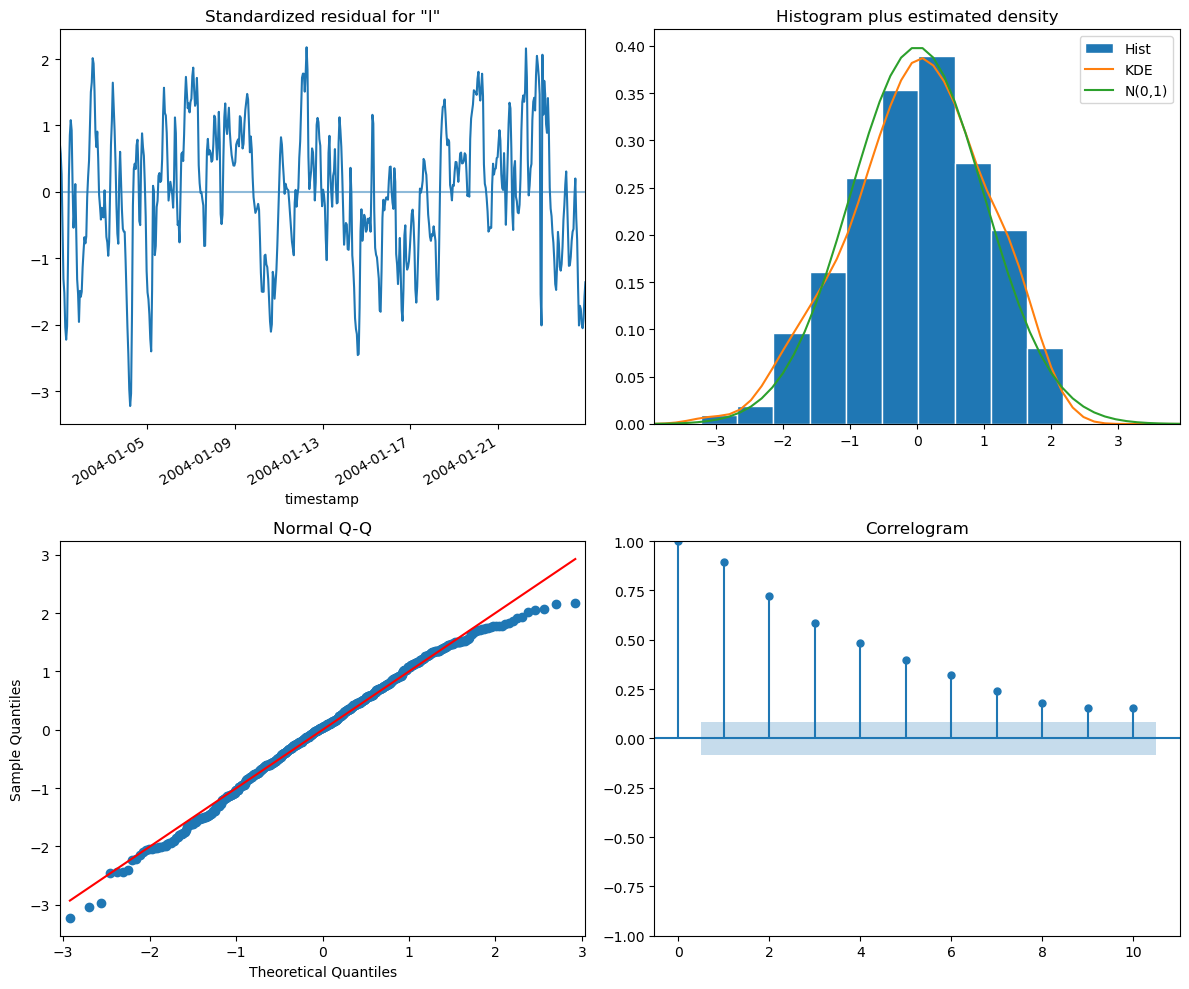

In [14]:
# Diagnostics for (0,0,0,0)) 

import statsmodels.api as sm
SARIMA_model = sm.tsa.statespace.SARIMAX(
        endog = load_long_z1_2004_jan_train["log_load_rs"].asfreq('h'), 
        exog = load_long_z1_2004_jan_train[["HDK", "CDK", "const", "trend", "holiday", "sin(1,24)", "cos(1,24)", "sin(2,24)", "cos(2,24)"]].asfreq('h'), 
        order=(0,0,0),  # non-seasonal: with no differencing
        seasonal_order=(0,0,0,24) # seasonal: with no seasonal differencing
)

SARIMA_model_fit = SARIMA_model.fit(disp=False, maxiter=400)
SARIMA_model_fit.plot_diagnostics(figsize=(12,10))
plt.tight_layout()
plt.show()

Residual plot follows Gaussian dist. but uncaptured autocorrelation still persists.

In [15]:
# Creating test data
load_long_z1_2004_jan_test = mul_df.loc[mul_df.month == 1,:]
load_long_z1_2004_jan_test = load_long_z1_2004_jan_test.set_index("timestamp")
load_long_z1_2004_jan_test = load_long_z1_2004_jan_test['2004-01-25 00:30:00':]
load_long_z1_2004_jan_test.index = pd.to_datetime(load_long_z1_2004_jan_test.index)
load_long_z1_2004_jan_test.head()

year  month  day   hour  log_load_rs  temp_weighted  \
timestamp                                                                  
2004-01-25 00:30:00  2004      1   25  00:30     3.094174      21.155292   
2004-01-25 01:30:00  2004      1   25  01:30     3.101713      20.058817   
2004-01-25 02:30:00  2004      1   25  02:30     3.144626      19.051006   
2004-01-25 03:30:00  2004      1   25  03:30     3.160441      18.246300   
2004-01-25 04:30:00  2004      1   25  04:30     3.197407      17.700175   

                     holiday        HDK  CDK  const  
timestamp                                            
2004-01-25 00:30:00        0  33.844708  0.0      1  
2004-01-25 01:30:00        0  34.941183  0.0      1  
2004-01-25 02:30:00        0  35.948994  0.0      1  
2004-01-25 03:30:00        0  36.753700  0.0      1  
2004-01-25 04:30:00        0  37.299825  0.0      1

In [16]:
# Defining the sine wave
dp = DeterministicProcess(
    index=load_long_z1_2004_jan_test.index,
    period=None,         # It's not defined so that frequency can be read from the index
    constant=False,      # Let regression model define this intercept later on
    order=1,             # linear trend needed 
    seasonal=False,      # no seasonal dummies
    additional_terms=[periodicity], # 2 seperate waves will be generated
    drop=True            # if perfect collinearity exists, the terms can be dropped
)

waves = dp.in_sample()
waves.head()

trend  sin(1,24)  cos(1,24)  sin(2,24)     cos(2,24)
timestamp                                                                
2004-01-25 00:30:00    1.0   0.000000   1.000000   0.000000  1.000000e+00
2004-01-25 01:30:00    2.0   0.258819   0.965926   0.500000  8.660254e-01
2004-01-25 02:30:00    3.0   0.500000   0.866025   0.866025  5.000000e-01
2004-01-25 03:30:00    4.0   0.707107   0.707107   1.000000  6.123234e-17
2004-01-25 04:30:00    5.0   0.866025   0.500000   0.866025 -5.000000e-01

In [17]:
# Combining fourier terms with other variables - test set
load_long_z1_2004_jan_test = load_long_z1_2004_jan_test.merge(waves, on='timestamp', how='left')
load_long_z1_2004_jan_test.head()

year  month  day   hour  log_load_rs  temp_weighted  \
timestamp                                                                  
2004-01-25 00:30:00  2004      1   25  00:30     3.094174      21.155292   
2004-01-25 01:30:00  2004      1   25  01:30     3.101713      20.058817   
2004-01-25 02:30:00  2004      1   25  02:30     3.144626      19.051006   
2004-01-25 03:30:00  2004      1   25  03:30     3.160441      18.246300   
2004-01-25 04:30:00  2004      1   25  04:30     3.197407      17.700175   

                     holiday        HDK  CDK  const  trend  sin(1,24)  \
timestamp                                                               
2004-01-25 00:30:00        0  33.844708  0.0      1    1.0   0.000000   
2004-01-25 01:30:00        0  34.941183  0.0      1    2.0   0.258819   
2004-01-25 02:30:00        0  35.948994  0.0      1    3.0   0.500000   
2004-01-25 03:30:00        0  36.753700  0.0      1    4.0   0.707107   
2004-01-25 04:30:00        0  37.299825  0.0      1    5.0   0.866025   

                     cos(1,24)  sin(2,24)     cos(2,24)  
timestamp                                                
2004-01-25 00:30:00   1.000000   0.000000  1.000000e+00  
2004-01-25 01:30:00   0.965926   0.500000  8.660254e-01  
2004-01-25 02:30:00   0.866025   0.866025  5.000000e-01  
2004-01-25 03:30:00   0.707107   1.000000  6.123234e-17  
2004-01-25 04:30:00   0.500000   0.866025 -5.000000e-01

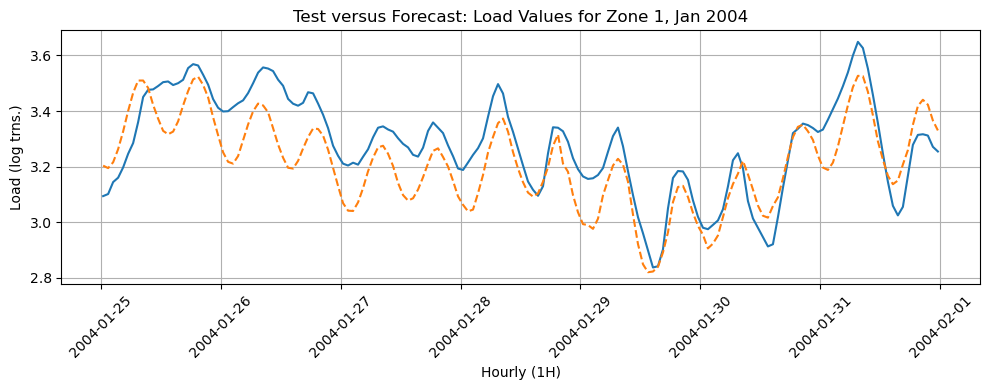

In [18]:
# Predicting 24*7 steps ahead
forecast_jan04 = SARIMA_model_fit.get_forecast(
    steps=24*7, 
    exog = load_long_z1_2004_jan_test[["HDK", "CDK", "const", "trend", "holiday", "sin(1,24)", "cos(1,24)", "sin(2,24)", "cos(2,24)"]].asfreq('h')
).predicted_mean

# Fit on the test data
import seaborn as sns
fig, ax = plt.subplots(figsize=(10, 4))
sns.lineplot(data=load_long_z1_2004_jan_test, x=load_long_z1_2004_jan_test.index, y=load_long_z1_2004_jan_test["log_load_rs"].asfreq('h'), ax=ax)
sns.lineplot(forecast_jan04, linestyle = '--')
ax.set_title("Test versus Forecast: Load Values for Zone 1, Jan 2004")
ax.set_xlabel("Hourly (1H)")
ax.set_ylabel("Load (log trns.)")
ax.grid(True)
ax.tick_params(axis="x", rotation=45)

plt.tight_layout()
plt.show()

In [19]:
# Performance on test set

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
print(f"R2 score: {r2_score(load_long_z1_2004_jan_test.log_load_rs, forecast_jan04)}")
print(f'MSE score: {mean_squared_error(load_long_z1_2004_jan_test.log_load_rs, forecast_jan04)}')
print(f'MAE score: {mean_absolute_error(load_long_z1_2004_jan_test.log_load_rs, forecast_jan04)}')
print(f'MAPE score: {mean_absolute_percentage_error(load_long_z1_2004_jan_test.log_load_rs, forecast_jan04)}')

R2 score: 0.5593316509697287
MSE score: 0.013458689673219816
MAE score: 0.10236333798819389
MAPE score: 0.030988087747363408


- Performance improvement is significant and much better that ES.
- Defining intercept this way led to better performance increase.

##### Testing on Last Week of Apr 2004 (Zone 1)
Last week of Apr 2004 is used for testing. Multiple SARIMAX models are evaluated and compared. 

In [20]:
# Creating training data
load_long_z1_2004_apr_train = mul_df.loc[mul_df.month == 4,:]
load_long_z1_2004_apr_train = load_long_z1_2004_apr_train.set_index("timestamp")
load_long_z1_2004_apr_train = load_long_z1_2004_apr_train[:'2004-04-23 23:30:00']
load_long_z1_2004_apr_train.index = pd.to_datetime(load_long_z1_2004_apr_train.index)
load_long_z1_2004_apr_train.head()

year  month  day   hour  log_load_rs  temp_weighted  \
timestamp                                                                  
2004-04-01 00:30:00  2004      4    1  00:30     2.645820      45.453562   
2004-04-01 01:30:00  2004      4    1  01:30     2.633901      45.547368   
2004-04-01 02:30:00  2004      4    1  02:30     2.633039      45.454863   
2004-04-01 03:30:00  2004      4    1  03:30     2.646246      45.454863   
2004-04-01 04:30:00  2004      4    1  04:30     2.688528      45.191047   

                     holiday       HDK  CDK  const  
timestamp                                           
2004-04-01 00:30:00        0  9.546438  0.0      1  
2004-04-01 01:30:00        0  9.452632  0.0      1  
2004-04-01 02:30:00        0  9.545137  0.0      1  
2004-04-01 03:30:00        0  9.545137  0.0      1  
2004-04-01 04:30:00        0  9.808953  0.0      1

In [21]:
# Defining the sine wave
dp = DeterministicProcess(
    index=load_long_z1_2004_apr_train.index,
    period=None,         # It's not defined so that frequency can be read from the index
    constant=False,      # Let regression model define this intercept later on
    order=1,             
    seasonal=False,      # no seasonal dummies
    additional_terms=[periodicity], # 2 seperate waves will be generated
    drop=True            # if perfect collinearity exists, the terms can be dropped
)

waves = dp.in_sample()

# Combining fourier terms with other variables
load_long_z1_2004_apr_train = load_long_z1_2004_apr_train.merge(waves, on='timestamp', how='left')
load_long_z1_2004_apr_train.head()

year  month  day   hour  log_load_rs  temp_weighted  \
timestamp                                                                  
2004-04-01 00:30:00  2004      4    1  00:30     2.645820      45.453562   
2004-04-01 01:30:00  2004      4    1  01:30     2.633901      45.547368   
2004-04-01 02:30:00  2004      4    1  02:30     2.633039      45.454863   
2004-04-01 03:30:00  2004      4    1  03:30     2.646246      45.454863   
2004-04-01 04:30:00  2004      4    1  04:30     2.688528      45.191047   

                     holiday       HDK  CDK  const  trend  sin(1,24)  \
timestamp                                                              
2004-04-01 00:30:00        0  9.546438  0.0      1    1.0   0.000000   
2004-04-01 01:30:00        0  9.452632  0.0      1    2.0   0.258819   
2004-04-01 02:30:00        0  9.545137  0.0      1    3.0   0.500000   
2004-04-01 03:30:00        0  9.545137  0.0      1    4.0   0.707107   
2004-04-01 04:30:00        0  9.808953  0.0      1    5.0   0.866025   

                     cos(1,24)  sin(2,24)     cos(2,24)  
timestamp                                                
2004-04-01 00:30:00   1.000000   0.000000  1.000000e+00  
2004-04-01 01:30:00   0.965926   0.500000  8.660254e-01  
2004-04-01 02:30:00   0.866025   0.866025  5.000000e-01  
2004-04-01 03:30:00   0.707107   1.000000  6.123234e-17  
2004-04-01 04:30:00   0.500000   0.866025 -5.000000e-01

In [22]:
# Comparing models - auto_arima 

smodel_apr = pm.auto_arima(y = load_long_z1_2004_apr_train["log_load_rs"].asfreq('h'), 
                           X = load_long_z1_2004_apr_train[["HDK", "CDK", "const", "trend", "holiday", "sin(1,24)", "cos(1,24)", "sin(2,24)", "cos(2,24)"]].asfreq('h'),
                           start_p=0, start_q=0,test='adf',
                           max_p=3, max_q=3, m=24,
                           start_P=0, start_Q=0, max_P=2, max_Q=2, seasonal=True,
                           d=0, D=0, trace=True,
                           error_action='trace',  
                           suppress_warnings=True, 
                           stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[24] intercept   : AIC=inf, Time=nan sec
 ARIMA(1,0,0)(1,0,0)[24] intercept   : AIC=inf, Time=nan sec
 ARIMA(0,0,1)(0,0,1)[24] intercept   : AIC=inf, Time=nan sec


C:\Users\singh\anaconda3\Lib\site-packages\pmdarima\arima\_auto_solvers.py:524: ModelFitWarning: Error fitting  ARIMA(0,0,0)(0,0,0)[24] intercept (if you do not want to see these warnings, run with error_action="ignore").
Traceback:
Traceback (most recent call last):
  File "C:\Users\singh\anaconda3\Lib\site-packages\pmdarima\arima\_auto_solvers.py", line 508, in _fit_candidate_model
    fit.fit(y, X=X, **fit_params)
  File "C:\Users\singh\anaconda3\Lib\site-packages\pmdarima\arima\arima.py", line 603, in fit
    self._fit(y, X, **fit_args)
  File "C:\Users\singh\anaconda3\Lib\site-packages\pmdarima\arima\arima.py", line 524, in _fit
    fit, self.arima_res_ = _fit_wrapper()
                           ^^^^^^^^^^^^^^
  File "C:\Users\singh\anaconda3\Lib\site-packages\pmdarima\arima\arima.py", line 489, in _fit_wrapper
    arima = sm.tsa.statespace.SARIMAX(
            ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\singh\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py", li

 ARIMA(0,0,0)(0,0,0)[24]             : AIC=-838.022, Time=1.06 sec
 ARIMA(0,0,0)(1,0,0)[24] intercept   : AIC=inf, Time=nan sec
 ARIMA(0,0,0)(0,0,1)[24] intercept   : AIC=inf, Time=nan sec
 ARIMA(0,0,0)(1,0,1)[24] intercept   : AIC=inf, Time=nan sec
 ARIMA(1,0,0)(0,0,0)[24] intercept   : AIC=inf, Time=nan sec
 ARIMA(0,0,1)(0,0,0)[24] intercept   : AIC=inf, Time=nan sec
 ARIMA(1,0,1)(0,0,0)[24] intercept   : AIC=inf, Time=nan sec

Best model:  ARIMA(0,0,0)(0,0,0)[24]          
Total fit time: 1.087 seconds


C:\Users\singh\anaconda3\Lib\site-packages\pmdarima\arima\_auto_solvers.py:524: ModelFitWarning: Error fitting  ARIMA(0,0,0)(1,0,0)[24] intercept (if you do not want to see these warnings, run with error_action="ignore").
Traceback:
Traceback (most recent call last):
  File "C:\Users\singh\anaconda3\Lib\site-packages\pmdarima\arima\_auto_solvers.py", line 508, in _fit_candidate_model
    fit.fit(y, X=X, **fit_params)
  File "C:\Users\singh\anaconda3\Lib\site-packages\pmdarima\arima\arima.py", line 603, in fit
    self._fit(y, X, **fit_args)
  File "C:\Users\singh\anaconda3\Lib\site-packages\pmdarima\arima\arima.py", line 524, in _fit
    fit, self.arima_res_ = _fit_wrapper()
                           ^^^^^^^^^^^^^^
  File "C:\Users\singh\anaconda3\Lib\site-packages\pmdarima\arima\arima.py", line 489, in _fit_wrapper
    arima = sm.tsa.statespace.SARIMAX(
            ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\singh\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py", li

The best order for AR/MA components (seasonal and non-seasonal) has again changed, compared to SARIMAX without external regressors.

C:\Users\singh\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


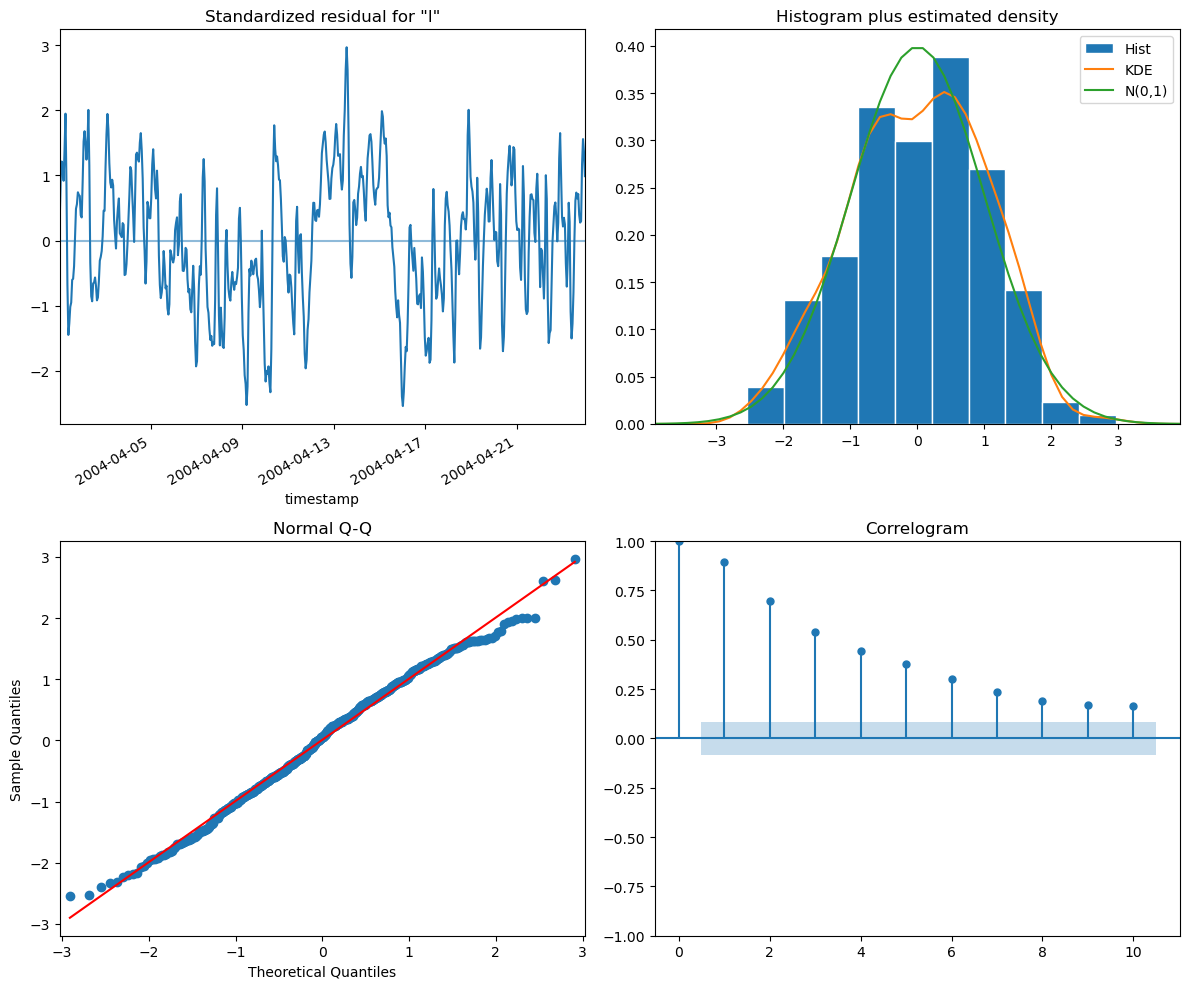

In [23]:
# Diagnostics for (0,0,0,0)) 

import statsmodels.api as sm
SARIMA_model = sm.tsa.statespace.SARIMAX(
        endog = load_long_z1_2004_apr_train["log_load_rs"].asfreq('h'), 
        exog = load_long_z1_2004_apr_train[["HDK", "CDK", "const", "trend", "holiday", "sin(1,24)", "cos(1,24)", "sin(2,24)", "cos(2,24)"]].asfreq('h'), 
        order=(0,0,0),  # non-seasonal: with no differencing
        seasonal_order=(0,0,0,24) # seasonal: with no seasonal differencing
)

SARIMA_model_fit = SARIMA_model.fit(disp=False, maxiter=600)
SARIMA_model_fit.plot_diagnostics(figsize=(12,10))
plt.tight_layout()
plt.show()

Similar to January, uncaptured correlation exists but residual distribution is fairly Gaussian.

In [24]:
# Creating test data
load_long_z1_2004_apr_test = mul_df.loc[mul_df.month == 4,:]
load_long_z1_2004_apr_test = load_long_z1_2004_apr_test.set_index("timestamp")
load_long_z1_2004_apr_test = load_long_z1_2004_apr_test['2004-04-24 00:30:00':]
load_long_z1_2004_apr_test.index = pd.to_datetime(load_long_z1_2004_apr_test.index)
load_long_z1_2004_apr_test.head()

year  month  day   hour  log_load_rs  temp_weighted  \
timestamp                                                                  
2004-04-24 00:30:00  2004      4   24  00:30     2.437728      62.266565   
2004-04-24 01:30:00  2004      4   24  01:30     2.328643      62.708075   
2004-04-24 02:30:00  2004      4   24  02:30     2.279316      61.449205   
2004-04-24 03:30:00  2004      4   24  03:30     2.249290      60.634717   
2004-04-24 04:30:00  2004      4   24  04:30     2.248657      59.824237   

                     holiday  HDK  CDK  const  
timestamp                                      
2004-04-24 00:30:00        0  0.0  0.0      1  
2004-04-24 01:30:00        0  0.0  0.0      1  
2004-04-24 02:30:00        0  0.0  0.0      1  
2004-04-24 03:30:00        0  0.0  0.0      1  
2004-04-24 04:30:00        0  0.0  0.0      1

In [25]:
# Defining the sine wave
dp = DeterministicProcess(
    index=load_long_z1_2004_apr_test.index,
    period=None,         # It's not defined so that frequency can be read from the index
    constant=False,      # Let regression model define this intercept later on
    order=1,             # allows trend to be included so that the level of the wave is allowed to change with time, linearly 
    seasonal=False,      # no seasonal dummies
    additional_terms=[periodicity], # 2 seperate waves will be generated
    drop=True            # if perfect collinearity exists, the terms can be dropped
)

waves = dp.in_sample()

# Combining fourier terms with other variables - test set
load_long_z1_2004_apr_test = load_long_z1_2004_apr_test.merge(waves, on='timestamp', how='left')
load_long_z1_2004_apr_test.head()

year  month  day   hour  log_load_rs  temp_weighted  \
timestamp                                                                  
2004-04-24 00:30:00  2004      4   24  00:30     2.437728      62.266565   
2004-04-24 01:30:00  2004      4   24  01:30     2.328643      62.708075   
2004-04-24 02:30:00  2004      4   24  02:30     2.279316      61.449205   
2004-04-24 03:30:00  2004      4   24  03:30     2.249290      60.634717   
2004-04-24 04:30:00  2004      4   24  04:30     2.248657      59.824237   

                     holiday  HDK  CDK  const  trend  sin(1,24)  cos(1,24)  \
timestamp                                                                    
2004-04-24 00:30:00        0  0.0  0.0      1    1.0   0.000000   1.000000   
2004-04-24 01:30:00        0  0.0  0.0      1    2.0   0.258819   0.965926   
2004-04-24 02:30:00        0  0.0  0.0      1    3.0   0.500000   0.866025   
2004-04-24 03:30:00        0  0.0  0.0      1    4.0   0.707107   0.707107   
2004-04-24 04:30:00        0  0.0  0.0      1    5.0   0.866025   0.500000   

                     sin(2,24)     cos(2,24)  
timestamp                                     
2004-04-24 00:30:00   0.000000  1.000000e+00  
2004-04-24 01:30:00   0.500000  8.660254e-01  
2004-04-24 02:30:00   0.866025  5.000000e-01  
2004-04-24 03:30:00   1.000000  6.123234e-17  
2004-04-24 04:30:00   0.866025 -5.000000e-01

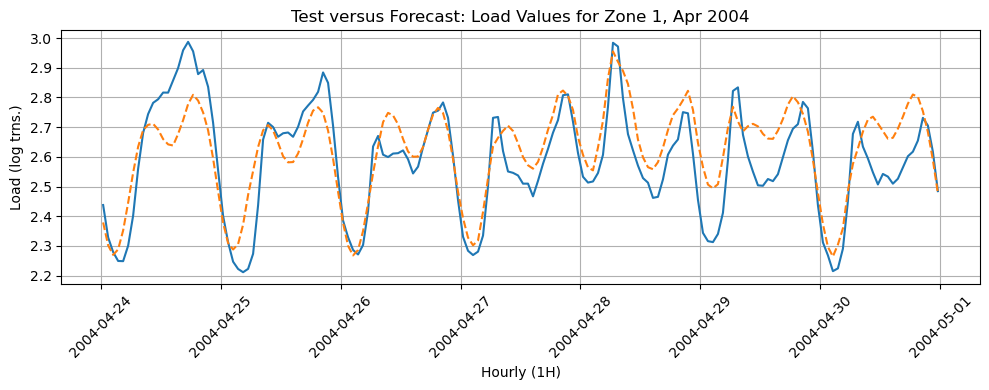

In [26]:
# Predicting 24*7 steps ahead
forecast_apr04 = SARIMA_model_fit.get_forecast(
    steps=24*7, 
    exog = load_long_z1_2004_apr_test[["HDK", "CDK", "const", "trend", "holiday", "sin(1,24)", "cos(1,24)", "sin(2,24)", "cos(2,24)"]].asfreq('h')
).predicted_mean

# Fit on the test data
fig, ax = plt.subplots(figsize=(10, 4))
sns.lineplot(data=load_long_z1_2004_apr_test, x=load_long_z1_2004_apr_test.index, y=load_long_z1_2004_apr_test.log_load_rs.asfreq('h'), ax=ax)
sns.lineplot(forecast_apr04, linestyle = '--')
ax.set_title("Test versus Forecast: Load Values for Zone 1, Apr 2004")
ax.set_xlabel("Hourly (1H)")
ax.set_ylabel("Load (log trns.)")
ax.grid(True)
ax.tick_params(axis="x", rotation=45)

plt.tight_layout()
plt.show()

In [27]:
# Performance on test set

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
print(f"R2 score: {r2_score(load_long_z1_2004_apr_test.log_load_rs, forecast_apr04)}")
print(f'MSE score: {mean_squared_error(load_long_z1_2004_apr_test.log_load_rs, forecast_apr04)}')
print(f'MAE score: {mean_absolute_error(load_long_z1_2004_apr_test.log_load_rs, forecast_apr04)}')
print(f'MAPE score: {mean_absolute_percentage_error(load_long_z1_2004_apr_test.log_load_rs, forecast_apr04)}')

R2 score: 0.6538673904350358
MSE score: 0.011839841320233538
MAE score: 0.09014651243689614
MAPE score: 0.03506152542285406


##### Testing on Last Week of Jul 2004 (Zone 1)
Last week of Jul 2004 is used for testing. Multiple SARIMAX models are evaluated and compared. 

In [28]:
# Creating training data
load_long_z1_2004_jul_train = mul_df.loc[mul_df.month == 7,:]
load_long_z1_2004_jul_train = load_long_z1_2004_jul_train.set_index("timestamp")
load_long_z1_2004_jul_train = load_long_z1_2004_jul_train[:'2004-07-24 23:30:00']
load_long_z1_2004_jul_train.index = pd.to_datetime(load_long_z1_2004_jul_train.index)
load_long_z1_2004_jul_train.head()

year  month  day   hour  log_load_rs  temp_weighted  \
timestamp                                                                  
2004-07-01 00:30:00  2004      7    1  00:30     2.658230      67.152732   
2004-07-01 01:30:00  2004      7    1  01:30     2.548507      66.148285   
2004-07-01 02:30:00  2004      7    1  02:30     2.482404      65.687669   
2004-07-01 03:30:00  2004      7    1  03:30     2.447464      64.515455   
2004-07-01 04:30:00  2004      7    1  04:30     2.430626      64.517938   

                     holiday  HDK       CDK  const  
timestamp                                           
2004-07-01 00:30:00        0  0.0  2.152732      1  
2004-07-01 01:30:00        0  0.0  1.148285      1  
2004-07-01 02:30:00        0  0.0  0.687669      1  
2004-07-01 03:30:00        0  0.0  0.000000      1  
2004-07-01 04:30:00        0  0.0  0.000000      1

In [29]:
# Defining the sine wave
dp = DeterministicProcess(
    index=load_long_z1_2004_jul_train.index,
    period=None,         # It's not defined so that frequency can be read from the index
    constant=False,      # Let regression model define this intercept later on
    order=1,             
    seasonal=False,      # no seasonal dummies
    additional_terms=[periodicity], # 2 seperate waves will be generated
    drop=True            # if perfect collinearity exists, the terms can be dropped
)

waves = dp.in_sample()

# Combining fourier terms with other variables
load_long_z1_2004_jul_train = load_long_z1_2004_jul_train.merge(waves, on='timestamp', how='left')
load_long_z1_2004_jul_train.head()

year  month  day   hour  log_load_rs  temp_weighted  \
timestamp                                                                  
2004-07-01 00:30:00  2004      7    1  00:30     2.658230      67.152732   
2004-07-01 01:30:00  2004      7    1  01:30     2.548507      66.148285   
2004-07-01 02:30:00  2004      7    1  02:30     2.482404      65.687669   
2004-07-01 03:30:00  2004      7    1  03:30     2.447464      64.515455   
2004-07-01 04:30:00  2004      7    1  04:30     2.430626      64.517938   

                     holiday  HDK       CDK  const  trend  sin(1,24)  \
timestamp                                                              
2004-07-01 00:30:00        0  0.0  2.152732      1    1.0   0.000000   
2004-07-01 01:30:00        0  0.0  1.148285      1    2.0   0.258819   
2004-07-01 02:30:00        0  0.0  0.687669      1    3.0   0.500000   
2004-07-01 03:30:00        0  0.0  0.000000      1    4.0   0.707107   
2004-07-01 04:30:00        0  0.0  0.000000      1    5.0   0.866025   

                     cos(1,24)  sin(2,24)     cos(2,24)  
timestamp                                                
2004-07-01 00:30:00   1.000000   0.000000  1.000000e+00  
2004-07-01 01:30:00   0.965926   0.500000  8.660254e-01  
2004-07-01 02:30:00   0.866025   0.866025  5.000000e-01  
2004-07-01 03:30:00   0.707107   1.000000  6.123234e-17  
2004-07-01 04:30:00   0.500000   0.866025 -5.000000e-01

In [30]:
# Comparing models - auto_arima (no differencing)

smodel_jul = pm.auto_arima(y = load_long_z1_2004_jul_train["log_load_rs"].asfreq('h'), 
                           X = load_long_z1_2004_jul_train[["HDK", "CDK", "const", "trend", "holiday", "sin(1,24)", "cos(1,24)", "sin(2,24)", "cos(2,24)"]].asfreq('h'),
                           start_p=0, start_q=0,test='adf',
                           max_p=3, max_q=3, m=24,
                           start_P=0, start_Q=0, max_P=2, max_Q=2, seasonal=True,
                           d=0, D=0, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[24] intercept   : AIC=inf, Time=nan sec
 ARIMA(1,0,0)(1,0,0)[24] intercept   : AIC=inf, Time=nan sec
 ARIMA(0,0,1)(0,0,1)[24] intercept   : AIC=inf, Time=nan sec
 ARIMA(0,0,0)(0,0,0)[24]             : AIC=-1246.289, Time=0.81 sec
 ARIMA(0,0,0)(1,0,0)[24] intercept   : AIC=inf, Time=nan sec
 ARIMA(0,0,0)(0,0,1)[24] intercept   : AIC=inf, Time=nan sec
 ARIMA(0,0,0)(1,0,1)[24] intercept   : AIC=inf, Time=nan sec
 ARIMA(1,0,0)(0,0,0)[24] intercept   : AIC=inf, Time=nan sec
 ARIMA(0,0,1)(0,0,0)[24] intercept   : AIC=inf, Time=nan sec
 ARIMA(1,0,1)(0,0,0)[24] intercept   : AIC=inf, Time=nan sec

Best model:  ARIMA(0,0,0)(0,0,0)[24]          
Total fit time: 0.822 seconds


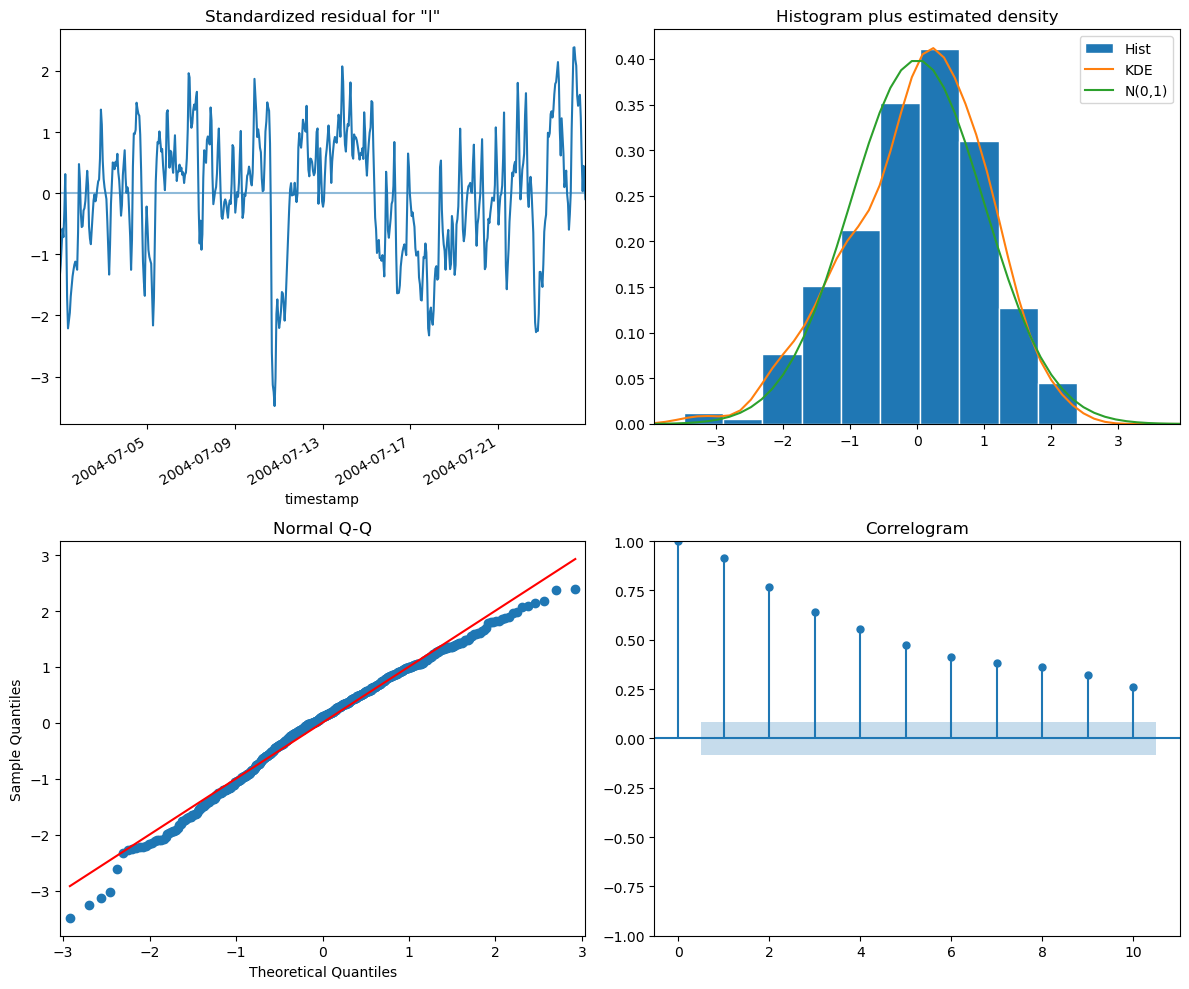

In [31]:
# Diagnostics for (0,0,0,0)) 

SARIMA_model = sm.tsa.statespace.SARIMAX(
        endog = load_long_z1_2004_jul_train["log_load_rs"].asfreq('h'), 
        exog = load_long_z1_2004_jul_train[["HDK", "CDK", "const", "trend", "holiday", "sin(1,24)", "cos(1,24)", "sin(2,24)", "cos(2,24)"]].asfreq('h'), 
        order=(0,0,0),  # non-seasonal: with no differencing
        seasonal_order=(0,0,0,24) # seasonal: with no seasonal differencing
        )

SARIMA_model_fit = SARIMA_model.fit(disp=False, maxiter=500)
SARIMA_model_fit.plot_diagnostics(figsize=(12,10))
plt.tight_layout()
plt.show()

Residual dist is closely Gaussian, though autocorrelation isn't strongly captured.

In [32]:
# Creating test data
load_long_z1_2004_jul_test = mul_df.loc[mul_df.month == 7,:]
load_long_z1_2004_jul_test = load_long_z1_2004_jul_test.set_index("timestamp")
load_long_z1_2004_jul_test = load_long_z1_2004_jul_test['2004-07-25 00:30:00':]
load_long_z1_2004_jul_test.index = pd.to_datetime(load_long_z1_2004_jul_test.index)
load_long_z1_2004_jul_test.head()

year  month  day   hour  log_load_rs  temp_weighted  \
timestamp                                                                  
2004-07-25 00:30:00  2004      7   25  00:30     2.669517      70.616043   
2004-07-25 01:30:00  2004      7   25  01:30     2.551552      70.893317   
2004-07-25 02:30:00  2004      7   25  02:30     2.486073      70.710504   
2004-07-25 03:30:00  2004      7   25  03:30     2.441738      70.526899   
2004-07-25 04:30:00  2004      7   25  04:30     2.429834      70.527349   

                     holiday  HDK       CDK  const  
timestamp                                           
2004-07-25 00:30:00        0  0.0  5.616043      1  
2004-07-25 01:30:00        0  0.0  5.893317      1  
2004-07-25 02:30:00        0  0.0  5.710504      1  
2004-07-25 03:30:00        0  0.0  5.526899      1  
2004-07-25 04:30:00        0  0.0  5.527349      1

In [33]:
# Defining the sine wave
dp = DeterministicProcess(
    index=load_long_z1_2004_jul_test.index,
    period=None,         # It's not defined so that frequency can be read from the index
    constant=False,      # Let regression model define this intercept later on
    order=1,              
    seasonal=False,      # no seasonal dummies
    additional_terms=[periodicity], # 2 seperate waves will be generated
    drop=True            # if perfect collinearity exists, the terms can be dropped
)

waves = dp.in_sample()

# Combining fourier terms with other variables - test set
load_long_z1_2004_jul_test = load_long_z1_2004_jul_test.merge(waves, on='timestamp', how='left')
load_long_z1_2004_jul_test.head()

year  month  day   hour  log_load_rs  temp_weighted  \
timestamp                                                                  
2004-07-25 00:30:00  2004      7   25  00:30     2.669517      70.616043   
2004-07-25 01:30:00  2004      7   25  01:30     2.551552      70.893317   
2004-07-25 02:30:00  2004      7   25  02:30     2.486073      70.710504   
2004-07-25 03:30:00  2004      7   25  03:30     2.441738      70.526899   
2004-07-25 04:30:00  2004      7   25  04:30     2.429834      70.527349   

                     holiday  HDK       CDK  const  trend  sin(1,24)  \
timestamp                                                              
2004-07-25 00:30:00        0  0.0  5.616043      1    1.0   0.000000   
2004-07-25 01:30:00        0  0.0  5.893317      1    2.0   0.258819   
2004-07-25 02:30:00        0  0.0  5.710504      1    3.0   0.500000   
2004-07-25 03:30:00        0  0.0  5.526899      1    4.0   0.707107   
2004-07-25 04:30:00        0  0.0  5.527349      1    5.0   0.866025   

                     cos(1,24)  sin(2,24)     cos(2,24)  
timestamp                                                
2004-07-25 00:30:00   1.000000   0.000000  1.000000e+00  
2004-07-25 01:30:00   0.965926   0.500000  8.660254e-01  
2004-07-25 02:30:00   0.866025   0.866025  5.000000e-01  
2004-07-25 03:30:00   0.707107   1.000000  6.123234e-17  
2004-07-25 04:30:00   0.500000   0.866025 -5.000000e-01

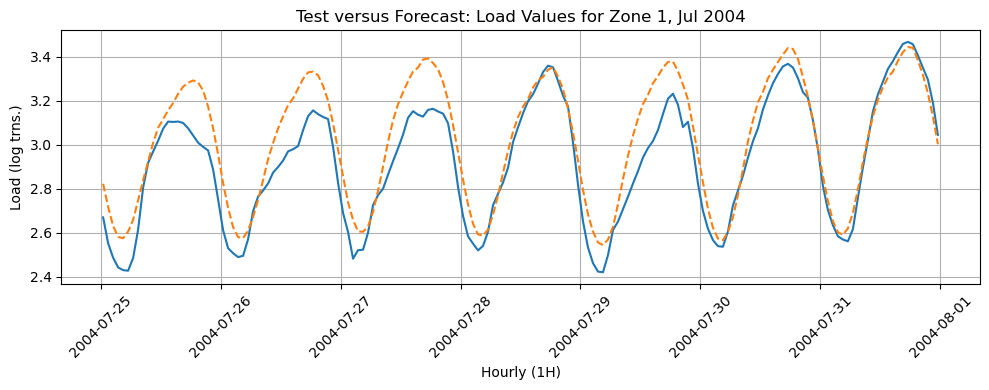

In [34]:
# Predicting 24*7 steps ahead
forecast_jul04 = SARIMA_model_fit.get_forecast(
    steps=24*7, 
    exog = load_long_z1_2004_jul_test[["HDK", "CDK", "const", "trend", "holiday", "sin(1,24)", "cos(1,24)", "sin(2,24)", "cos(2,24)"]].asfreq('h')
).predicted_mean

# Fit on the test data
fig, ax = plt.subplots(figsize=(10, 4))
sns.lineplot(data=load_long_z1_2004_jul_test, x=load_long_z1_2004_jul_test.index, y=load_long_z1_2004_jul_test.log_load_rs.asfreq('h'), ax=ax)
sns.lineplot(forecast_jul04, linestyle = '--')
ax.set_title("Test versus Forecast: Load Values for Zone 1, Jul 2004")
ax.set_xlabel("Hourly (1H)")
ax.set_ylabel("Load (log trns.)")
ax.grid(True)
ax.tick_params(axis="x", rotation=45)

plt.tight_layout()
plt.show()

In [35]:
# Performance on test set

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
print(f"R2 score: {r2_score(load_long_z1_2004_jul_test.log_load_rs, forecast_jul04)}")
print(f'MSE score: {mean_squared_error(load_long_z1_2004_jul_test.log_load_rs, forecast_jul04)}')
print(f'MAE score: {mean_absolute_error(load_long_z1_2004_jul_test.log_load_rs, forecast_jul04)}')
print(f'MAPE score: {mean_absolute_percentage_error(load_long_z1_2004_jul_test.log_load_rs, forecast_jul04)}')

R2 score: 0.7905939241723361
MSE score: 0.016537999393338932
MAE score: 0.10456236113613981
MAPE score: 0.0362759847805724


##### Testing on Last Week of Oct 2004 (Zone 1)
Last week of Oct 2004 is used for testing. Multiple SARIMAX models are evaluated and compared. 

In [36]:
# Creating training data
load_long_z1_2004_oct_train = mul_df.loc[mul_df.month == 10,:]
load_long_z1_2004_oct_train = load_long_z1_2004_oct_train.set_index("timestamp")
load_long_z1_2004_oct_train = load_long_z1_2004_oct_train[:'2004-10-24 23:30:00']
load_long_z1_2004_oct_train.index = pd.to_datetime(load_long_z1_2004_oct_train.index)
load_long_z1_2004_oct_train.head()

year  month  day   hour  log_load_rs  temp_weighted  \
timestamp                                                                  
2004-10-01 00:30:00  2004     10    1  00:30     2.410093      60.792180   
2004-10-01 01:30:00  2004     10    1  01:30     2.324444      60.513850   
2004-10-01 02:30:00  2004     10    1  02:30     2.293544      60.152501   
2004-10-01 03:30:00  2004     10    1  03:30     2.289399      59.693854   
2004-10-01 04:30:00  2004     10    1  04:30     2.303684      59.417333   

                     holiday  HDK  CDK  const  
timestamp                                      
2004-10-01 00:30:00        0  0.0  0.0      1  
2004-10-01 01:30:00        0  0.0  0.0      1  
2004-10-01 02:30:00        0  0.0  0.0      1  
2004-10-01 03:30:00        0  0.0  0.0      1  
2004-10-01 04:30:00        0  0.0  0.0      1

In [37]:
# Defining the sine wave
dp = DeterministicProcess(
    index=load_long_z1_2004_oct_train.index,
    period=None,         # It's not defined so that frequency can be read from the index
    constant=False,      # Let regression model define this intercept later on
    order=1,             
    seasonal=False,      # no seasonal dummies
    additional_terms=[periodicity], # 2 seperate waves will be generated
    drop=True            # if perfect collinearity exists, the terms can be dropped
)

waves = dp.in_sample()

# Combining fourier terms with other variables
load_long_z1_2004_oct_train = load_long_z1_2004_oct_train.merge(waves, on='timestamp', how='left')
load_long_z1_2004_oct_train.head()

year  month  day   hour  log_load_rs  temp_weighted  \
timestamp                                                                  
2004-10-01 00:30:00  2004     10    1  00:30     2.410093      60.792180   
2004-10-01 01:30:00  2004     10    1  01:30     2.324444      60.513850   
2004-10-01 02:30:00  2004     10    1  02:30     2.293544      60.152501   
2004-10-01 03:30:00  2004     10    1  03:30     2.289399      59.693854   
2004-10-01 04:30:00  2004     10    1  04:30     2.303684      59.417333   

                     holiday  HDK  CDK  const  trend  sin(1,24)  cos(1,24)  \
timestamp                                                                    
2004-10-01 00:30:00        0  0.0  0.0      1    1.0   0.000000   1.000000   
2004-10-01 01:30:00        0  0.0  0.0      1    2.0   0.258819   0.965926   
2004-10-01 02:30:00        0  0.0  0.0      1    3.0   0.500000   0.866025   
2004-10-01 03:30:00        0  0.0  0.0      1    4.0   0.707107   0.707107   
2004-10-01 04:30:00        0  0.0  0.0      1    5.0   0.866025   0.500000   

                     sin(2,24)     cos(2,24)  
timestamp                                     
2004-10-01 00:30:00   0.000000  1.000000e+00  
2004-10-01 01:30:00   0.500000  8.660254e-01  
2004-10-01 02:30:00   0.866025  5.000000e-01  
2004-10-01 03:30:00   1.000000  6.123234e-17  
2004-10-01 04:30:00   0.866025 -5.000000e-01

In [38]:
# Comparing models - auto_arima (no differencing since regr residuals are stationary)

smodel_oct = pm.auto_arima(y = load_long_z1_2004_oct_train["log_load_rs"].asfreq('h'), 
                           X = load_long_z1_2004_oct_train[["HDK", "CDK", "const", "trend", "holiday", "sin(1,24)", "cos(1,24)", "sin(2,24)", "cos(2,24)"]].asfreq('h'),
                           start_p=0, start_q=0,test='adf',
                           max_p=3, max_q=3, m=24,
                           start_P=0, start_Q=0, max_P=2, max_Q=2, seasonal=True,
                           d=0, D=0, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[24] intercept   : AIC=inf, Time=nan sec
 ARIMA(1,0,0)(1,0,0)[24] intercept   : AIC=inf, Time=nan sec
 ARIMA(0,0,1)(0,0,1)[24] intercept   : AIC=inf, Time=nan sec
 ARIMA(0,0,0)(0,0,0)[24]             : AIC=-1441.999, Time=1.12 sec
 ARIMA(0,0,0)(1,0,0)[24] intercept   : AIC=inf, Time=nan sec
 ARIMA(0,0,0)(0,0,1)[24] intercept   : AIC=inf, Time=nan sec
 ARIMA(0,0,0)(1,0,1)[24] intercept   : AIC=inf, Time=nan sec
 ARIMA(1,0,0)(0,0,0)[24] intercept   : AIC=inf, Time=nan sec
 ARIMA(0,0,1)(0,0,0)[24] intercept   : AIC=inf, Time=nan sec
 ARIMA(1,0,1)(0,0,0)[24] intercept   : AIC=inf, Time=nan sec

Best model:  ARIMA(0,0,0)(0,0,0)[24]          
Total fit time: 1.132 seconds


C:\Users\singh\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


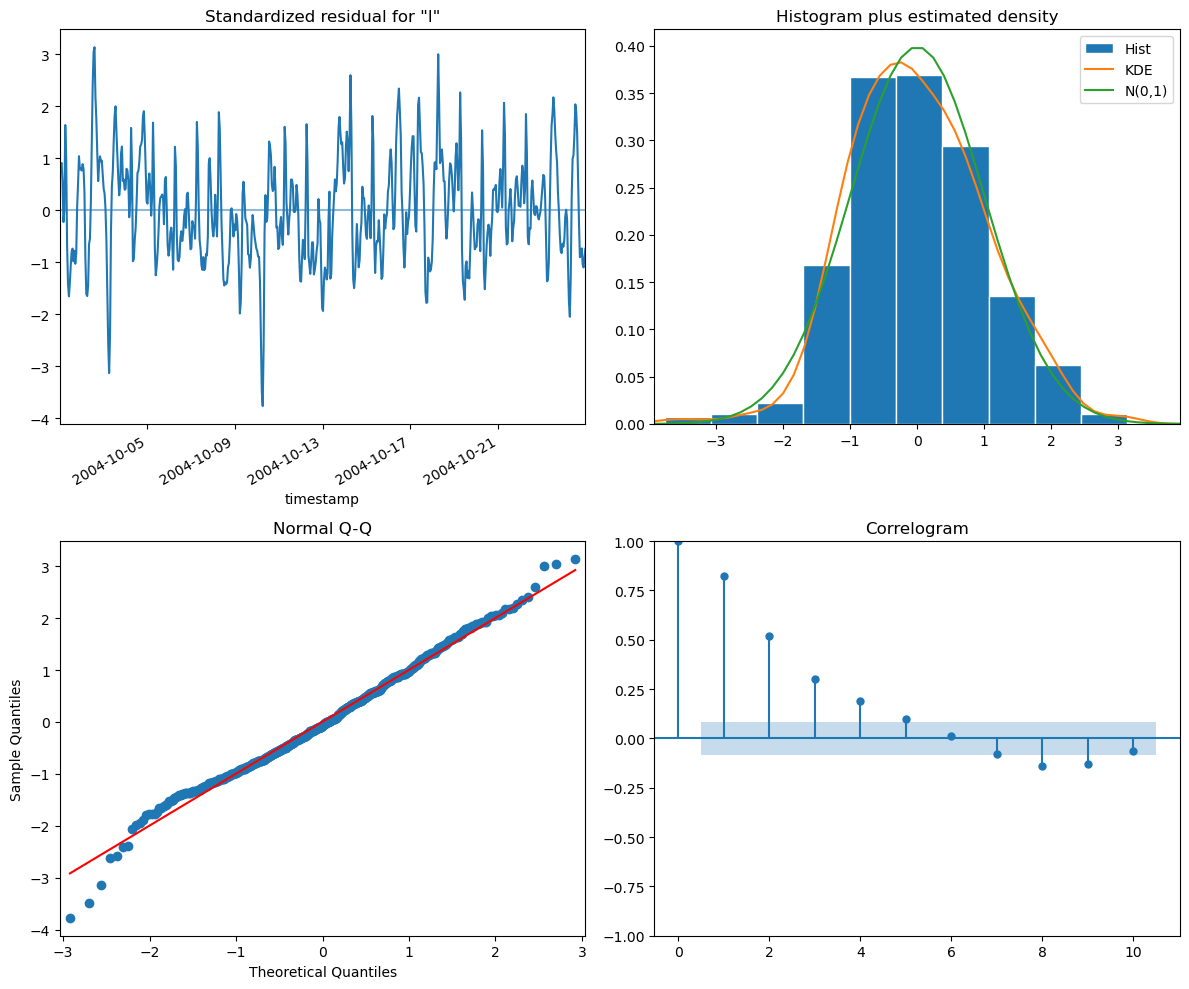

In [39]:
# Diagnostics for (0,0,0,0)

SARIMA_model = sm.tsa.statespace.SARIMAX(
        endog = load_long_z1_2004_oct_train["log_load_rs"].asfreq('h'), 
        exog = load_long_z1_2004_oct_train[["HDK", "CDK", "const", "trend", "holiday", "sin(1,24)", "cos(1,24)", "sin(2,24)", "cos(2,24)"]].asfreq('h'), 
        order=(0,0,0),  # non-seasonal: with no differencing
        seasonal_order=(0,0,0,24) # seasonal: with no seasonal differencing
        )

SARIMA_model_fit = SARIMA_model.fit(disp=False, maxiter=500)
SARIMA_model_fit.plot_diagnostics(figsize=(12,10))
plt.tight_layout()
plt.show()

In [40]:
# Creating test data
load_long_z1_2004_oct_test = mul_df.loc[mul_df.month == 10,:]
load_long_z1_2004_oct_test = load_long_z1_2004_oct_test.set_index("timestamp")
load_long_z1_2004_oct_test = load_long_z1_2004_oct_test['2004-10-25 00:30:00':]
load_long_z1_2004_oct_test.index = pd.to_datetime(load_long_z1_2004_oct_test.index)
load_long_z1_2004_oct_test.head()

year  month  day   hour  log_load_rs  temp_weighted  \
timestamp                                                                  
2004-10-25 00:30:00  2004     10   25  00:30     2.449970      50.290127   
2004-10-25 01:30:00  2004     10   25  01:30     2.407305      50.291859   
2004-10-25 02:30:00  2004     10   25  02:30     2.395164      50.658222   
2004-10-25 03:30:00  2004     10   25  03:30     2.396531      50.571048   
2004-10-25 04:30:00  2004     10   25  04:30     2.434403      50.467636   

                     holiday       HDK  CDK  const  
timestamp                                           
2004-10-25 00:30:00        0  4.709873  0.0      1  
2004-10-25 01:30:00        0  4.708141  0.0      1  
2004-10-25 02:30:00        0  4.341778  0.0      1  
2004-10-25 03:30:00        0  4.428952  0.0      1  
2004-10-25 04:30:00        0  4.532364  0.0      1

In [41]:
# Defining the sine wave
dp = DeterministicProcess(
    index=load_long_z1_2004_oct_test.index,
    period=None,         # It's not defined so that frequency can be read from the index
    constant=False,      # Let regression model define this intercept later on
    order=1,              
    seasonal=False,      # no seasonal dummies
    additional_terms=[periodicity], # 2 seperate waves will be generated
    drop=True            # if perfect collinearity exists, the terms can be dropped
)

waves = dp.in_sample()

# Combining fourier terms with other variables - test set
load_long_z1_2004_oct_test = load_long_z1_2004_oct_test.merge(waves, on='timestamp', how='left')
load_long_z1_2004_oct_test.head()

year  month  day   hour  log_load_rs  temp_weighted  \
timestamp                                                                  
2004-10-25 00:30:00  2004     10   25  00:30     2.449970      50.290127   
2004-10-25 01:30:00  2004     10   25  01:30     2.407305      50.291859   
2004-10-25 02:30:00  2004     10   25  02:30     2.395164      50.658222   
2004-10-25 03:30:00  2004     10   25  03:30     2.396531      50.571048   
2004-10-25 04:30:00  2004     10   25  04:30     2.434403      50.467636   

                     holiday       HDK  CDK  const  trend  sin(1,24)  \
timestamp                                                              
2004-10-25 00:30:00        0  4.709873  0.0      1    1.0   0.000000   
2004-10-25 01:30:00        0  4.708141  0.0      1    2.0   0.258819   
2004-10-25 02:30:00        0  4.341778  0.0      1    3.0   0.500000   
2004-10-25 03:30:00        0  4.428952  0.0      1    4.0   0.707107   
2004-10-25 04:30:00        0  4.532364  0.0      1    5.0   0.866025   

                     cos(1,24)  sin(2,24)     cos(2,24)  
timestamp                                                
2004-10-25 00:30:00   1.000000   0.000000  1.000000e+00  
2004-10-25 01:30:00   0.965926   0.500000  8.660254e-01  
2004-10-25 02:30:00   0.866025   0.866025  5.000000e-01  
2004-10-25 03:30:00   0.707107   1.000000  6.123234e-17  
2004-10-25 04:30:00   0.500000   0.866025 -5.000000e-01

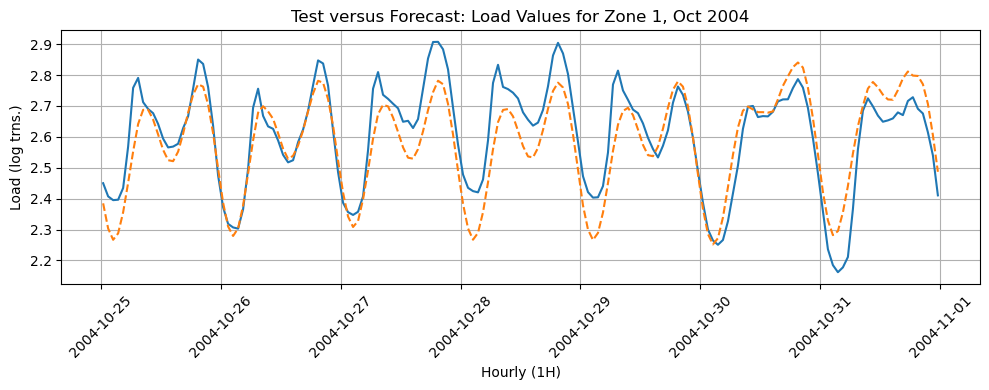

In [42]:
# Predicting 24*7 steps ahead
forecast_oct04 = SARIMA_model_fit.get_forecast(
    steps=24*7, 
    exog = load_long_z1_2004_oct_test[["HDK", "CDK", "const", "trend", "holiday", "sin(1,24)", "cos(1,24)", "sin(2,24)", "cos(2,24)"]].asfreq('h')
).predicted_mean

# Fit on the test data
fig, ax = plt.subplots(figsize=(10, 4))
sns.lineplot(data=load_long_z1_2004_oct_test, x=load_long_z1_2004_oct_test.index, y=load_long_z1_2004_oct_test.log_load_rs.asfreq('h'), ax=ax)
sns.lineplot(forecast_oct04, linestyle = '--')
ax.set_title("Test versus Forecast: Load Values for Zone 1, Oct 2004")
ax.set_xlabel("Hourly (1H)")
ax.set_ylabel("Load (log trns.)")
ax.grid(True)
ax.tick_params(axis="x", rotation=45)

plt.tight_layout()
plt.show()

In [43]:
# Performance on test set

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
print(f"R2 score: {r2_score(load_long_z1_2004_oct_test.log_load_rs, forecast_oct04)}")
print(f'MSE score: {mean_squared_error(load_long_z1_2004_oct_test.log_load_rs, forecast_oct04)}')
print(f'MAE score: {mean_absolute_error(load_long_z1_2004_oct_test.log_load_rs, forecast_oct04)}')
print(f'MAPE score: {mean_absolute_percentage_error(load_long_z1_2004_oct_test.log_load_rs, forecast_oct04)}')

R2 score: 0.7308429352123678
MSE score: 0.007600337847318925
MAE score: 0.07105673582367056
MAPE score: 0.027324029497409003


##### Testing on Last Week of Dec 2004 (Zone 1)
Last week of Dec 2004 is used for testing. Multiple SARIMAX models are evaluated and compared. 

In [44]:
# Creating training data
load_long_z1_2004_dec_train = mul_df.loc[mul_df.month == 12,:]
load_long_z1_2004_dec_train = load_long_z1_2004_dec_train.set_index("timestamp")
load_long_z1_2004_dec_train = load_long_z1_2004_dec_train[:'2004-12-24 23:30:00']
load_long_z1_2004_dec_train.index = pd.to_datetime(load_long_z1_2004_dec_train.index)
load_long_z1_2004_dec_train.head()

year  month  day   hour  log_load_rs  temp_weighted  \
timestamp                                                                  
2004-12-01 00:30:00  2004     12    1  00:30     2.650774      47.965991   
2004-12-01 01:30:00  2004     12    1  01:30     2.609481      48.609925   
2004-12-01 02:30:00  2004     12    1  02:30     2.608304      49.154281   
2004-12-01 03:30:00  2004     12    1  03:30     2.617177      50.252969   
2004-12-01 04:30:00  2004     12    1  04:30     2.646104      51.607521   

                     holiday       HDK  CDK  const  
timestamp                                           
2004-12-01 00:30:00        0  7.034009  0.0      1  
2004-12-01 01:30:00        0  6.390075  0.0      1  
2004-12-01 02:30:00        0  5.845719  0.0      1  
2004-12-01 03:30:00        0  4.747031  0.0      1  
2004-12-01 04:30:00        0  3.392479  0.0      1

In [45]:
# Defining the sine wave
dp = DeterministicProcess(
    index=load_long_z1_2004_dec_train.index,
    period=None,         # It's not defined so that frequency can be read from the index
    constant=False,      # Let regression model define this intercept later on
    order=1,             
    seasonal=False,      # no seasonal dummies
    additional_terms=[periodicity], # 2 seperate waves will be generated
    drop=True            # if perfect collinearity exists, the terms can be dropped
)

waves = dp.in_sample()

# Combining fourier terms with other variables
load_long_z1_2004_dec_train = load_long_z1_2004_dec_train.merge(waves, on='timestamp', how='left')
load_long_z1_2004_dec_train.head()

year  month  day   hour  log_load_rs  temp_weighted  \
timestamp                                                                  
2004-12-01 00:30:00  2004     12    1  00:30     2.650774      47.965991   
2004-12-01 01:30:00  2004     12    1  01:30     2.609481      48.609925   
2004-12-01 02:30:00  2004     12    1  02:30     2.608304      49.154281   
2004-12-01 03:30:00  2004     12    1  03:30     2.617177      50.252969   
2004-12-01 04:30:00  2004     12    1  04:30     2.646104      51.607521   

                     holiday       HDK  CDK  const  trend  sin(1,24)  \
timestamp                                                              
2004-12-01 00:30:00        0  7.034009  0.0      1    1.0   0.000000   
2004-12-01 01:30:00        0  6.390075  0.0      1    2.0   0.258819   
2004-12-01 02:30:00        0  5.845719  0.0      1    3.0   0.500000   
2004-12-01 03:30:00        0  4.747031  0.0      1    4.0   0.707107   
2004-12-01 04:30:00        0  3.392479  0.0      1    5.0   0.866025   

                     cos(1,24)  sin(2,24)     cos(2,24)  
timestamp                                                
2004-12-01 00:30:00   1.000000   0.000000  1.000000e+00  
2004-12-01 01:30:00   0.965926   0.500000  8.660254e-01  
2004-12-01 02:30:00   0.866025   0.866025  5.000000e-01  
2004-12-01 03:30:00   0.707107   1.000000  6.123234e-17  
2004-12-01 04:30:00   0.500000   0.866025 -5.000000e-01

In [46]:
# Comparing models - auto_arima

smodel_dec = pm.auto_arima(y = load_long_z1_2004_dec_train["log_load_rs"].asfreq('h'), 
                           X = load_long_z1_2004_dec_train[["HDK", "CDK", "const", "trend", "holiday", "sin(1,24)", "cos(1,24)", "sin(2,24)", "cos(2,24)"]].asfreq('h'),
                           start_p=0, start_q=0,test='adf',
                           max_p=3, max_q=3, m=24,
                           start_P=0, start_Q=0, max_P=2, max_Q=2, seasonal=True,
                           d=0, D=0, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[24] intercept   : AIC=inf, Time=nan sec
 ARIMA(1,0,0)(1,0,0)[24] intercept   : AIC=inf, Time=nan sec
 ARIMA(0,0,1)(0,0,1)[24] intercept   : AIC=inf, Time=nan sec
 ARIMA(0,0,0)(0,0,0)[24]             : AIC=-1198.407, Time=0.89 sec
 ARIMA(0,0,0)(1,0,0)[24] intercept   : AIC=inf, Time=nan sec
 ARIMA(0,0,0)(0,0,1)[24] intercept   : AIC=inf, Time=nan sec
 ARIMA(0,0,0)(1,0,1)[24] intercept   : AIC=inf, Time=nan sec
 ARIMA(1,0,0)(0,0,0)[24] intercept   : AIC=inf, Time=nan sec
 ARIMA(0,0,1)(0,0,0)[24] intercept   : AIC=inf, Time=nan sec
 ARIMA(1,0,1)(0,0,0)[24] intercept   : AIC=inf, Time=nan sec

Best model:  ARIMA(0,0,0)(0,0,0)[24]          
Total fit time: 0.895 seconds


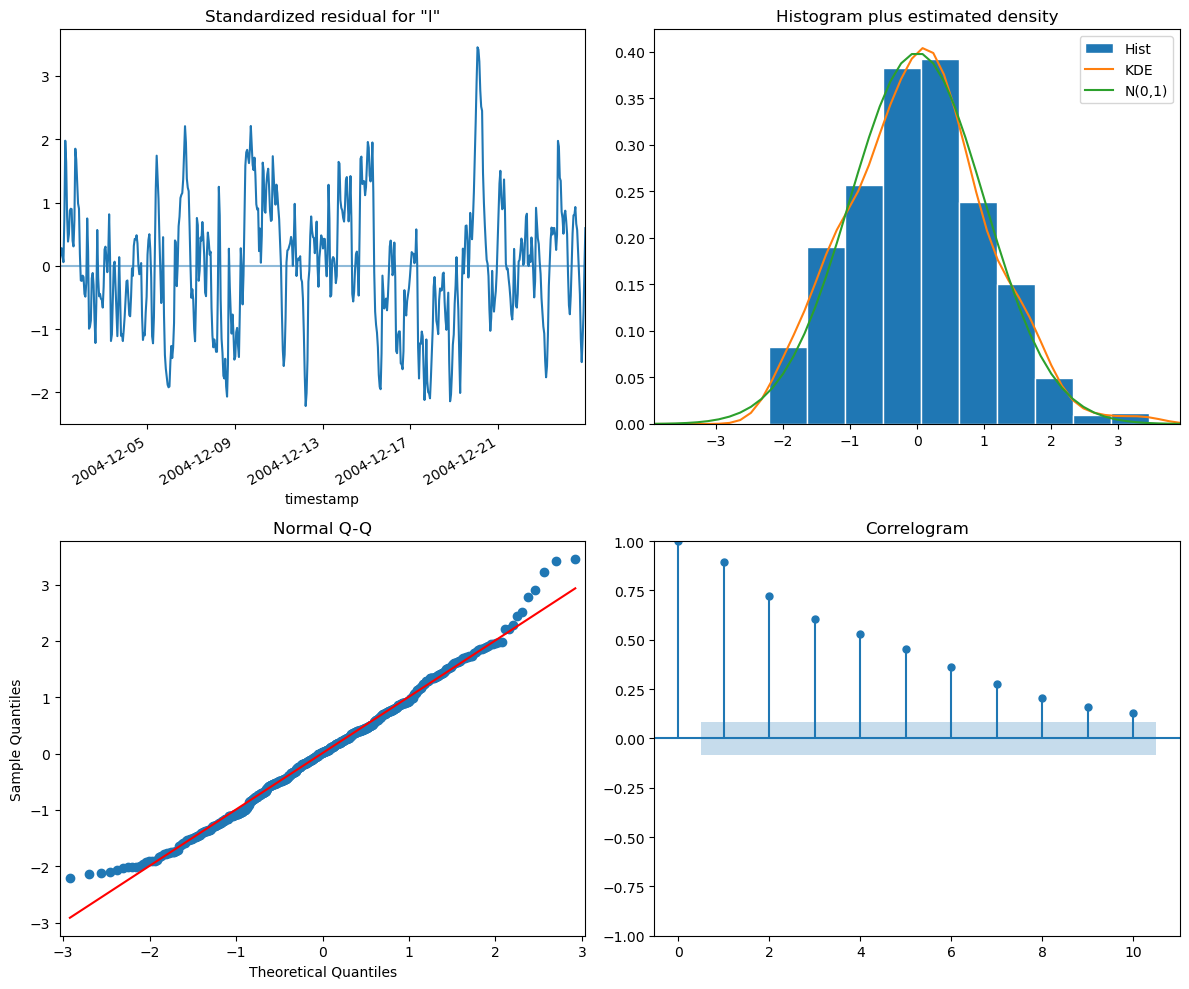

In [47]:
# Diagnostics for (0,0,0,0)

SARIMA_model = sm.tsa.statespace.SARIMAX(
        endog = load_long_z1_2004_dec_train["log_load_rs"].asfreq('h'), 
        exog = load_long_z1_2004_dec_train[["HDK", "CDK", "const", "trend", "holiday", "sin(1,24)", "cos(1,24)", "sin(2,24)", "cos(2,24)"]].asfreq('h'), 
        order=(0,0,0),  # non-seasonal: with no differencing
        seasonal_order=(0,0,0,24) # seasonal: with no seasonal differencing
        )

SARIMA_model_fit = SARIMA_model.fit(disp=False, maxiter=500)
SARIMA_model_fit.plot_diagnostics(figsize=(12,10))
plt.tight_layout()
plt.show()

In [48]:
# Creating test data
load_long_z1_2004_dec_test = mul_df.loc[mul_df.month == 12,:]
load_long_z1_2004_dec_test = load_long_z1_2004_dec_test.set_index("timestamp")
load_long_z1_2004_dec_test = load_long_z1_2004_dec_test['2004-12-25 00:30:00':]
load_long_z1_2004_dec_test.index = pd.to_datetime(load_long_z1_2004_dec_test.index)
load_long_z1_2004_dec_test.head()

year  month  day   hour  log_load_rs  temp_weighted  \
timestamp                                                                  
2004-12-25 00:30:00  2004     12   25  00:30     3.270443      25.586955   
2004-12-25 01:30:00  2004     12   25  01:30     3.272530      24.675567   
2004-12-25 02:30:00  2004     12   25  02:30     3.290191      24.681275   
2004-12-25 03:30:00  2004     12   25  03:30     3.314804      24.588997   
2004-12-25 04:30:00  2004     12   25  04:30     3.350676      24.320518   

                     holiday        HDK  CDK  const  
timestamp                                            
2004-12-25 00:30:00        0  29.413045  0.0      1  
2004-12-25 01:30:00        0  30.324433  0.0      1  
2004-12-25 02:30:00        0  30.318725  0.0      1  
2004-12-25 03:30:00        0  30.411003  0.0      1  
2004-12-25 04:30:00        0  30.679482  0.0      1

In [49]:
# Defining the sine wave
dp = DeterministicProcess(
    index=load_long_z1_2004_dec_test.index,
    period=None,         # It's not defined so that frequency can be read from the index
    constant=False,      # Let regression model define this intercept later on
    order=1,              
    seasonal=False,      # no seasonal dummies
    additional_terms=[periodicity], # 2 seperate waves will be generated
    drop=True            # if perfect collinearity exists, the terms can be dropped
)

waves = dp.in_sample()

# Combining fourier terms with other variables - test set
load_long_z1_2004_dec_test = load_long_z1_2004_dec_test.merge(waves, on='timestamp', how='left')
load_long_z1_2004_dec_test.head()

year  month  day   hour  log_load_rs  temp_weighted  \
timestamp                                                                  
2004-12-25 00:30:00  2004     12   25  00:30     3.270443      25.586955   
2004-12-25 01:30:00  2004     12   25  01:30     3.272530      24.675567   
2004-12-25 02:30:00  2004     12   25  02:30     3.290191      24.681275   
2004-12-25 03:30:00  2004     12   25  03:30     3.314804      24.588997   
2004-12-25 04:30:00  2004     12   25  04:30     3.350676      24.320518   

                     holiday        HDK  CDK  const  trend  sin(1,24)  \
timestamp                                                               
2004-12-25 00:30:00        0  29.413045  0.0      1    1.0   0.000000   
2004-12-25 01:30:00        0  30.324433  0.0      1    2.0   0.258819   
2004-12-25 02:30:00        0  30.318725  0.0      1    3.0   0.500000   
2004-12-25 03:30:00        0  30.411003  0.0      1    4.0   0.707107   
2004-12-25 04:30:00        0  30.679482  0.0      1    5.0   0.866025   

                     cos(1,24)  sin(2,24)     cos(2,24)  
timestamp                                                
2004-12-25 00:30:00   1.000000   0.000000  1.000000e+00  
2004-12-25 01:30:00   0.965926   0.500000  8.660254e-01  
2004-12-25 02:30:00   0.866025   0.866025  5.000000e-01  
2004-12-25 03:30:00   0.707107   1.000000  6.123234e-17  
2004-12-25 04:30:00   0.500000   0.866025 -5.000000e-01

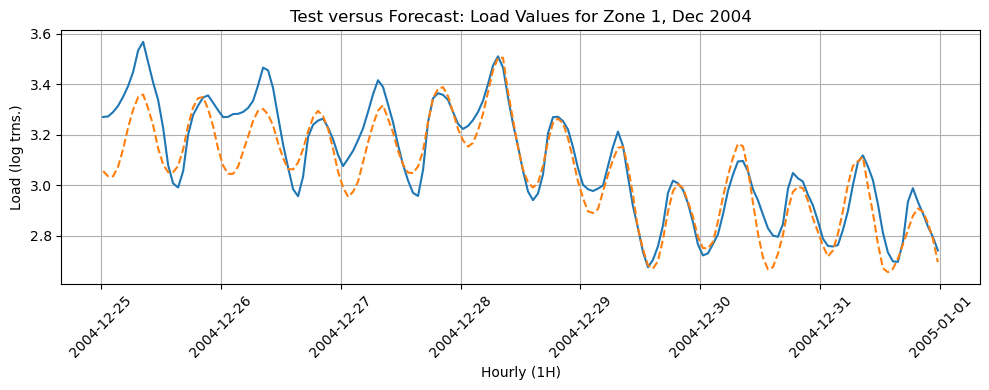

In [50]:
# Predicting 24*7 steps ahead
forecast_dec04 = SARIMA_model_fit.get_forecast(
    steps=24*7, 
    exog = load_long_z1_2004_dec_test[["HDK", "CDK", "const", "trend", "holiday", "sin(1,24)", "cos(1,24)", "sin(2,24)", "cos(2,24)"]].asfreq('h')
).predicted_mean

# Fit on the test data
fig, ax = plt.subplots(figsize=(10, 4))
sns.lineplot(data=load_long_z1_2004_dec_test, x=load_long_z1_2004_dec_test.index, y=load_long_z1_2004_dec_test.log_load_rs.asfreq('h'), ax=ax)
sns.lineplot(forecast_dec04, linestyle = '--')
ax.set_title("Test versus Forecast: Load Values for Zone 1, Dec 2004")
ax.set_xlabel("Hourly (1H)")
ax.set_ylabel("Load (log trns.)")
ax.grid(True)
ax.tick_params(axis="x", rotation=45)

plt.tight_layout()
plt.show()

In [51]:
# Performance on test set

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
print(f"R2 score: {r2_score(load_long_z1_2004_dec_test.log_load_rs, forecast_dec04)}")
print(f'MSE score: {mean_squared_error(load_long_z1_2004_dec_test.log_load_rs, forecast_dec04)}')
print(f'MAE score: {mean_absolute_error(load_long_z1_2004_dec_test.log_load_rs, forecast_dec04)}')
print(f'MAPE score: {mean_absolute_percentage_error(load_long_z1_2004_dec_test.log_load_rs, forecast_dec04)}')

R2 score: 0.8093753879226708
MSE score: 0.008944793283336833
MAE score: 0.07136330830292612
MAPE score: 0.02267885471106001


What can be concluded:
>- With no differencing, AIC chose to only let existing regression features explain variation (AIC's best choice)
>- This means no SARIMA model was actually used (p,q,P,Q = 0)
>- The added complexity of SARIMA doesn't appear to be worthy enough.

## Combining Fourier Terms with SARIMAX (D=1)
The same appraoch is used as above, but this time seasonal differencing is also used. While residuals from time series regression were found stationary, it can still exhibit seasonal pattern that might not be sufficiently addressed by harmonics.

##### Testing on Last Week of Jan 2004 (Zone 1)
Last week of Jan 2004 is used for testing. Multiple SARIMAX models are evaluated and compared. 

In [53]:
# Comparing models - auto_arima

import pmdarima as pm
smodel_jan = pm.auto_arima(y = load_long_z1_2004_jan_train["log_load_rs"].asfreq('h'), 
                           X = load_long_z1_2004_jan_train[["HDK", "CDK", "const", "trend", "holiday", "sin(1,24)", "cos(1,24)", "sin(2,24)", "cos(2,24)"]].asfreq('h'),
                           start_p=0, start_q=0,test='adf',
                           max_p=3, max_q=3, m=24,
                           start_P=0, start_Q=0, max_P=2, max_Q=2, seasonal=True,
                           d=0, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[24] intercept   : AIC=inf, Time=nan sec
 ARIMA(1,0,0)(1,1,0)[24] intercept   : AIC=inf, Time=nan sec
 ARIMA(0,0,1)(0,1,1)[24] intercept   : AIC=inf, Time=nan sec
 ARIMA(0,0,0)(0,1,0)[24]             : AIC=-896.790, Time=4.36 sec
 ARIMA(0,0,0)(1,1,0)[24] intercept   : AIC=inf, Time=nan sec
 ARIMA(0,0,0)(0,1,1)[24] intercept   : AIC=inf, Time=nan sec
 ARIMA(0,0,0)(1,1,1)[24] intercept   : AIC=inf, Time=nan sec
 ARIMA(1,0,0)(0,1,0)[24] intercept   : AIC=inf, Time=nan sec
 ARIMA(0,0,1)(0,1,0)[24] intercept   : AIC=inf, Time=nan sec
 ARIMA(1,0,1)(0,1,0)[24] intercept   : AIC=inf, Time=nan sec

Best model:  ARIMA(0,0,0)(0,1,0)[24]          
Total fit time: 4.374 seconds


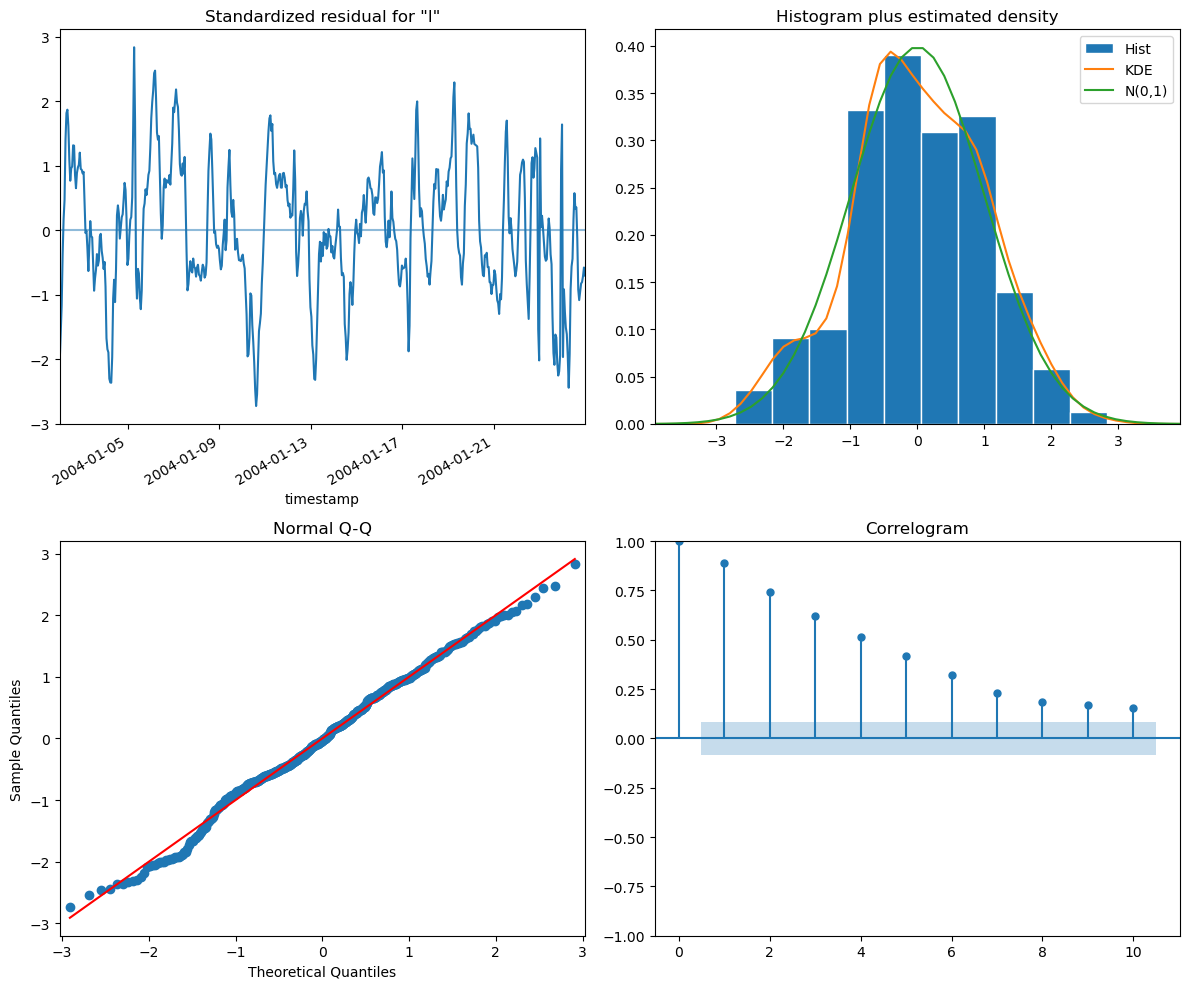

In [54]:
# Diagnostics for (0,0,0,0)) 

import statsmodels.api as sm
SARIMA_model = sm.tsa.statespace.SARIMAX(
        endog = load_long_z1_2004_jan_train["log_load_rs"].asfreq('h'), 
        exog = load_long_z1_2004_jan_train[["HDK", "CDK", "const", "trend", "holiday", "sin(1,24)", "cos(1,24)", "sin(2,24)", "cos(2,24)"]].asfreq('h'), 
        order=(0,0,0),  # non-seasonal: with no differencing
        seasonal_order=(0,1,0,24) # seasonal: with no seasonal differencing
)

SARIMA_model_fit = SARIMA_model.fit(disp=False, maxiter=400)
SARIMA_model_fit.plot_diagnostics(figsize=(12,10))
plt.tight_layout()
plt.show()

Residual plot follows Gaussian dist. but uncaptured autocorrelation still persists.

In [55]:
# Creating test data
load_long_z1_2004_jan_test = mul_df.loc[mul_df.month == 1,:]
load_long_z1_2004_jan_test = load_long_z1_2004_jan_test.set_index("timestamp")
load_long_z1_2004_jan_test = load_long_z1_2004_jan_test['2004-01-25 00:30:00':]
load_long_z1_2004_jan_test.index = pd.to_datetime(load_long_z1_2004_jan_test.index)
load_long_z1_2004_jan_test.head()

year  month  day   hour  log_load_rs  temp_weighted  \
timestamp                                                                  
2004-01-25 00:30:00  2004      1   25  00:30     3.094174      21.155292   
2004-01-25 01:30:00  2004      1   25  01:30     3.101713      20.058817   
2004-01-25 02:30:00  2004      1   25  02:30     3.144626      19.051006   
2004-01-25 03:30:00  2004      1   25  03:30     3.160441      18.246300   
2004-01-25 04:30:00  2004      1   25  04:30     3.197407      17.700175   

                     holiday        HDK  CDK  const  
timestamp                                            
2004-01-25 00:30:00        0  33.844708  0.0      1  
2004-01-25 01:30:00        0  34.941183  0.0      1  
2004-01-25 02:30:00        0  35.948994  0.0      1  
2004-01-25 03:30:00        0  36.753700  0.0      1  
2004-01-25 04:30:00        0  37.299825  0.0      1

In [56]:
# Defining the sine wave
dp = DeterministicProcess(
    index=load_long_z1_2004_jan_test.index,
    period=None,         # It's not defined so that frequency can be read from the index
    constant=False,      # Let regression model define this intercept later on
    order=1,             # linear trend needed 
    seasonal=False,      # no seasonal dummies
    additional_terms=[periodicity], # 2 seperate waves will be generated
    drop=True            # if perfect collinearity exists, the terms can be dropped
)

waves = dp.in_sample()
waves.head()

trend  sin(1,24)  cos(1,24)  sin(2,24)     cos(2,24)
timestamp                                                                
2004-01-25 00:30:00    1.0   0.000000   1.000000   0.000000  1.000000e+00
2004-01-25 01:30:00    2.0   0.258819   0.965926   0.500000  8.660254e-01
2004-01-25 02:30:00    3.0   0.500000   0.866025   0.866025  5.000000e-01
2004-01-25 03:30:00    4.0   0.707107   0.707107   1.000000  6.123234e-17
2004-01-25 04:30:00    5.0   0.866025   0.500000   0.866025 -5.000000e-01

In [57]:
# Combining fourier terms with other variables - test set
load_long_z1_2004_jan_test = load_long_z1_2004_jan_test.merge(waves, on='timestamp', how='left')
load_long_z1_2004_jan_test.head()

year  month  day   hour  log_load_rs  temp_weighted  \
timestamp                                                                  
2004-01-25 00:30:00  2004      1   25  00:30     3.094174      21.155292   
2004-01-25 01:30:00  2004      1   25  01:30     3.101713      20.058817   
2004-01-25 02:30:00  2004      1   25  02:30     3.144626      19.051006   
2004-01-25 03:30:00  2004      1   25  03:30     3.160441      18.246300   
2004-01-25 04:30:00  2004      1   25  04:30     3.197407      17.700175   

                     holiday        HDK  CDK  const  trend  sin(1,24)  \
timestamp                                                               
2004-01-25 00:30:00        0  33.844708  0.0      1    1.0   0.000000   
2004-01-25 01:30:00        0  34.941183  0.0      1    2.0   0.258819   
2004-01-25 02:30:00        0  35.948994  0.0      1    3.0   0.500000   
2004-01-25 03:30:00        0  36.753700  0.0      1    4.0   0.707107   
2004-01-25 04:30:00        0  37.299825  0.0      1    5.0   0.866025   

                     cos(1,24)  sin(2,24)     cos(2,24)  
timestamp                                                
2004-01-25 00:30:00   1.000000   0.000000  1.000000e+00  
2004-01-25 01:30:00   0.965926   0.500000  8.660254e-01  
2004-01-25 02:30:00   0.866025   0.866025  5.000000e-01  
2004-01-25 03:30:00   0.707107   1.000000  6.123234e-17  
2004-01-25 04:30:00   0.500000   0.866025 -5.000000e-01

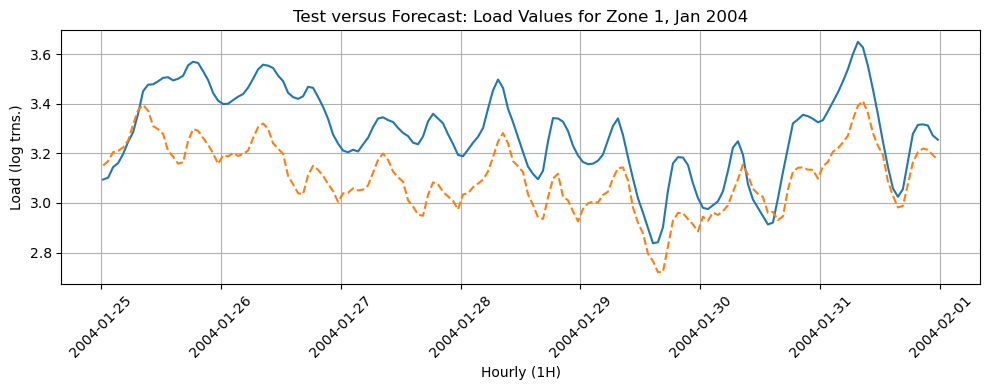

In [58]:
# Predicting 24*7 steps ahead
forecast_jan04 = SARIMA_model_fit.get_forecast(
    steps=24*7, 
    exog = load_long_z1_2004_jan_test[["HDK", "CDK", "const", "trend", "holiday", "sin(1,24)", "cos(1,24)", "sin(2,24)", "cos(2,24)"]].asfreq('h')
).predicted_mean

# Fit on the test data
import seaborn as sns
fig, ax = plt.subplots(figsize=(10, 4))
sns.lineplot(data=load_long_z1_2004_jan_test, x=load_long_z1_2004_jan_test.index, y=load_long_z1_2004_jan_test["log_load_rs"].asfreq('h'), ax=ax)
sns.lineplot(forecast_jan04, linestyle = '--')
ax.set_title("Test versus Forecast: Load Values for Zone 1, Jan 2004")
ax.set_xlabel("Hourly (1H)")
ax.set_ylabel("Load (log trns.)")
ax.grid(True)
ax.tick_params(axis="x", rotation=45)

plt.tight_layout()
plt.show()

In [59]:
# Performance on test set

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
print(f"R2 score: {r2_score(load_long_z1_2004_jan_test.log_load_rs, forecast_jan04)}")
print(f'MSE score: {mean_squared_error(load_long_z1_2004_jan_test.log_load_rs, forecast_jan04)}')
print(f'MAE score: {mean_absolute_error(load_long_z1_2004_jan_test.log_load_rs, forecast_jan04)}')
print(f'MAPE score: {mean_absolute_percentage_error(load_long_z1_2004_jan_test.log_load_rs, forecast_jan04)}')

R2 score: -0.35606989956973933
MSE score: 0.04141646204830961
MAE score: 0.18406754823108307
MAPE score: 0.0553097767110638


- Performance detoriated after allowing for seasonal differencing.
- Harmonics were probably capturing seasonal variation better.

##### Testing on Last Week of Apr 2004 (Zone 1)
Last week of Apr 2004 is used for testing. Multiple SARIMAX models are evaluated and compared. 

In [60]:
# Comparing models - auto_arima 

smodel_apr = pm.auto_arima(y = load_long_z1_2004_apr_train["log_load_rs"].asfreq('h'), 
                           X = load_long_z1_2004_apr_train[["HDK", "CDK", "const", "trend", "holiday", "sin(1,24)", "cos(1,24)", "sin(2,24)", "cos(2,24)"]].asfreq('h'),
                           start_p=0, start_q=0,test='adf',
                           max_p=3, max_q=3, m=24,
                           start_P=0, start_Q=0, max_P=2, max_Q=2, seasonal=True,
                           d=0, D=1, trace=True,
                           error_action='trace',  
                           suppress_warnings=True, 
                           stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[24] intercept   : AIC=inf, Time=nan sec
 ARIMA(1,0,0)(1,1,0)[24] intercept   : AIC=inf, Time=nan sec
 ARIMA(0,0,1)(0,1,1)[24] intercept   : AIC=inf, Time=nan sec


C:\Users\singh\anaconda3\Lib\site-packages\pmdarima\arima\_auto_solvers.py:524: ModelFitWarning: Error fitting  ARIMA(0,0,0)(0,1,0)[24] intercept (if you do not want to see these warnings, run with error_action="ignore").
Traceback:
Traceback (most recent call last):
  File "C:\Users\singh\anaconda3\Lib\site-packages\pmdarima\arima\_auto_solvers.py", line 508, in _fit_candidate_model
    fit.fit(y, X=X, **fit_params)
  File "C:\Users\singh\anaconda3\Lib\site-packages\pmdarima\arima\arima.py", line 603, in fit
    self._fit(y, X, **fit_args)
  File "C:\Users\singh\anaconda3\Lib\site-packages\pmdarima\arima\arima.py", line 524, in _fit
    fit, self.arima_res_ = _fit_wrapper()
                           ^^^^^^^^^^^^^^
  File "C:\Users\singh\anaconda3\Lib\site-packages\pmdarima\arima\arima.py", line 489, in _fit_wrapper
    arima = sm.tsa.statespace.SARIMAX(
            ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\singh\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py", li

 ARIMA(0,0,0)(0,1,0)[24]             : AIC=-825.371, Time=3.53 sec
 ARIMA(0,0,0)(1,1,0)[24] intercept   : AIC=inf, Time=nan sec
 ARIMA(0,0,0)(0,1,1)[24] intercept   : AIC=inf, Time=nan sec
 ARIMA(0,0,0)(1,1,1)[24] intercept   : AIC=inf, Time=nan sec
 ARIMA(1,0,0)(0,1,0)[24] intercept   : AIC=inf, Time=nan sec
 ARIMA(0,0,1)(0,1,0)[24] intercept   : AIC=inf, Time=nan sec
 ARIMA(1,0,1)(0,1,0)[24] intercept   : AIC=inf, Time=nan sec

Best model:  ARIMA(0,0,0)(0,1,0)[24]          
Total fit time: 3.546 seconds


C:\Users\singh\anaconda3\Lib\site-packages\pmdarima\arima\_auto_solvers.py:524: ModelFitWarning: Error fitting  ARIMA(0,0,0)(1,1,0)[24] intercept (if you do not want to see these warnings, run with error_action="ignore").
Traceback:
Traceback (most recent call last):
  File "C:\Users\singh\anaconda3\Lib\site-packages\pmdarima\arima\_auto_solvers.py", line 508, in _fit_candidate_model
    fit.fit(y, X=X, **fit_params)
  File "C:\Users\singh\anaconda3\Lib\site-packages\pmdarima\arima\arima.py", line 603, in fit
    self._fit(y, X, **fit_args)
  File "C:\Users\singh\anaconda3\Lib\site-packages\pmdarima\arima\arima.py", line 524, in _fit
    fit, self.arima_res_ = _fit_wrapper()
                           ^^^^^^^^^^^^^^
  File "C:\Users\singh\anaconda3\Lib\site-packages\pmdarima\arima\arima.py", line 489, in _fit_wrapper
    arima = sm.tsa.statespace.SARIMAX(
            ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\singh\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py", li

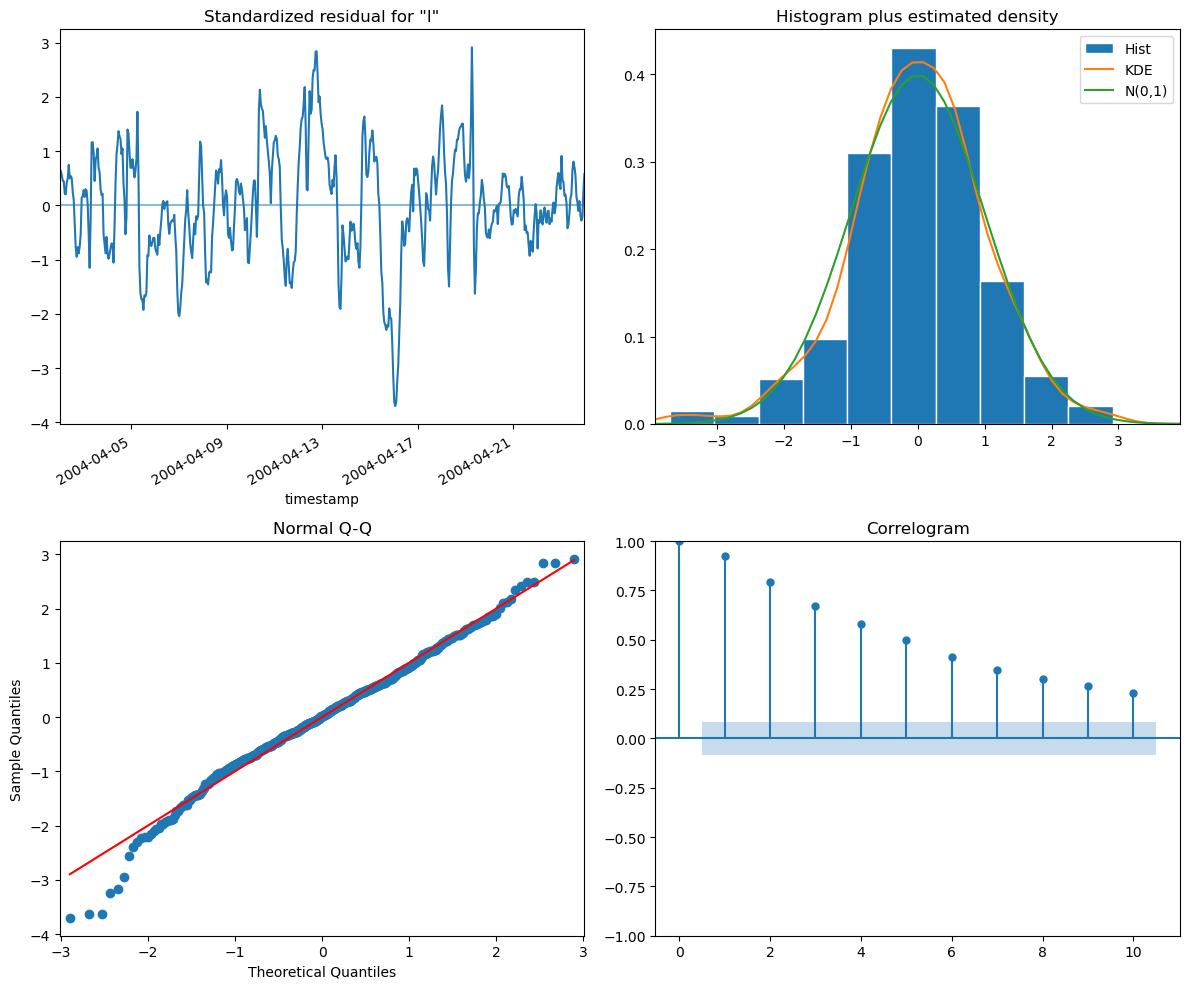

In [61]:
# Diagnostics for (0,0,0,0)) 

import statsmodels.api as sm
SARIMA_model = sm.tsa.statespace.SARIMAX(
        endog = load_long_z1_2004_apr_train["log_load_rs"].asfreq('h'), 
        exog = load_long_z1_2004_apr_train[["HDK", "CDK", "const", "trend", "holiday", "sin(1,24)", "cos(1,24)", "sin(2,24)", "cos(2,24)"]].asfreq('h'), 
        order=(0,0,0),  # non-seasonal: with no differencing
        seasonal_order=(0,1,0,24) # seasonal: with seasonal differencing
)

SARIMA_model_fit = SARIMA_model.fit(disp=False, maxiter=600)
SARIMA_model_fit.plot_diagnostics(figsize=(12,10))
plt.tight_layout()
plt.show()

Similar to January, uncaptured correlation exists but residual distribution is fairly Gaussian.

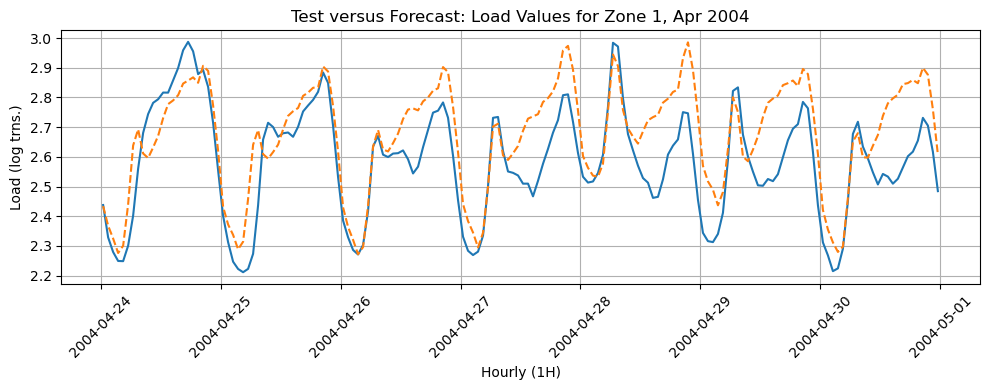

In [62]:
# Predicting 24*7 steps ahead
forecast_apr04 = SARIMA_model_fit.get_forecast(
    steps=24*7, 
    exog = load_long_z1_2004_apr_test[["HDK", "CDK", "const", "trend", "holiday", "sin(1,24)", "cos(1,24)", "sin(2,24)", "cos(2,24)"]].asfreq('h')
).predicted_mean

# Fit on the test data
fig, ax = plt.subplots(figsize=(10, 4))
sns.lineplot(data=load_long_z1_2004_apr_test, x=load_long_z1_2004_apr_test.index, y=load_long_z1_2004_apr_test.log_load_rs.asfreq('h'), ax=ax)
sns.lineplot(forecast_apr04, linestyle = '--')
ax.set_title("Test versus Forecast: Load Values for Zone 1, Apr 2004")
ax.set_xlabel("Hourly (1H)")
ax.set_ylabel("Load (log trns.)")
ax.grid(True)
ax.tick_params(axis="x", rotation=45)

plt.tight_layout()
plt.show()

In [63]:
# Performance on test set

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
print(f"R2 score: {r2_score(load_long_z1_2004_apr_test.log_load_rs, forecast_apr04)}")
print(f'MSE score: {mean_squared_error(load_long_z1_2004_apr_test.log_load_rs, forecast_apr04)}')
print(f'MAE score: {mean_absolute_error(load_long_z1_2004_apr_test.log_load_rs, forecast_apr04)}')
print(f'MAPE score: {mean_absolute_percentage_error(load_long_z1_2004_apr_test.log_load_rs, forecast_apr04)}')

R2 score: 0.4266305566090054
MSE score: 0.019612723678801142
MAE score: 0.11219210357424535
MAPE score: 0.04389748496936977


Performance again detoriated, compared to case where D=0.

##### Testing on Last Week of Jul 2004 (Zone 1)
Last week of Jul 2004 is used for testing. Multiple SARIMAX models are evaluated and compared. 

In [64]:
# Comparing models - auto_arima 

smodel_jul = pm.auto_arima(y = load_long_z1_2004_jul_train["log_load_rs"].asfreq('h'), 
                           X = load_long_z1_2004_jul_train[["HDK", "CDK", "const", "trend", "holiday", "sin(1,24)", "cos(1,24)", "sin(2,24)", "cos(2,24)"]].asfreq('h'),
                           start_p=0, start_q=0,test='adf',
                           max_p=3, max_q=3, m=24,
                           start_P=0, start_Q=0, max_P=2, max_Q=2, seasonal=True,
                           d=0, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[24] intercept   : AIC=inf, Time=nan sec
 ARIMA(1,0,0)(1,1,0)[24] intercept   : AIC=inf, Time=nan sec
 ARIMA(0,0,1)(0,1,1)[24] intercept   : AIC=inf, Time=nan sec
 ARIMA(0,0,0)(0,1,0)[24]             : AIC=-955.338, Time=3.72 sec
 ARIMA(0,0,0)(1,1,0)[24] intercept   : AIC=inf, Time=nan sec
 ARIMA(0,0,0)(0,1,1)[24] intercept   : AIC=inf, Time=nan sec
 ARIMA(0,0,0)(1,1,1)[24] intercept   : AIC=inf, Time=nan sec
 ARIMA(1,0,0)(0,1,0)[24] intercept   : AIC=inf, Time=nan sec
 ARIMA(0,0,1)(0,1,0)[24] intercept   : AIC=inf, Time=nan sec
 ARIMA(1,0,1)(0,1,0)[24] intercept   : AIC=inf, Time=nan sec

Best model:  ARIMA(0,0,0)(0,1,0)[24]          
Total fit time: 3.739 seconds


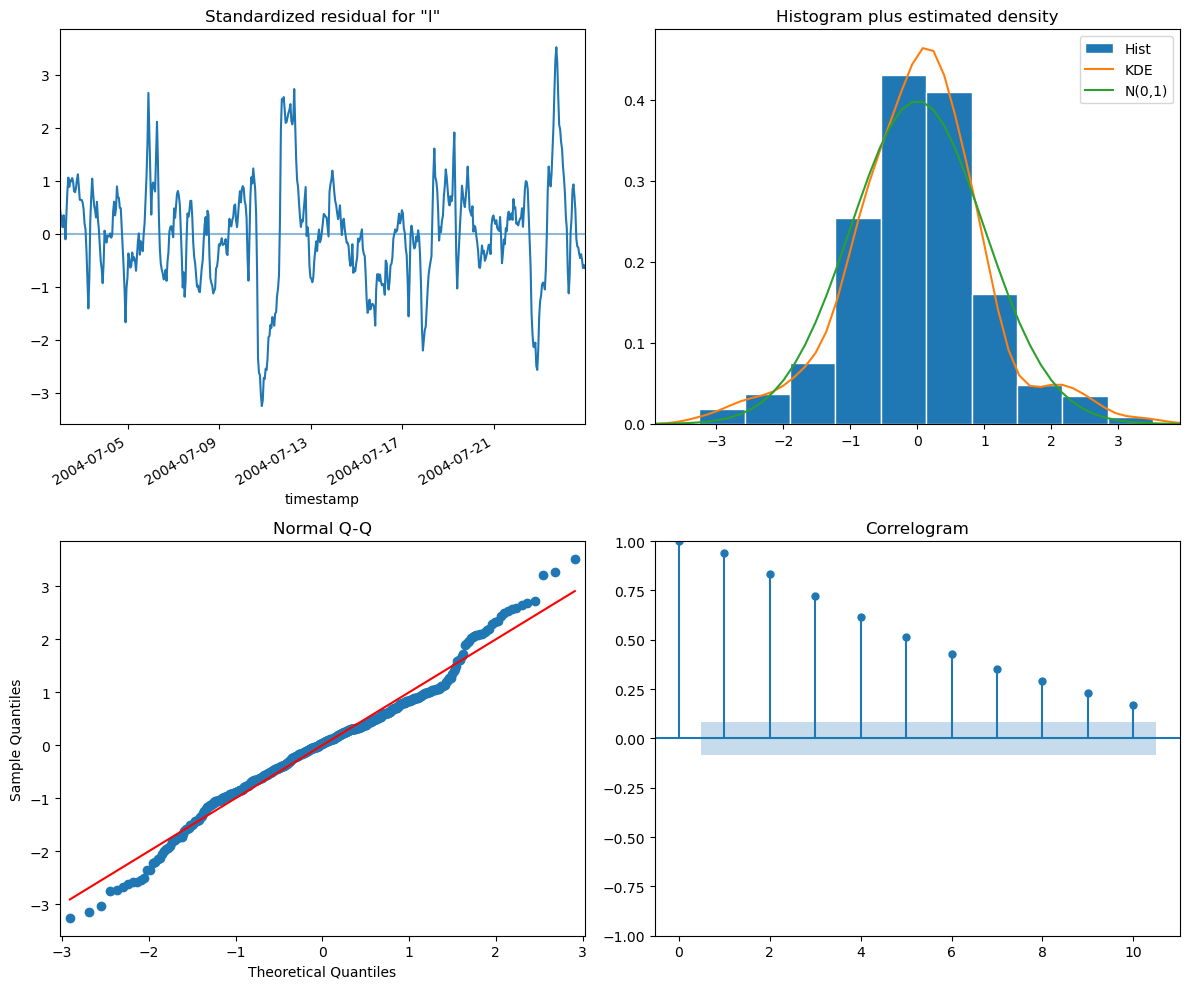

In [65]:
# Diagnostics for (0,0,0,0)) 

SARIMA_model = sm.tsa.statespace.SARIMAX(
        endog = load_long_z1_2004_jul_train["log_load_rs"].asfreq('h'), 
        exog = load_long_z1_2004_jul_train[["HDK", "CDK", "const", "trend", "holiday", "sin(1,24)", "cos(1,24)", "sin(2,24)", "cos(2,24)"]].asfreq('h'), 
        order=(0,0,0),  # non-seasonal: with no differencing
        seasonal_order=(0,1,0,24) # seasonal: with seasonal differencing
        )

SARIMA_model_fit = SARIMA_model.fit(disp=False, maxiter=500)
SARIMA_model_fit.plot_diagnostics(figsize=(12,10))
plt.tight_layout()
plt.show()

Residual dist is closely Gaussian, though autocorrelation isn't strongly captured.

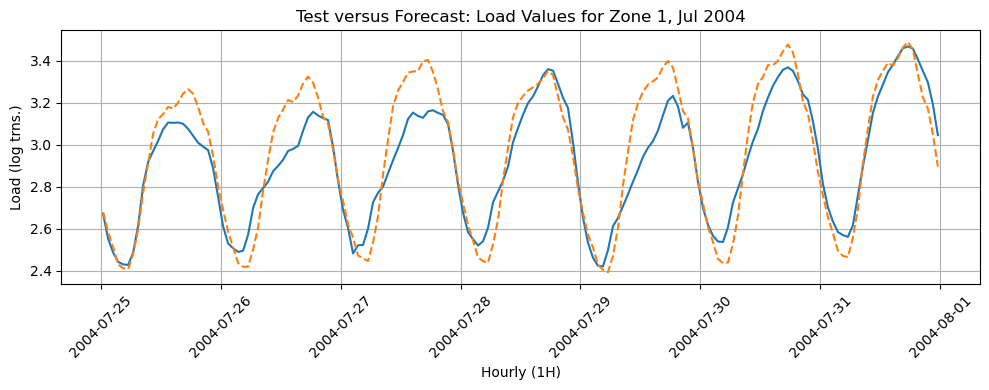

In [66]:
# Predicting 24*7 steps ahead
forecast_jul04 = SARIMA_model_fit.get_forecast(
    steps=24*7, 
    exog = load_long_z1_2004_jul_test[["HDK", "CDK", "const", "trend", "holiday", "sin(1,24)", "cos(1,24)", "sin(2,24)", "cos(2,24)"]].asfreq('h')
).predicted_mean

# Fit on the test data
fig, ax = plt.subplots(figsize=(10, 4))
sns.lineplot(data=load_long_z1_2004_jul_test, x=load_long_z1_2004_jul_test.index, y=load_long_z1_2004_jul_test.log_load_rs.asfreq('h'), ax=ax)
sns.lineplot(forecast_jul04, linestyle = '--')
ax.set_title("Test versus Forecast: Load Values for Zone 1, Jul 2004")
ax.set_xlabel("Hourly (1H)")
ax.set_ylabel("Load (log trns.)")
ax.grid(True)
ax.tick_params(axis="x", rotation=45)

plt.tight_layout()
plt.show()

In [67]:
# Performance on test set

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
print(f"R2 score: {r2_score(load_long_z1_2004_jul_test.log_load_rs, forecast_jul04)}")
print(f'MSE score: {mean_squared_error(load_long_z1_2004_jul_test.log_load_rs, forecast_jul04)}')
print(f'MAE score: {mean_absolute_error(load_long_z1_2004_jul_test.log_load_rs, forecast_jul04)}')
print(f'MAPE score: {mean_absolute_percentage_error(load_long_z1_2004_jul_test.log_load_rs, forecast_jul04)}')

R2 score: 0.7939340390374512
MSE score: 0.016274211356651705
MAE score: 0.09896430525964346
MAPE score: 0.03371769967868951


Performance is same as with D=0.

##### Testing on Last Week of Oct 2004 (Zone 1)
Last week of Oct 2004 is used for testing. Multiple SARIMAX models are evaluated and compared. 

In [68]:
# Comparing models - auto_arima 

smodel_oct = pm.auto_arima(y = load_long_z1_2004_oct_train["log_load_rs"].asfreq('h'), 
                           X = load_long_z1_2004_oct_train[["HDK", "CDK", "const", "trend", "holiday", "sin(1,24)", "cos(1,24)", "sin(2,24)", "cos(2,24)"]].asfreq('h'),
                           start_p=0, start_q=0,test='adf',
                           max_p=3, max_q=3, m=24,
                           start_P=0, start_Q=0, max_P=2, max_Q=2, seasonal=True,
                           d=0, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[24] intercept   : AIC=inf, Time=nan sec
 ARIMA(1,0,0)(1,1,0)[24] intercept   : AIC=inf, Time=nan sec
 ARIMA(0,0,1)(0,1,1)[24] intercept   : AIC=inf, Time=nan sec
 ARIMA(0,0,0)(0,1,0)[24]             : AIC=-1258.759, Time=7.18 sec
 ARIMA(0,0,0)(1,1,0)[24] intercept   : AIC=inf, Time=nan sec
 ARIMA(0,0,0)(0,1,1)[24] intercept   : AIC=inf, Time=nan sec
 ARIMA(0,0,0)(1,1,1)[24] intercept   : AIC=inf, Time=nan sec
 ARIMA(1,0,0)(0,1,0)[24] intercept   : AIC=inf, Time=nan sec
 ARIMA(0,0,1)(0,1,0)[24] intercept   : AIC=inf, Time=nan sec
 ARIMA(1,0,1)(0,1,0)[24] intercept   : AIC=inf, Time=nan sec

Best model:  ARIMA(0,0,0)(0,1,0)[24]          
Total fit time: 7.195 seconds


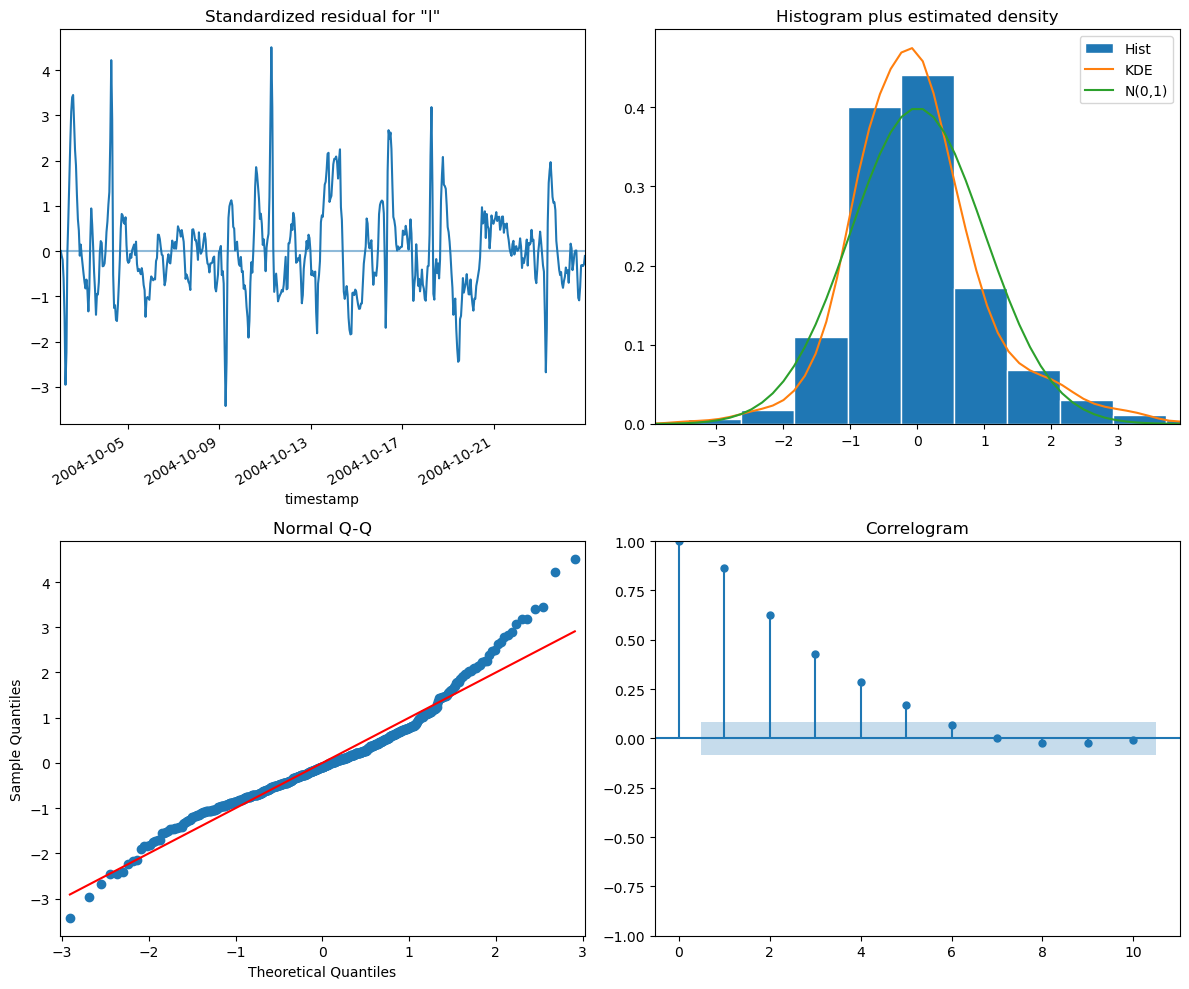

In [69]:
# Diagnostics for (0,0,0,0)

SARIMA_model = sm.tsa.statespace.SARIMAX(
        endog = load_long_z1_2004_oct_train["log_load_rs"].asfreq('h'), 
        exog = load_long_z1_2004_oct_train[["HDK", "CDK", "const", "trend", "holiday", "sin(1,24)", "cos(1,24)", "sin(2,24)", "cos(2,24)"]].asfreq('h'), 
        order=(0,0,0),  # non-seasonal: with no differencing
        seasonal_order=(0,1,0,24) # seasonal: with seasonal differencing
        )

SARIMA_model_fit = SARIMA_model.fit(disp=False, maxiter=500)
SARIMA_model_fit.plot_diagnostics(figsize=(12,10))
plt.tight_layout()
plt.show()

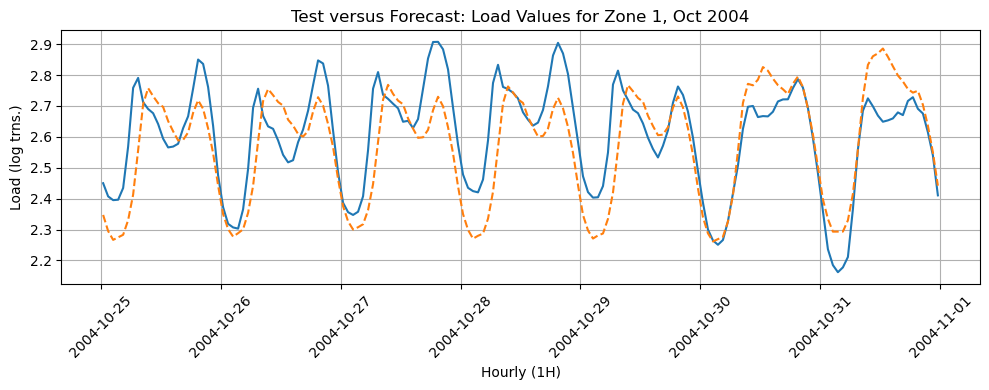

In [70]:
# Predicting 24*7 steps ahead
forecast_oct04 = SARIMA_model_fit.get_forecast(
    steps=24*7, 
    exog = load_long_z1_2004_oct_test[["HDK", "CDK", "const", "trend", "holiday", "sin(1,24)", "cos(1,24)", "sin(2,24)", "cos(2,24)"]].asfreq('h')
).predicted_mean

# Fit on the test data
fig, ax = plt.subplots(figsize=(10, 4))
sns.lineplot(data=load_long_z1_2004_oct_test, x=load_long_z1_2004_oct_test.index, y=load_long_z1_2004_oct_test.log_load_rs.asfreq('h'), ax=ax)
sns.lineplot(forecast_oct04, linestyle = '--')
ax.set_title("Test versus Forecast: Load Values for Zone 1, Oct 2004")
ax.set_xlabel("Hourly (1H)")
ax.set_ylabel("Load (log trns.)")
ax.grid(True)
ax.tick_params(axis="x", rotation=45)

plt.tight_layout()
plt.show()

In [71]:
# Performance on test set

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
print(f"R2 score: {r2_score(load_long_z1_2004_oct_test.log_load_rs, forecast_oct04)}")
print(f'MSE score: {mean_squared_error(load_long_z1_2004_oct_test.log_load_rs, forecast_oct04)}')
print(f'MAE score: {mean_absolute_error(load_long_z1_2004_oct_test.log_load_rs, forecast_oct04)}')
print(f'MAPE score: {mean_absolute_percentage_error(load_long_z1_2004_oct_test.log_load_rs, forecast_oct04)}')

R2 score: 0.46905598920656566
MSE score: 0.014992561548494307
MAE score: 0.09476322187875215
MAPE score: 0.03601243163316548


Performance detoriated compared to case with D=0.

##### Testing on Last Week of Dec 2004 (Zone 1)
Last week of Dec 2004 is used for testing. Multiple SARIMAX models are evaluated and compared. 

In [72]:
# Comparing models - auto_arima

smodel_dec = pm.auto_arima(y = load_long_z1_2004_dec_train["log_load_rs"].asfreq('h'), 
                           X = load_long_z1_2004_dec_train[["HDK", "CDK", "const", "trend", "holiday", "sin(1,24)", "cos(1,24)", "sin(2,24)", "cos(2,24)"]].asfreq('h'),
                           start_p=0, start_q=0,test='adf',
                           max_p=3, max_q=3, m=24,
                           start_P=0, start_Q=0, max_P=2, max_Q=2, seasonal=True,
                           d=0, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[24] intercept   : AIC=inf, Time=nan sec
 ARIMA(1,0,0)(1,1,0)[24] intercept   : AIC=inf, Time=nan sec
 ARIMA(0,0,1)(0,1,1)[24] intercept   : AIC=inf, Time=nan sec
 ARIMA(0,0,0)(0,1,0)[24]             : AIC=-933.330, Time=3.61 sec
 ARIMA(0,0,0)(1,1,0)[24] intercept   : AIC=inf, Time=nan sec
 ARIMA(0,0,0)(0,1,1)[24] intercept   : AIC=inf, Time=nan sec
 ARIMA(0,0,0)(1,1,1)[24] intercept   : AIC=inf, Time=nan sec
 ARIMA(1,0,0)(0,1,0)[24] intercept   : AIC=inf, Time=nan sec
 ARIMA(0,0,1)(0,1,0)[24] intercept   : AIC=inf, Time=nan sec
 ARIMA(1,0,1)(0,1,0)[24] intercept   : AIC=inf, Time=nan sec

Best model:  ARIMA(0,0,0)(0,1,0)[24]          
Total fit time: 3.622 seconds


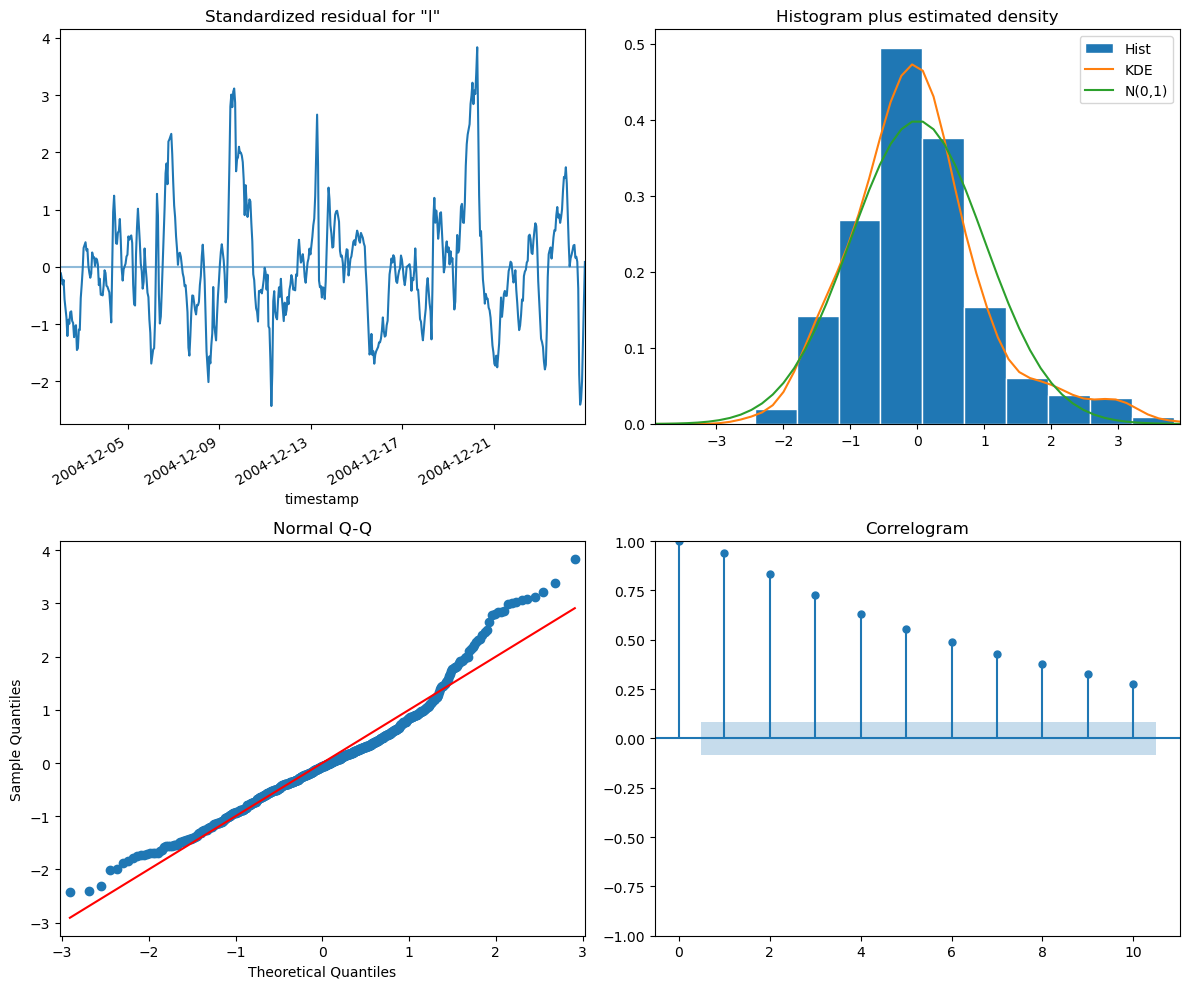

In [73]:
# Diagnostics for (0,0,0,0)

SARIMA_model = sm.tsa.statespace.SARIMAX(
        endog = load_long_z1_2004_dec_train["log_load_rs"].asfreq('h'), 
        exog = load_long_z1_2004_dec_train[["HDK", "CDK", "const", "trend", "holiday", "sin(1,24)", "cos(1,24)", "sin(2,24)", "cos(2,24)"]].asfreq('h'), 
        order=(0,0,0),  # non-seasonal: with no differencing
        seasonal_order=(0,1,0,24) # seasonal: with seasonal differencing
        )

SARIMA_model_fit = SARIMA_model.fit(disp=False, maxiter=500)
SARIMA_model_fit.plot_diagnostics(figsize=(12,10))
plt.tight_layout()
plt.show()

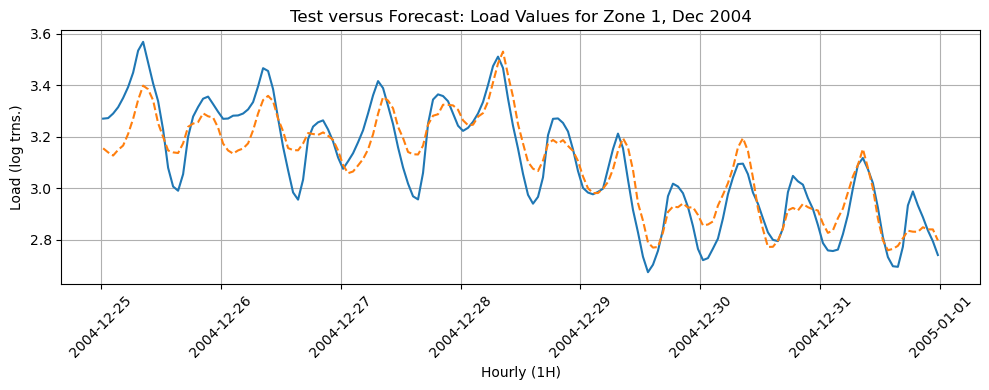

In [74]:
# Predicting 24*7 steps ahead
forecast_dec04 = SARIMA_model_fit.get_forecast(
    steps=24*7, 
    exog = load_long_z1_2004_dec_test[["HDK", "CDK", "const", "trend", "holiday", "sin(1,24)", "cos(1,24)", "sin(2,24)", "cos(2,24)"]].asfreq('h')
).predicted_mean

# Fit on the test data
fig, ax = plt.subplots(figsize=(10, 4))
sns.lineplot(data=load_long_z1_2004_dec_test, x=load_long_z1_2004_dec_test.index, y=load_long_z1_2004_dec_test.log_load_rs.asfreq('h'), ax=ax)
sns.lineplot(forecast_dec04, linestyle = '--')
ax.set_title("Test versus Forecast: Load Values for Zone 1, Dec 2004")
ax.set_xlabel("Hourly (1H)")
ax.set_ylabel("Load (log trns.)")
ax.grid(True)
ax.tick_params(axis="x", rotation=45)

plt.tight_layout()
plt.show()

In [75]:
# Performance on test set

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
print(f"R2 score: {r2_score(load_long_z1_2004_dec_test.log_load_rs, forecast_dec04)}")
print(f'MSE score: {mean_squared_error(load_long_z1_2004_dec_test.log_load_rs, forecast_dec04)}')
print(f'MAE score: {mean_absolute_error(load_long_z1_2004_dec_test.log_load_rs, forecast_dec04)}')
print(f'MAPE score: {mean_absolute_percentage_error(load_long_z1_2004_dec_test.log_load_rs, forecast_dec04)}')

R2 score: 0.8265788777013892
MSE score: 0.008137543589051768
MAE score: 0.07562212934912689
MAPE score: 0.02441569366056841


Performance slightly increased, compared to case with D=0.
> There appears to be no advantage of seasonal differencing since keeping D=0 is offering similar, if not better, performance.

## Removing Fourier Terms with SARIMAX
- The model removes fourier terms, as used in time series regression. This is then combined with SARIMAX, where seasonal AR\MA components are also defined.
- Seasonal differencing is not done.
- Intercept is added using the "const" column

In [142]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Defining a function to check if a series is stationary

def check_stationarity(timeseries):
    result = adfuller(timeseries, autolag='AIC')
    p_value = result[1]
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {p_value}')
    print('Stationary' if p_value < 0.05 else 'Non-Stationary')

##### Testing on Last Week of Jan 2004 (Zone 1)
Last week of Jan 2004 is used for testing. Multiple SARIMAX models are evaluated and compared. 

In [76]:
# Creating training data
load_long_z1_2004_jan_train = mul_df.loc[mul_df.month == 1,:]
load_long_z1_2004_jan_train = load_long_z1_2004_jan_train.set_index("timestamp")
load_long_z1_2004_jan_train = load_long_z1_2004_jan_train[:'2004-01-24 23:30:00']
load_long_z1_2004_jan_train.index = pd.to_datetime(load_long_z1_2004_jan_train.index)
load_long_z1_2004_jan_train.head()

year  month  day   hour  log_load_rs  temp_weighted  \
timestamp                                                                  
2004-01-01 00:30:00  2004      1    1  00:30     2.824529      42.338937   
2004-01-01 01:30:00  2004      1    1  01:30     2.800325      41.239284   
2004-01-01 02:30:00  2004      1    1  02:30     2.804390      39.591442   
2004-01-01 03:30:00  2004      1    1  03:30     2.825715      36.243296   
2004-01-01 04:30:00  2004      1    1  04:30     2.836971      34.600850   

                     holiday        HDK  CDK  const  
timestamp                                            
2004-01-01 00:30:00        1  12.661063  0.0      1  
2004-01-01 01:30:00        1  13.760716  0.0      1  
2004-01-01 02:30:00        1  15.408558  0.0      1  
2004-01-01 03:30:00        1  18.756704  0.0      1  
2004-01-01 04:30:00        1  20.399150  0.0      1

In [77]:
# Adding periodicities
from statsmodels.tsa.deterministic import Fourier
from statsmodels.tsa.deterministic import DeterministicProcess

# Defining the sine wave
dp = DeterministicProcess(
    index=load_long_z1_2004_jan_train.index,
    period=None,         # It's not defined so that frequency can be read from the index
    constant=False,      # defined later
    order=1,             # linear trend not required since seasonal diff made the series stationary
    seasonal=False      # no seasonal dummies
)

trend_df = dp.in_sample()
trend_df.head()

trend
timestamp                 
2004-01-01 00:30:00    1.0
2004-01-01 01:30:00    2.0
2004-01-01 02:30:00    3.0
2004-01-01 03:30:00    4.0
2004-01-01 04:30:00    5.0

In [78]:
# Combining trend with other variables
load_long_z1_2004_jan_train = load_long_z1_2004_jan_train.merge(trend_df, on='timestamp', how='left')
load_long_z1_2004_jan_train.head()

year  month  day   hour  log_load_rs  temp_weighted  \
timestamp                                                                  
2004-01-01 00:30:00  2004      1    1  00:30     2.824529      42.338937   
2004-01-01 01:30:00  2004      1    1  01:30     2.800325      41.239284   
2004-01-01 02:30:00  2004      1    1  02:30     2.804390      39.591442   
2004-01-01 03:30:00  2004      1    1  03:30     2.825715      36.243296   
2004-01-01 04:30:00  2004      1    1  04:30     2.836971      34.600850   

                     holiday        HDK  CDK  const  trend  
timestamp                                                   
2004-01-01 00:30:00        1  12.661063  0.0      1    1.0  
2004-01-01 01:30:00        1  13.760716  0.0      1    2.0  
2004-01-01 02:30:00        1  15.408558  0.0      1    3.0  
2004-01-01 03:30:00        1  18.756704  0.0      1    4.0  
2004-01-01 04:30:00        1  20.399150  0.0      1    5.0

In [81]:
# Comparing models - auto_arima

import pmdarima as pm
smodel_jan = pm.auto_arima(y = load_long_z1_2004_jan_train["log_load_rs"].asfreq('h'), 
                           X = load_long_z1_2004_jan_train[["HDK", "CDK", "holiday","const", "trend"]].asfreq('h'),
                           start_p=0, start_q=0,test='adf',
                           max_p=3, max_q=3, m=24,
                           start_P=0, start_Q=0, max_P=2, max_Q=2, seasonal=True,
                           d=0, D=0, trace=True,
                           error_action='ignore',
                           suppress_warnings=True, 
                           stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[24] intercept   : AIC=inf, Time=nan sec
 ARIMA(1,0,0)(1,0,0)[24] intercept   : AIC=inf, Time=nan sec
 ARIMA(0,0,1)(0,0,1)[24] intercept   : AIC=inf, Time=nan sec
 ARIMA(0,0,0)(0,0,0)[24]             : AIC=-713.296, Time=0.57 sec
 ARIMA(0,0,0)(1,0,0)[24] intercept   : AIC=inf, Time=nan sec
 ARIMA(0,0,0)(0,0,1)[24] intercept   : AIC=inf, Time=nan sec
 ARIMA(0,0,0)(1,0,1)[24] intercept   : AIC=inf, Time=nan sec
 ARIMA(1,0,0)(0,0,0)[24] intercept   : AIC=inf, Time=nan sec
 ARIMA(0,0,1)(0,0,0)[24] intercept   : AIC=inf, Time=nan sec
 ARIMA(1,0,1)(0,0,0)[24] intercept   : AIC=inf, Time=nan sec

Best model:  ARIMA(0,0,0)(0,0,0)[24]          
Total fit time: 0.579 seconds


The order of the seasonal and non-seasonal AR/MA components has now changed, compared to the case of using SARIMAX without external regressors.

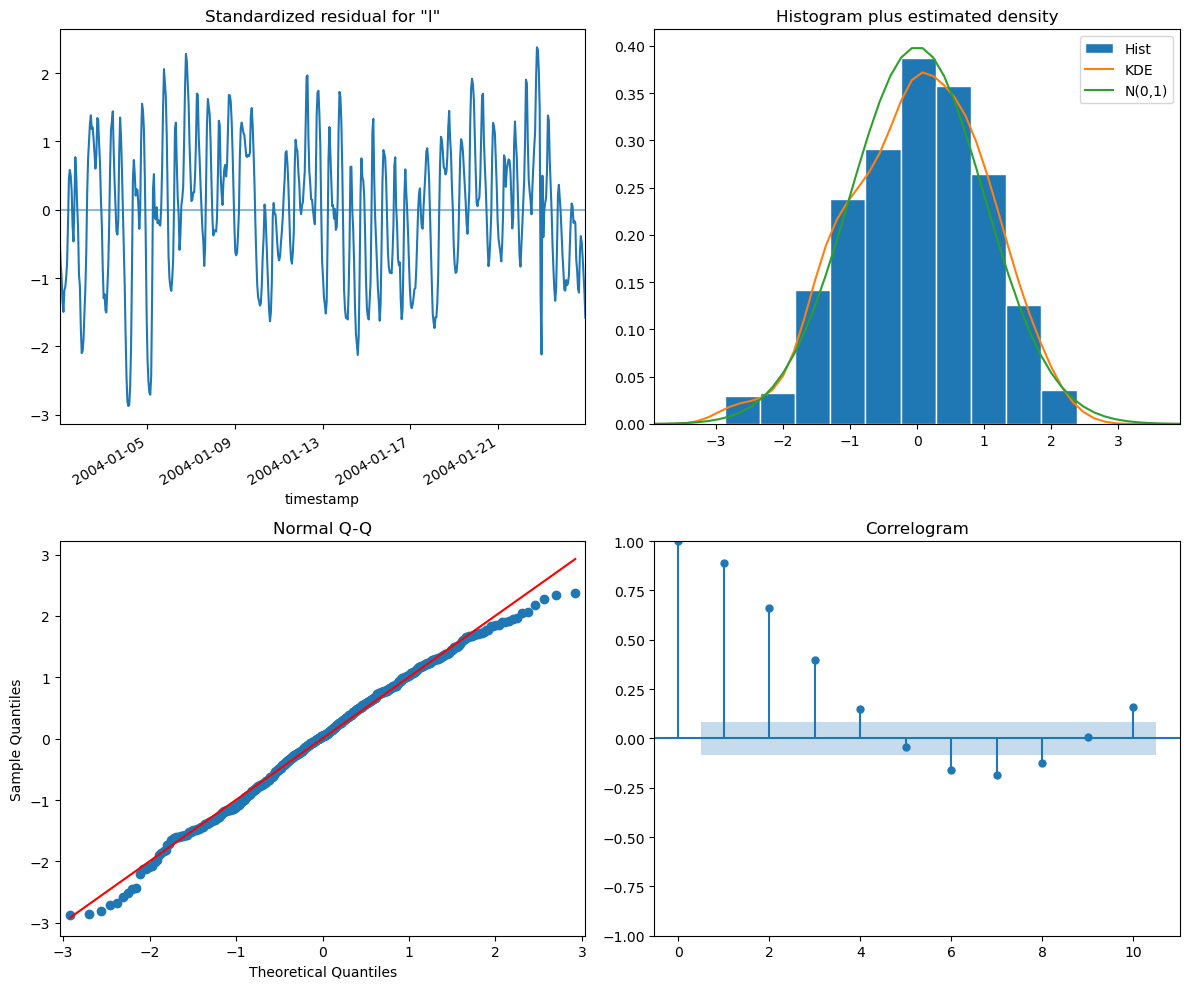

In [141]:
# Diagnostics (for (0,0,0,0))

import statsmodels.api as sm
SARIMA_model = sm.tsa.statespace.SARIMAX(
        endog = load_long_z1_2004_jan_train["log_load_rs"].asfreq('h'), 
        exog = load_long_z1_2004_jan_train[["HDK", "CDK", "holiday","const", "trend"]].asfreq('h'), 
        order=(0,0,0),  # non-seasonal: with no differencing
        seasonal_order=(0,0,0,24) # seasonal: with no seasonal differencing
)

SARIMA_model_fit = SARIMA_model.fit(disp=False, maxiter=500)
SARIMA_model_fit.plot_diagnostics(figsize=(12,10))
plt.tight_layout()
plt.show()

Again, there is uncaptured correlation. Both harmonics and AR/MA components are absent.

In [145]:
# are residuals stationary?
fitted_z1_2004_jan_train = SARIMA_model_fit.predict(start=load_long_z1_2004_jan_train["log_load_rs"].index[0], end=load_long_z1_2004_jan_train["log_load_rs"].index[-1])

check_stationarity(load_long_z1_2004_jan_train["log_load_rs"] - fitted_z1_2004_jan_train)

ADF Statistic: -2.698134820198499
p-value: 0.07436158310346414
Non-Stationary


In [84]:
# Creating test data
load_long_z1_2004_jan_test = mul_df.loc[mul_df.month == 1,:]
load_long_z1_2004_jan_test = load_long_z1_2004_jan_test.set_index("timestamp")
load_long_z1_2004_jan_test = load_long_z1_2004_jan_test['2004-01-25 00:30:00':]
load_long_z1_2004_jan_test.index = pd.to_datetime(load_long_z1_2004_jan_test.index)
load_long_z1_2004_jan_test.head()

year  month  day   hour  log_load_rs  temp_weighted  \
timestamp                                                                  
2004-01-25 00:30:00  2004      1   25  00:30     3.094174      21.155292   
2004-01-25 01:30:00  2004      1   25  01:30     3.101713      20.058817   
2004-01-25 02:30:00  2004      1   25  02:30     3.144626      19.051006   
2004-01-25 03:30:00  2004      1   25  03:30     3.160441      18.246300   
2004-01-25 04:30:00  2004      1   25  04:30     3.197407      17.700175   

                     holiday        HDK  CDK  const  
timestamp                                            
2004-01-25 00:30:00        0  33.844708  0.0      1  
2004-01-25 01:30:00        0  34.941183  0.0      1  
2004-01-25 02:30:00        0  35.948994  0.0      1  
2004-01-25 03:30:00        0  36.753700  0.0      1  
2004-01-25 04:30:00        0  37.299825  0.0      1

In [85]:
# Adding periodicities
from statsmodels.tsa.deterministic import Fourier
from statsmodels.tsa.deterministic import DeterministicProcess

# Defining the sine wave
dp = DeterministicProcess(
    index=load_long_z1_2004_jan_test.index,
    period=None,         # It's not defined so that frequency can be read from the index
    constant=False,      # defined later
    order=1,             # linear trend not required since seasonal diff made the series stationary
    seasonal=False      # no seasonal dummies
)

trend_df = dp.in_sample()

# Combining trend with other variables
load_long_z1_2004_jan_test = load_long_z1_2004_jan_test.merge(trend_df, on='timestamp', how='left')
load_long_z1_2004_jan_test.head()

year  month  day   hour  log_load_rs  temp_weighted  \
timestamp                                                                  
2004-01-25 00:30:00  2004      1   25  00:30     3.094174      21.155292   
2004-01-25 01:30:00  2004      1   25  01:30     3.101713      20.058817   
2004-01-25 02:30:00  2004      1   25  02:30     3.144626      19.051006   
2004-01-25 03:30:00  2004      1   25  03:30     3.160441      18.246300   
2004-01-25 04:30:00  2004      1   25  04:30     3.197407      17.700175   

                     holiday        HDK  CDK  const  trend  
timestamp                                                   
2004-01-25 00:30:00        0  33.844708  0.0      1    1.0  
2004-01-25 01:30:00        0  34.941183  0.0      1    2.0  
2004-01-25 02:30:00        0  35.948994  0.0      1    3.0  
2004-01-25 03:30:00        0  36.753700  0.0      1    4.0  
2004-01-25 04:30:00        0  37.299825  0.0      1    5.0

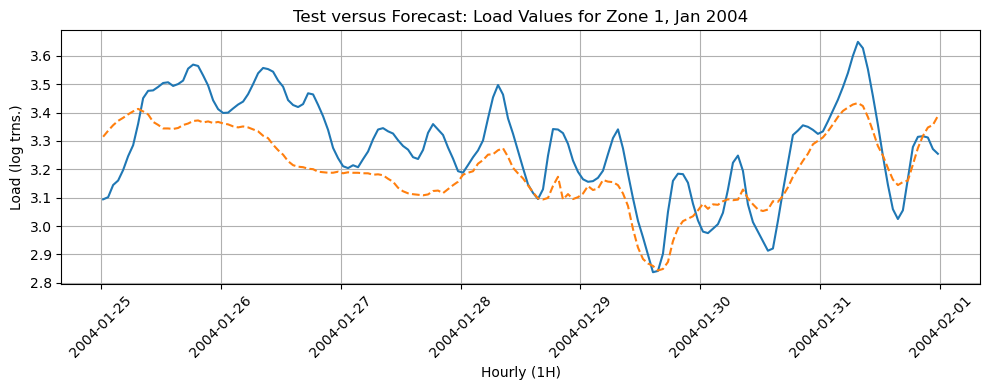

In [86]:
# Predicting 24*7 steps ahead
forecast_jan04 = SARIMA_model_fit.get_forecast(
    steps=24*7, 
    exog = load_long_z1_2004_jan_test[["HDK", "CDK", "holiday","const", "trend"]].asfreq('h')
).predicted_mean

# Fit on the test data
import seaborn as sns
fig, ax = plt.subplots(figsize=(10, 4))
sns.lineplot(data=load_long_z1_2004_jan_test, x=load_long_z1_2004_jan_test.index, y=load_long_z1_2004_jan_test["log_load_rs"].asfreq('h'), ax=ax)
sns.lineplot(forecast_jan04, linestyle = '--')
ax.set_title("Test versus Forecast: Load Values for Zone 1, Jan 2004")
ax.set_xlabel("Hourly (1H)")
ax.set_ylabel("Load (log trns.)")
ax.grid(True)
ax.tick_params(axis="x", rotation=45)

plt.tight_layout()
plt.show()

In [87]:
# Performance on test set

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
print(f"R2 score: {r2_score(load_long_z1_2004_jan_test.log_load_rs, forecast_jan04)}")
print(f'MSE score: {mean_squared_error(load_long_z1_2004_jan_test.log_load_rs, forecast_jan04)}')
print(f'MAE score: {mean_absolute_error(load_long_z1_2004_jan_test.log_load_rs, forecast_jan04)}')
print(f'MAPE score: {mean_absolute_percentage_error(load_long_z1_2004_jan_test.log_load_rs, forecast_jan04)}')

R2 score: 0.38784526852649026
MSE score: 0.018696147751535518
MAE score: 0.11676039120339779
MAPE score: 0.03514686625529846


Even without AR/MA components, performance isn't as bad.

##### Testing on Last Week of Apr 2004 (Zone 1)
Last week of Jan 2004 is used for testing. Multiple SARIMAX models are evaluated and compared. 

In [88]:
# Creating training data
load_long_z1_2004_apr_train = mul_df.loc[mul_df.month == 4,:]
load_long_z1_2004_apr_train = load_long_z1_2004_apr_train.set_index("timestamp")
load_long_z1_2004_apr_train = load_long_z1_2004_apr_train[:'2004-04-23 23:30:00']
load_long_z1_2004_apr_train.index = pd.to_datetime(load_long_z1_2004_apr_train.index)
load_long_z1_2004_apr_train.head()

year  month  day   hour  log_load_rs  temp_weighted  \
timestamp                                                                  
2004-04-01 00:30:00  2004      4    1  00:30     2.645820      45.453562   
2004-04-01 01:30:00  2004      4    1  01:30     2.633901      45.547368   
2004-04-01 02:30:00  2004      4    1  02:30     2.633039      45.454863   
2004-04-01 03:30:00  2004      4    1  03:30     2.646246      45.454863   
2004-04-01 04:30:00  2004      4    1  04:30     2.688528      45.191047   

                     holiday       HDK  CDK  const  
timestamp                                           
2004-04-01 00:30:00        0  9.546438  0.0      1  
2004-04-01 01:30:00        0  9.452632  0.0      1  
2004-04-01 02:30:00        0  9.545137  0.0      1  
2004-04-01 03:30:00        0  9.545137  0.0      1  
2004-04-01 04:30:00        0  9.808953  0.0      1

In [89]:
# Adding periodicities
from statsmodels.tsa.deterministic import Fourier
from statsmodels.tsa.deterministic import DeterministicProcess

# Defining the sine wave
dp = DeterministicProcess(
    index=load_long_z1_2004_apr_train.index,
    period=None,         # It's not defined so that frequency can be read from the index
    constant=False,      # defined later
    order=1,             # linear trend not required since seasonal diff made the series stationary
    seasonal=False      # no seasonal dummies
)

trend_df = dp.in_sample()

# Combining trend with other variables
load_long_z1_2004_apr_train = load_long_z1_2004_apr_train.merge(trend_df, on='timestamp', how='left')
load_long_z1_2004_apr_train.head()

year  month  day   hour  log_load_rs  temp_weighted  \
timestamp                                                                  
2004-04-01 00:30:00  2004      4    1  00:30     2.645820      45.453562   
2004-04-01 01:30:00  2004      4    1  01:30     2.633901      45.547368   
2004-04-01 02:30:00  2004      4    1  02:30     2.633039      45.454863   
2004-04-01 03:30:00  2004      4    1  03:30     2.646246      45.454863   
2004-04-01 04:30:00  2004      4    1  04:30     2.688528      45.191047   

                     holiday       HDK  CDK  const  trend  
timestamp                                                  
2004-04-01 00:30:00        0  9.546438  0.0      1    1.0  
2004-04-01 01:30:00        0  9.452632  0.0      1    2.0  
2004-04-01 02:30:00        0  9.545137  0.0      1    3.0  
2004-04-01 03:30:00        0  9.545137  0.0      1    4.0  
2004-04-01 04:30:00        0  9.808953  0.0      1    5.0

In [90]:
# Comparing models - auto_arima

import pmdarima as pm
smodel_jan = pm.auto_arima(y = load_long_z1_2004_apr_train["log_load_rs"].asfreq('h'), 
                           X = load_long_z1_2004_apr_train[["HDK", "CDK", "holiday","const", "trend"]].asfreq('h'),
                           start_p=0, start_q=0,test='adf',
                           max_p=3, max_q=3, m=24,
                           start_P=0, start_Q=0, max_P=2, max_Q=2, seasonal=True,
                           d=0, D=0, trace=True,
                           error_action='ignore',
                           suppress_warnings=True, 
                           stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[24] intercept   : AIC=inf, Time=nan sec
 ARIMA(1,0,0)(1,0,0)[24] intercept   : AIC=inf, Time=nan sec
 ARIMA(0,0,1)(0,0,1)[24] intercept   : AIC=inf, Time=nan sec
 ARIMA(0,0,0)(0,0,0)[24]             : AIC=-332.420, Time=0.84 sec
 ARIMA(0,0,0)(1,0,0)[24] intercept   : AIC=inf, Time=nan sec
 ARIMA(0,0,0)(0,0,1)[24] intercept   : AIC=inf, Time=nan sec
 ARIMA(0,0,0)(1,0,1)[24] intercept   : AIC=inf, Time=nan sec
 ARIMA(1,0,0)(0,0,0)[24] intercept   : AIC=inf, Time=nan sec
 ARIMA(0,0,1)(0,0,0)[24] intercept   : AIC=inf, Time=nan sec
 ARIMA(1,0,1)(0,0,0)[24] intercept   : AIC=inf, Time=nan sec

Best model:  ARIMA(0,0,0)(0,0,0)[24]          
Total fit time: 0.861 seconds


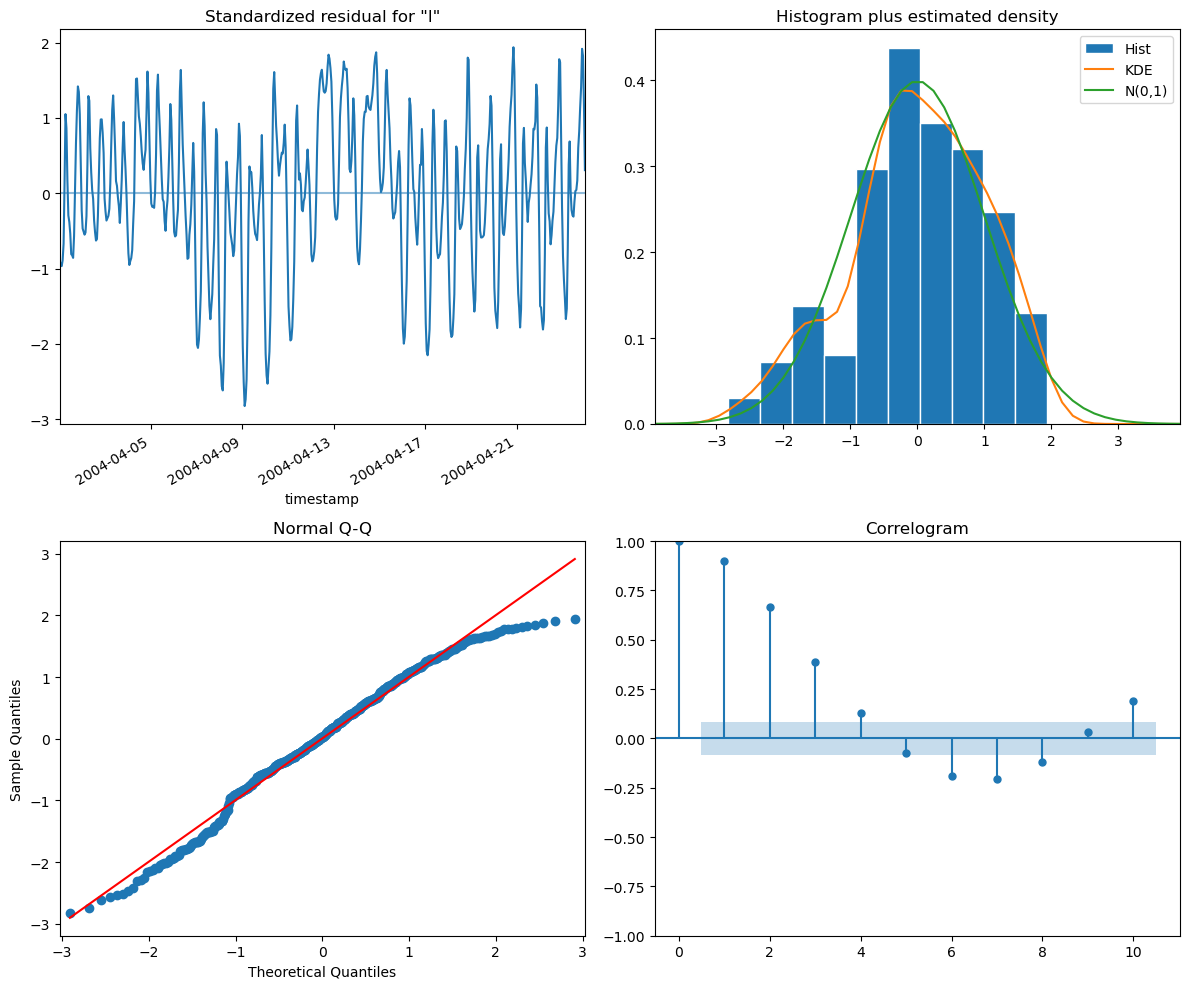

In [146]:
# Diagnostics (for (0,0,0,0))

import statsmodels.api as sm
SARIMA_model = sm.tsa.statespace.SARIMAX(
        endog = load_long_z1_2004_apr_train["log_load_rs"].asfreq('h'), 
        exog = load_long_z1_2004_apr_train[["HDK", "CDK", "holiday","const", "trend"]].asfreq('h'), 
        order=(0,0,0),  # non-seasonal: with no differencing
        seasonal_order=(0,0,0,24) # seasonal: with no seasonal differencing
)

SARIMA_model_fit = SARIMA_model.fit(disp=False, maxiter=500)
SARIMA_model_fit.plot_diagnostics(figsize=(12,10))
plt.tight_layout()
plt.show()

Again, there is uncaptured correlation. Both harmonics and AR/MA components are absent.

In [147]:
# are residuals stationary?
fitted_z1_2004_apr_train = SARIMA_model_fit.predict(start=load_long_z1_2004_apr_train["log_load_rs"].index[0], end=load_long_z1_2004_apr_train["log_load_rs"].index[-1])

check_stationarity(load_long_z1_2004_apr_train["log_load_rs"] - fitted_z1_2004_apr_train)

ADF Statistic: -2.4527387293667955
p-value: 0.1274008972156747
Non-Stationary


In [92]:
# Creating test data
load_long_z1_2004_apr_test = mul_df.loc[mul_df.month == 4,:]
load_long_z1_2004_apr_test = load_long_z1_2004_apr_test.set_index("timestamp")
load_long_z1_2004_apr_test = load_long_z1_2004_apr_test['2004-04-24 00:30:00':]
load_long_z1_2004_apr_test.index = pd.to_datetime(load_long_z1_2004_apr_test.index)
load_long_z1_2004_apr_test.head()

year  month  day   hour  log_load_rs  temp_weighted  \
timestamp                                                                  
2004-04-24 00:30:00  2004      4   24  00:30     2.437728      62.266565   
2004-04-24 01:30:00  2004      4   24  01:30     2.328643      62.708075   
2004-04-24 02:30:00  2004      4   24  02:30     2.279316      61.449205   
2004-04-24 03:30:00  2004      4   24  03:30     2.249290      60.634717   
2004-04-24 04:30:00  2004      4   24  04:30     2.248657      59.824237   

                     holiday  HDK  CDK  const  
timestamp                                      
2004-04-24 00:30:00        0  0.0  0.0      1  
2004-04-24 01:30:00        0  0.0  0.0      1  
2004-04-24 02:30:00        0  0.0  0.0      1  
2004-04-24 03:30:00        0  0.0  0.0      1  
2004-04-24 04:30:00        0  0.0  0.0      1

In [93]:
# Adding periodicities
from statsmodels.tsa.deterministic import Fourier
from statsmodels.tsa.deterministic import DeterministicProcess

# Defining the sine wave
dp = DeterministicProcess(
    index=load_long_z1_2004_apr_test.index,
    period=None,         # It's not defined so that frequency can be read from the index
    constant=False,      # defined later
    order=1,             # linear trend not required since seasonal diff made the series stationary
    seasonal=False      # no seasonal dummies
)

trend_df = dp.in_sample()

# Combining trend with other variables
load_long_z1_2004_apr_test = load_long_z1_2004_apr_test.merge(trend_df, on='timestamp', how='left')
load_long_z1_2004_apr_test.head()

year  month  day   hour  log_load_rs  temp_weighted  \
timestamp                                                                  
2004-04-24 00:30:00  2004      4   24  00:30     2.437728      62.266565   
2004-04-24 01:30:00  2004      4   24  01:30     2.328643      62.708075   
2004-04-24 02:30:00  2004      4   24  02:30     2.279316      61.449205   
2004-04-24 03:30:00  2004      4   24  03:30     2.249290      60.634717   
2004-04-24 04:30:00  2004      4   24  04:30     2.248657      59.824237   

                     holiday  HDK  CDK  const  trend  
timestamp                                             
2004-04-24 00:30:00        0  0.0  0.0      1    1.0  
2004-04-24 01:30:00        0  0.0  0.0      1    2.0  
2004-04-24 02:30:00        0  0.0  0.0      1    3.0  
2004-04-24 03:30:00        0  0.0  0.0      1    4.0  
2004-04-24 04:30:00        0  0.0  0.0      1    5.0

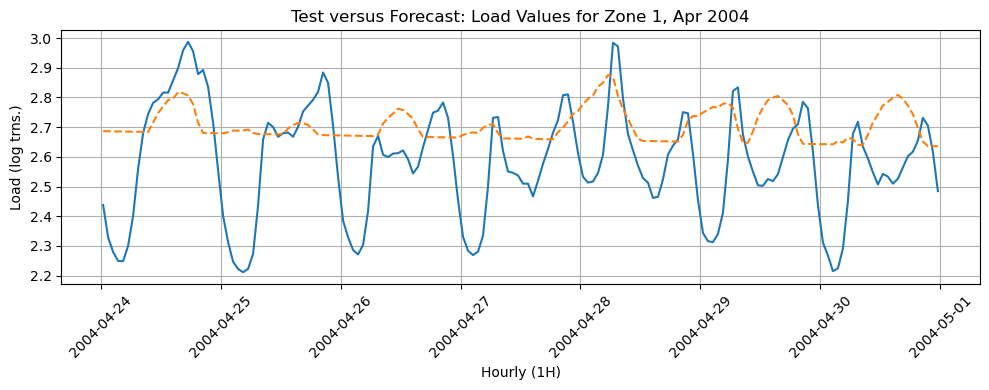

In [94]:
# Predicting 24*7 steps ahead
forecast_apr04 = SARIMA_model_fit.get_forecast(
    steps=24*7, 
    exog = load_long_z1_2004_apr_test[["HDK", "CDK", "holiday","const", "trend"]].asfreq('h')
).predicted_mean

# Fit on the test data
import seaborn as sns
fig, ax = plt.subplots(figsize=(10, 4))
sns.lineplot(data=load_long_z1_2004_apr_test, x=load_long_z1_2004_apr_test.index, y=load_long_z1_2004_apr_test["log_load_rs"].asfreq('h'), ax=ax)
sns.lineplot(forecast_apr04, linestyle = '--')
ax.set_title("Test versus Forecast: Load Values for Zone 1, Apr 2004")
ax.set_xlabel("Hourly (1H)")
ax.set_ylabel("Load (log trns.)")
ax.grid(True)
ax.tick_params(axis="x", rotation=45)

plt.tight_layout()
plt.show()

In [95]:
# Performance on test set

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
print(f"R2 score: {r2_score(load_long_z1_2004_apr_test.log_load_rs, forecast_apr04)}")
print(f'MSE score: {mean_squared_error(load_long_z1_2004_apr_test.log_load_rs, forecast_apr04)}')
print(f'MAE score: {mean_absolute_error(load_long_z1_2004_apr_test.log_load_rs, forecast_apr04)}')
print(f'MAPE score: {mean_absolute_percentage_error(load_long_z1_2004_apr_test.log_load_rs, forecast_apr04)}')

R2 score: -0.3867601287268523
MSE score: 0.04743563426164547
MAE score: 0.17271329060624666
MAPE score: 0.07034246015626146


Now the performance has considerable detoriated.

##### Testing on Last Week of Jul 2004 (Zone 1)
Last week of Jul 2004 is used for testing. Multiple SARIMAX models are evaluated and compared. 

In [96]:
# Creating training data
load_long_z1_2004_jul_train = mul_df.loc[mul_df.month == 7,:]
load_long_z1_2004_jul_train = load_long_z1_2004_jul_train.set_index("timestamp")
load_long_z1_2004_jul_train = load_long_z1_2004_jul_train[:'2004-07-24 23:30:00']
load_long_z1_2004_jul_train.index = pd.to_datetime(load_long_z1_2004_jul_train.index)
load_long_z1_2004_jul_train.head()

year  month  day   hour  log_load_rs  temp_weighted  \
timestamp                                                                  
2004-07-01 00:30:00  2004      7    1  00:30     2.658230      67.152732   
2004-07-01 01:30:00  2004      7    1  01:30     2.548507      66.148285   
2004-07-01 02:30:00  2004      7    1  02:30     2.482404      65.687669   
2004-07-01 03:30:00  2004      7    1  03:30     2.447464      64.515455   
2004-07-01 04:30:00  2004      7    1  04:30     2.430626      64.517938   

                     holiday  HDK       CDK  const  
timestamp                                           
2004-07-01 00:30:00        0  0.0  2.152732      1  
2004-07-01 01:30:00        0  0.0  1.148285      1  
2004-07-01 02:30:00        0  0.0  0.687669      1  
2004-07-01 03:30:00        0  0.0  0.000000      1  
2004-07-01 04:30:00        0  0.0  0.000000      1

In [97]:
# Adding periodicities
from statsmodels.tsa.deterministic import Fourier
from statsmodels.tsa.deterministic import DeterministicProcess

# Defining the sine wave
dp = DeterministicProcess(
    index=load_long_z1_2004_jul_train.index,
    period=None,         # It's not defined so that frequency can be read from the index
    constant=False,      # defined later
    order=1,             # linear trend not required since seasonal diff made the series stationary
    seasonal=False      # no seasonal dummies
)

trend_df = dp.in_sample()

# Combining trend with other variables
load_long_z1_2004_jul_train = load_long_z1_2004_jul_train.merge(trend_df, on='timestamp', how='left')
load_long_z1_2004_jul_train.head()

year  month  day   hour  log_load_rs  temp_weighted  \
timestamp                                                                  
2004-07-01 00:30:00  2004      7    1  00:30     2.658230      67.152732   
2004-07-01 01:30:00  2004      7    1  01:30     2.548507      66.148285   
2004-07-01 02:30:00  2004      7    1  02:30     2.482404      65.687669   
2004-07-01 03:30:00  2004      7    1  03:30     2.447464      64.515455   
2004-07-01 04:30:00  2004      7    1  04:30     2.430626      64.517938   

                     holiday  HDK       CDK  const  trend  
timestamp                                                  
2004-07-01 00:30:00        0  0.0  2.152732      1    1.0  
2004-07-01 01:30:00        0  0.0  1.148285      1    2.0  
2004-07-01 02:30:00        0  0.0  0.687669      1    3.0  
2004-07-01 03:30:00        0  0.0  0.000000      1    4.0  
2004-07-01 04:30:00        0  0.0  0.000000      1    5.0

In [98]:
# Comparing models - auto_arima

import pmdarima as pm
smodel_jul = pm.auto_arima(y = load_long_z1_2004_jul_train["log_load_rs"].asfreq('h'), 
                           X = load_long_z1_2004_jul_train[["HDK", "CDK", "holiday","const", "trend"]].asfreq('h'),
                           start_p=0, start_q=0,test='adf',
                           max_p=3, max_q=3, m=24,
                           start_P=0, start_Q=0, max_P=2, max_Q=2, seasonal=True,
                           d=0, D=0, trace=True,
                           error_action='ignore',
                           suppress_warnings=True, 
                           stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[24] intercept   : AIC=inf, Time=nan sec
 ARIMA(1,0,0)(1,0,0)[24] intercept   : AIC=inf, Time=nan sec
 ARIMA(0,0,1)(0,0,1)[24] intercept   : AIC=inf, Time=nan sec
 ARIMA(0,0,0)(0,0,0)[24]             : AIC=-335.856, Time=0.58 sec
 ARIMA(0,0,0)(1,0,0)[24] intercept   : AIC=inf, Time=nan sec
 ARIMA(0,0,0)(0,0,1)[24] intercept   : AIC=inf, Time=nan sec
 ARIMA(0,0,0)(1,0,1)[24] intercept   : AIC=inf, Time=nan sec
 ARIMA(1,0,0)(0,0,0)[24] intercept   : AIC=inf, Time=nan sec
 ARIMA(0,0,1)(0,0,0)[24] intercept   : AIC=inf, Time=nan sec
 ARIMA(1,0,1)(0,0,0)[24] intercept   : AIC=inf, Time=nan sec

Best model:  ARIMA(0,0,0)(0,0,0)[24]          
Total fit time: 0.599 seconds


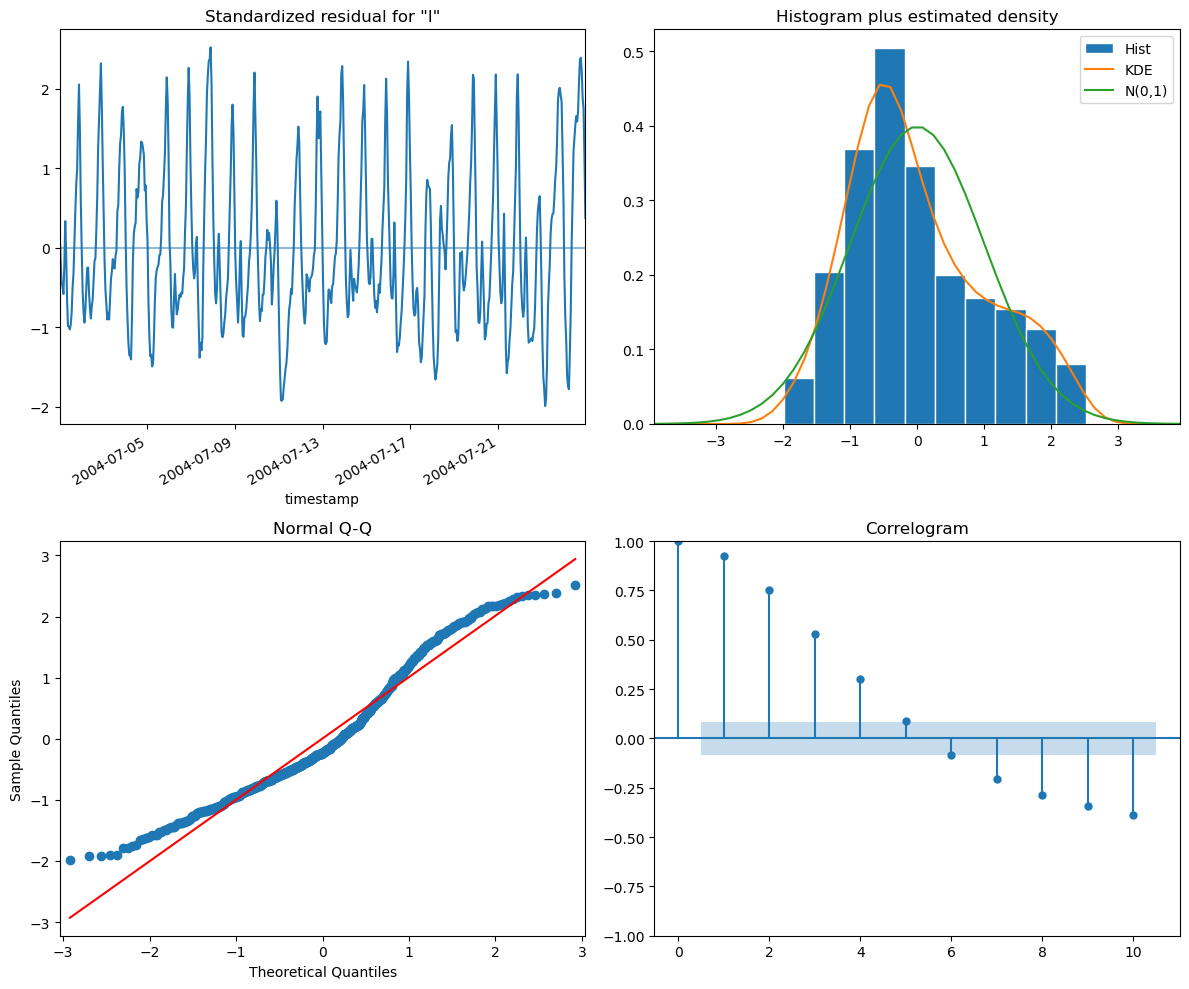

In [150]:
# Diagnostics (for (0,0,0,0))

import statsmodels.api as sm
SARIMA_model = sm.tsa.statespace.SARIMAX(
        endog = load_long_z1_2004_jul_train["log_load_rs"].asfreq('h'), 
        exog = load_long_z1_2004_jul_train[["HDK", "CDK", "holiday","const", "trend"]].asfreq('h'), 
        order=(0,0,0),  # non-seasonal: with no differencing
        seasonal_order=(0,0,0,24) # seasonal: with no seasonal differencing
)

SARIMA_model_fit = SARIMA_model.fit(disp=False, maxiter=500)
SARIMA_model_fit.plot_diagnostics(figsize=(12,10))
plt.tight_layout()
plt.show()

Again, there is uncaptured correlation. Both harmonics and AR/MA components are absent.

In [151]:
# are residuals stationary?
fitted_z1_2004_jul_train = SARIMA_model_fit.predict(start=load_long_z1_2004_jul_train["log_load_rs"].index[0], end=load_long_z1_2004_jul_train["log_load_rs"].index[-1])

check_stationarity(load_long_z1_2004_jul_train["log_load_rs"] - fitted_z1_2004_jul_train)

ADF Statistic: -3.059379561186044
p-value: 0.02970901194239481
Stationary


In [100]:
# Creating test data
load_long_z1_2004_jul_test = mul_df.loc[mul_df.month == 7,:]
load_long_z1_2004_jul_test = load_long_z1_2004_jul_test.set_index("timestamp")
load_long_z1_2004_jul_test = load_long_z1_2004_jul_test['2004-07-25 00:30:00':]
load_long_z1_2004_jul_test.index = pd.to_datetime(load_long_z1_2004_jul_test.index)
load_long_z1_2004_jul_test.head()

year  month  day   hour  log_load_rs  temp_weighted  \
timestamp                                                                  
2004-07-25 00:30:00  2004      7   25  00:30     2.669517      70.616043   
2004-07-25 01:30:00  2004      7   25  01:30     2.551552      70.893317   
2004-07-25 02:30:00  2004      7   25  02:30     2.486073      70.710504   
2004-07-25 03:30:00  2004      7   25  03:30     2.441738      70.526899   
2004-07-25 04:30:00  2004      7   25  04:30     2.429834      70.527349   

                     holiday  HDK       CDK  const  
timestamp                                           
2004-07-25 00:30:00        0  0.0  5.616043      1  
2004-07-25 01:30:00        0  0.0  5.893317      1  
2004-07-25 02:30:00        0  0.0  5.710504      1  
2004-07-25 03:30:00        0  0.0  5.526899      1  
2004-07-25 04:30:00        0  0.0  5.527349      1

In [101]:
# Adding periodicities
from statsmodels.tsa.deterministic import Fourier
from statsmodels.tsa.deterministic import DeterministicProcess

# Defining the sine wave
dp = DeterministicProcess(
    index=load_long_z1_2004_jul_test.index,
    period=None,         # It's not defined so that frequency can be read from the index
    constant=False,      # defined later
    order=1,             # linear trend not required since seasonal diff made the series stationary
    seasonal=False      # no seasonal dummies
)

trend_df = dp.in_sample()

# Combining trend with other variables
load_long_z1_2004_jul_test = load_long_z1_2004_jul_test.merge(trend_df, on='timestamp', how='left')
load_long_z1_2004_jul_test.head()

year  month  day   hour  log_load_rs  temp_weighted  \
timestamp                                                                  
2004-07-25 00:30:00  2004      7   25  00:30     2.669517      70.616043   
2004-07-25 01:30:00  2004      7   25  01:30     2.551552      70.893317   
2004-07-25 02:30:00  2004      7   25  02:30     2.486073      70.710504   
2004-07-25 03:30:00  2004      7   25  03:30     2.441738      70.526899   
2004-07-25 04:30:00  2004      7   25  04:30     2.429834      70.527349   

                     holiday  HDK       CDK  const  trend  
timestamp                                                  
2004-07-25 00:30:00        0  0.0  5.616043      1    1.0  
2004-07-25 01:30:00        0  0.0  5.893317      1    2.0  
2004-07-25 02:30:00        0  0.0  5.710504      1    3.0  
2004-07-25 03:30:00        0  0.0  5.526899      1    4.0  
2004-07-25 04:30:00        0  0.0  5.527349      1    5.0

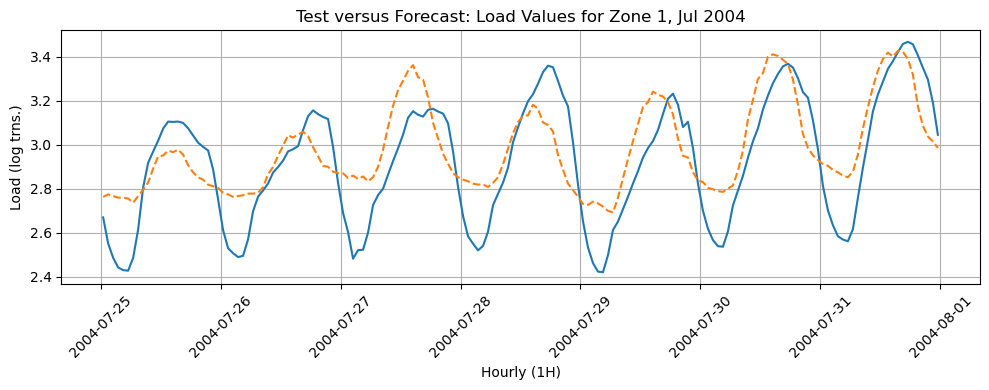

In [102]:
# Predicting 24*7 steps ahead
forecast_jul04 = SARIMA_model_fit.get_forecast(
    steps=24*7, 
    exog = load_long_z1_2004_jul_test[["HDK", "CDK", "holiday","const", "trend"]].asfreq('h')
).predicted_mean

# Fit on the test data
import seaborn as sns
fig, ax = plt.subplots(figsize=(10, 4))
sns.lineplot(data=load_long_z1_2004_jul_test, x=load_long_z1_2004_jul_test.index, y=load_long_z1_2004_jul_test["log_load_rs"].asfreq('h'), ax=ax)
sns.lineplot(forecast_jul04, linestyle = '--')
ax.set_title("Test versus Forecast: Load Values for Zone 1, Jul 2004")
ax.set_xlabel("Hourly (1H)")
ax.set_ylabel("Load (log trns.)")
ax.grid(True)
ax.tick_params(axis="x", rotation=45)

plt.tight_layout()
plt.show()

In [103]:
# Performance on test set

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
print(f"R2 score: {r2_score(load_long_z1_2004_jul_test.log_load_rs, forecast_jul04)}")
print(f'MSE score: {mean_squared_error(load_long_z1_2004_jul_test.log_load_rs, forecast_jul04)}')
print(f'MAE score: {mean_absolute_error(load_long_z1_2004_jul_test.log_load_rs, forecast_jul04)}')
print(f'MAPE score: {mean_absolute_percentage_error(load_long_z1_2004_jul_test.log_load_rs, forecast_jul04)}')

R2 score: 0.5734357516628268
MSE score: 0.03368822634366133
MAE score: 0.15982713227364936
MAPE score: 0.05650468609082951


Performance is again not bad.

##### Testing on Last Week of Oct 2004 (Zone 1)
Last week of Oct 2004 is used for testing. Multiple SARIMAX models are evaluated and compared. 

In [104]:
# Creating training data
load_long_z1_2004_oct_train = mul_df.loc[mul_df.month == 10,:]
load_long_z1_2004_oct_train = load_long_z1_2004_oct_train.set_index("timestamp")
load_long_z1_2004_oct_train = load_long_z1_2004_oct_train[:'2004-10-24 23:30:00']
load_long_z1_2004_oct_train.index = pd.to_datetime(load_long_z1_2004_oct_train.index)
load_long_z1_2004_oct_train.head()

year  month  day   hour  log_load_rs  temp_weighted  \
timestamp                                                                  
2004-10-01 00:30:00  2004     10    1  00:30     2.410093      60.792180   
2004-10-01 01:30:00  2004     10    1  01:30     2.324444      60.513850   
2004-10-01 02:30:00  2004     10    1  02:30     2.293544      60.152501   
2004-10-01 03:30:00  2004     10    1  03:30     2.289399      59.693854   
2004-10-01 04:30:00  2004     10    1  04:30     2.303684      59.417333   

                     holiday  HDK  CDK  const  
timestamp                                      
2004-10-01 00:30:00        0  0.0  0.0      1  
2004-10-01 01:30:00        0  0.0  0.0      1  
2004-10-01 02:30:00        0  0.0  0.0      1  
2004-10-01 03:30:00        0  0.0  0.0      1  
2004-10-01 04:30:00        0  0.0  0.0      1

In [105]:
# Adding periodicities
from statsmodels.tsa.deterministic import Fourier
from statsmodels.tsa.deterministic import DeterministicProcess

# Defining the sine wave
dp = DeterministicProcess(
    index=load_long_z1_2004_oct_train.index,
    period=None,         # It's not defined so that frequency can be read from the index
    constant=False,      # defined later
    order=1,             # linear trend not required since seasonal diff made the series stationary
    seasonal=False      # no seasonal dummies
)

trend_df = dp.in_sample()

# Combining trend with other variables
load_long_z1_2004_oct_train = load_long_z1_2004_oct_train.merge(trend_df, on='timestamp', how='left')
load_long_z1_2004_oct_train.head()

year  month  day   hour  log_load_rs  temp_weighted  \
timestamp                                                                  
2004-10-01 00:30:00  2004     10    1  00:30     2.410093      60.792180   
2004-10-01 01:30:00  2004     10    1  01:30     2.324444      60.513850   
2004-10-01 02:30:00  2004     10    1  02:30     2.293544      60.152501   
2004-10-01 03:30:00  2004     10    1  03:30     2.289399      59.693854   
2004-10-01 04:30:00  2004     10    1  04:30     2.303684      59.417333   

                     holiday  HDK  CDK  const  trend  
timestamp                                             
2004-10-01 00:30:00        0  0.0  0.0      1    1.0  
2004-10-01 01:30:00        0  0.0  0.0      1    2.0  
2004-10-01 02:30:00        0  0.0  0.0      1    3.0  
2004-10-01 03:30:00        0  0.0  0.0      1    4.0  
2004-10-01 04:30:00        0  0.0  0.0      1    5.0

In [106]:
# Comparing models - auto_arima

import pmdarima as pm
smodel_oct = pm.auto_arima(y = load_long_z1_2004_oct_train["log_load_rs"].asfreq('h'), 
                           X = load_long_z1_2004_oct_train[["HDK", "CDK", "holiday","const", "trend"]].asfreq('h'),
                           start_p=0, start_q=0,test='adf',
                           max_p=3, max_q=3, m=24,
                           start_P=0, start_Q=0, max_P=2, max_Q=2, seasonal=True,
                           d=0, D=0, trace=True,
                           error_action='ignore',
                           suppress_warnings=True, 
                           stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[24] intercept   : AIC=inf, Time=nan sec
 ARIMA(1,0,0)(1,0,0)[24] intercept   : AIC=inf, Time=nan sec
 ARIMA(0,0,1)(0,0,1)[24] intercept   : AIC=inf, Time=nan sec
 ARIMA(0,0,0)(0,0,0)[24]             : AIC=-443.758, Time=0.45 sec
 ARIMA(0,0,0)(1,0,0)[24] intercept   : AIC=inf, Time=nan sec
 ARIMA(0,0,0)(0,0,1)[24] intercept   : AIC=inf, Time=nan sec
 ARIMA(0,0,0)(1,0,1)[24] intercept   : AIC=inf, Time=nan sec
 ARIMA(1,0,0)(0,0,0)[24] intercept   : AIC=inf, Time=nan sec
 ARIMA(0,0,1)(0,0,0)[24] intercept   : AIC=inf, Time=nan sec
 ARIMA(1,0,1)(0,0,0)[24] intercept   : AIC=inf, Time=nan sec

Best model:  ARIMA(0,0,0)(0,0,0)[24]          
Total fit time: 0.458 seconds


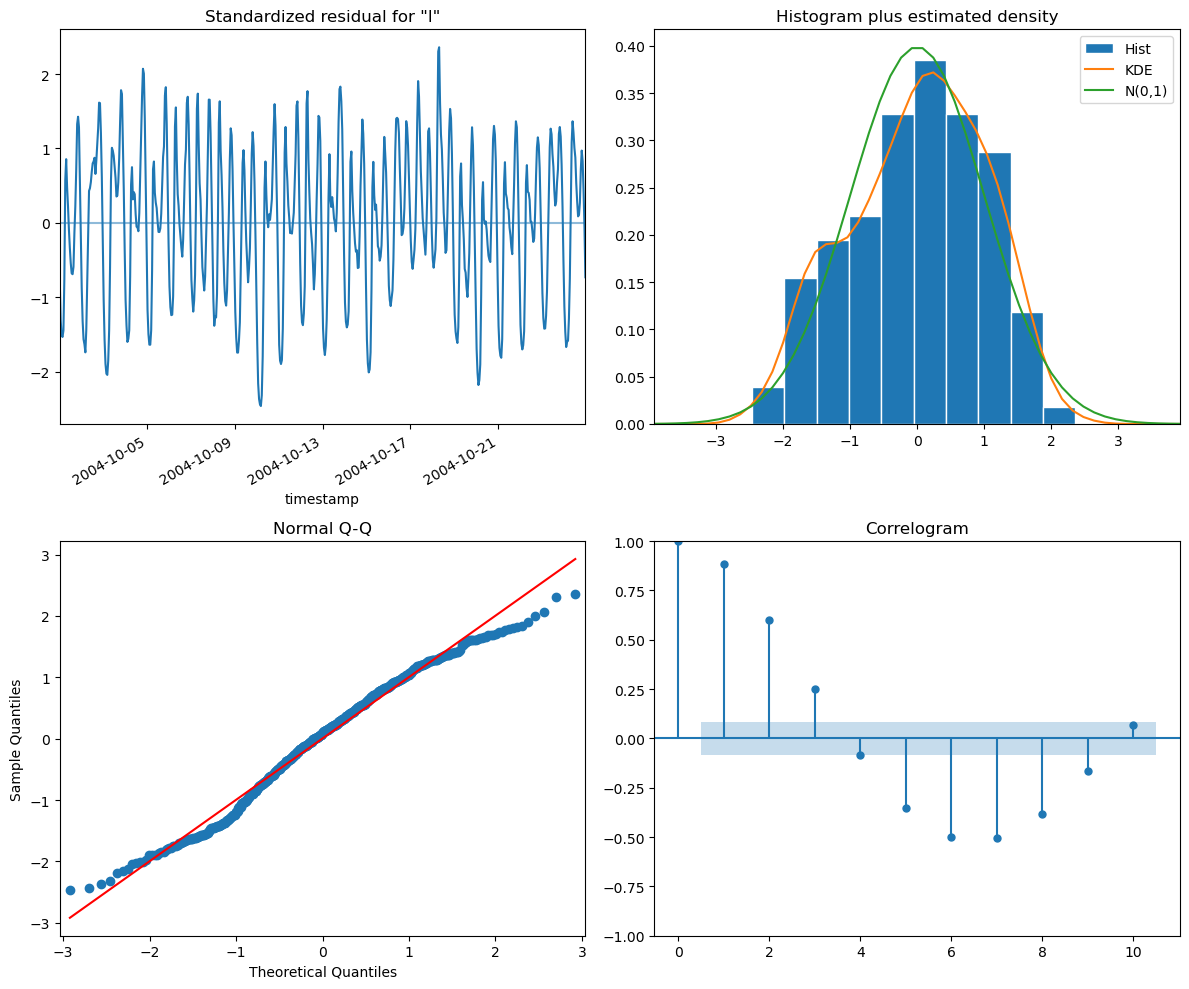

In [152]:
# Diagnostics (for (0,0,0,0))

import statsmodels.api as sm
SARIMA_model = sm.tsa.statespace.SARIMAX(
        endog = load_long_z1_2004_oct_train["log_load_rs"].asfreq('h'), 
        exog = load_long_z1_2004_oct_train[["HDK", "CDK", "holiday","const", "trend"]].asfreq('h'), 
        order=(0,0,0),  # non-seasonal: with no differencing
        seasonal_order=(0,0,0,24) # seasonal: with no seasonal differencing
)

SARIMA_model_fit = SARIMA_model.fit(disp=False, maxiter=500)
SARIMA_model_fit.plot_diagnostics(figsize=(12,10))
plt.tight_layout()
plt.show()

Again, there is uncaptured correlation. Both harmonics and AR/MA components are absent.

In [153]:
# are residuals stationary?
fitted_z1_2004_oct_train = SARIMA_model_fit.predict(start=load_long_z1_2004_oct_train["log_load_rs"].index[0], end=load_long_z1_2004_oct_train["log_load_rs"].index[-1])

check_stationarity(load_long_z1_2004_oct_train["log_load_rs"] - fitted_z1_2004_oct_train)

ADF Statistic: -3.791285451068493
p-value: 0.002997745322404084
Stationary


In [108]:
# Creating test data
load_long_z1_2004_oct_test = mul_df.loc[mul_df.month == 10,:]
load_long_z1_2004_oct_test = load_long_z1_2004_oct_test.set_index("timestamp")
load_long_z1_2004_oct_test = load_long_z1_2004_oct_test['2004-10-25 00:30:00':]
load_long_z1_2004_oct_test.index = pd.to_datetime(load_long_z1_2004_oct_test.index)
load_long_z1_2004_oct_test.head()

year  month  day   hour  log_load_rs  temp_weighted  \
timestamp                                                                  
2004-10-25 00:30:00  2004     10   25  00:30     2.449970      50.290127   
2004-10-25 01:30:00  2004     10   25  01:30     2.407305      50.291859   
2004-10-25 02:30:00  2004     10   25  02:30     2.395164      50.658222   
2004-10-25 03:30:00  2004     10   25  03:30     2.396531      50.571048   
2004-10-25 04:30:00  2004     10   25  04:30     2.434403      50.467636   

                     holiday       HDK  CDK  const  
timestamp                                           
2004-10-25 00:30:00        0  4.709873  0.0      1  
2004-10-25 01:30:00        0  4.708141  0.0      1  
2004-10-25 02:30:00        0  4.341778  0.0      1  
2004-10-25 03:30:00        0  4.428952  0.0      1  
2004-10-25 04:30:00        0  4.532364  0.0      1

In [109]:
# Adding periodicities
from statsmodels.tsa.deterministic import Fourier
from statsmodels.tsa.deterministic import DeterministicProcess

# Defining the sine wave
dp = DeterministicProcess(
    index=load_long_z1_2004_oct_test.index,
    period=None,         # It's not defined so that frequency can be read from the index
    constant=False,      # defined later
    order=1,             # linear trend not required since seasonal diff made the series stationary
    seasonal=False      # no seasonal dummies
)

trend_df = dp.in_sample()

# Combining trend with other variables
load_long_z1_2004_oct_test = load_long_z1_2004_oct_test.merge(trend_df, on='timestamp', how='left')
load_long_z1_2004_oct_test.head()

year  month  day   hour  log_load_rs  temp_weighted  \
timestamp                                                                  
2004-10-25 00:30:00  2004     10   25  00:30     2.449970      50.290127   
2004-10-25 01:30:00  2004     10   25  01:30     2.407305      50.291859   
2004-10-25 02:30:00  2004     10   25  02:30     2.395164      50.658222   
2004-10-25 03:30:00  2004     10   25  03:30     2.396531      50.571048   
2004-10-25 04:30:00  2004     10   25  04:30     2.434403      50.467636   

                     holiday       HDK  CDK  const  trend  
timestamp                                                  
2004-10-25 00:30:00        0  4.709873  0.0      1    1.0  
2004-10-25 01:30:00        0  4.708141  0.0      1    2.0  
2004-10-25 02:30:00        0  4.341778  0.0      1    3.0  
2004-10-25 03:30:00        0  4.428952  0.0      1    4.0  
2004-10-25 04:30:00        0  4.532364  0.0      1    5.0

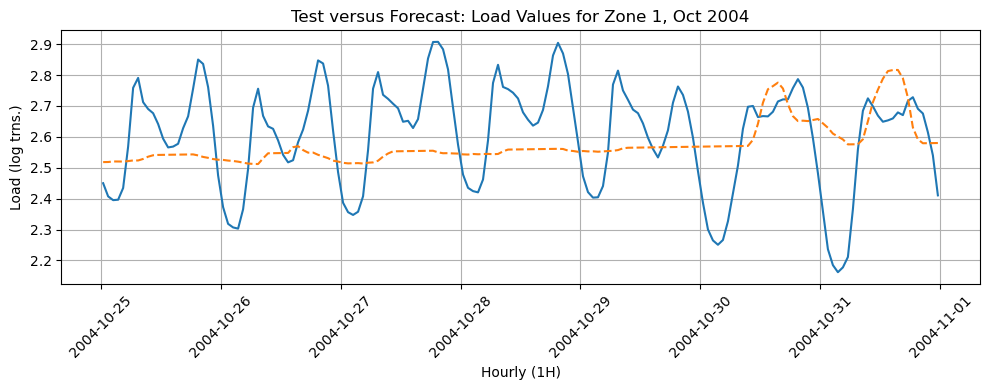

In [110]:
# Predicting 24*7 steps ahead
forecast_oct04 = SARIMA_model_fit.get_forecast(
    steps=24*7, 
    exog = load_long_z1_2004_oct_test[["HDK", "CDK", "holiday","const", "trend"]].asfreq('h')
).predicted_mean

# Fit on the test data
import seaborn as sns
fig, ax = plt.subplots(figsize=(10, 4))
sns.lineplot(data=load_long_z1_2004_oct_test, x=load_long_z1_2004_oct_test.index, y=load_long_z1_2004_oct_test["log_load_rs"].asfreq('h'), ax=ax)
sns.lineplot(forecast_oct04, linestyle = '--')
ax.set_title("Test versus Forecast: Load Values for Zone 1, Oct 2004")
ax.set_xlabel("Hourly (1H)")
ax.set_ylabel("Load (log trns.)")
ax.grid(True)
ax.tick_params(axis="x", rotation=45)

plt.tight_layout()
plt.show()

In [111]:
# Performance on test set

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
print(f"R2 score: {r2_score(load_long_z1_2004_oct_test.log_load_rs, forecast_oct04)}")
print(f'MSE score: {mean_squared_error(load_long_z1_2004_oct_test.log_load_rs, forecast_oct04)}')
print(f'MAE score: {mean_absolute_error(load_long_z1_2004_oct_test.log_load_rs, forecast_oct04)}')
print(f'MAPE score: {mean_absolute_percentage_error(load_long_z1_2004_oct_test.log_load_rs, forecast_oct04)}')

R2 score: -0.09079105500478346
MSE score: 0.030801274138618624
MAE score: 0.14521554715355736
MAPE score: 0.05614186284308552


Performance detoriated here.

##### Testing on Last Week of Dec 2004 (Zone 1)
Last week of Dec 2004 is used for testing. Multiple SARIMAX models are evaluated and compared. 

In [112]:
# Creating training data
load_long_z1_2004_dec_train = mul_df.loc[mul_df.month == 12,:]
load_long_z1_2004_dec_train = load_long_z1_2004_dec_train.set_index("timestamp")
load_long_z1_2004_dec_train = load_long_z1_2004_dec_train[:'2004-12-24 23:30:00']
load_long_z1_2004_dec_train.index = pd.to_datetime(load_long_z1_2004_dec_train.index)
load_long_z1_2004_dec_train.head()

year  month  day   hour  log_load_rs  temp_weighted  \
timestamp                                                                  
2004-12-01 00:30:00  2004     12    1  00:30     2.650774      47.965991   
2004-12-01 01:30:00  2004     12    1  01:30     2.609481      48.609925   
2004-12-01 02:30:00  2004     12    1  02:30     2.608304      49.154281   
2004-12-01 03:30:00  2004     12    1  03:30     2.617177      50.252969   
2004-12-01 04:30:00  2004     12    1  04:30     2.646104      51.607521   

                     holiday       HDK  CDK  const  
timestamp                                           
2004-12-01 00:30:00        0  7.034009  0.0      1  
2004-12-01 01:30:00        0  6.390075  0.0      1  
2004-12-01 02:30:00        0  5.845719  0.0      1  
2004-12-01 03:30:00        0  4.747031  0.0      1  
2004-12-01 04:30:00        0  3.392479  0.0      1

In [113]:
# Adding periodicities
from statsmodels.tsa.deterministic import Fourier
from statsmodels.tsa.deterministic import DeterministicProcess

# Defining the sine wave
dp = DeterministicProcess(
    index=load_long_z1_2004_dec_train.index,
    period=None,         # It's not defined so that frequency can be read from the index
    constant=False,      # defined later
    order=1,             # linear trend not required since seasonal diff made the series stationary
    seasonal=False      # no seasonal dummies
)

trend_df = dp.in_sample()

# Combining trend with other variables
load_long_z1_2004_dec_train = load_long_z1_2004_dec_train.merge(trend_df, on='timestamp', how='left')
load_long_z1_2004_dec_train.head()

year  month  day   hour  log_load_rs  temp_weighted  \
timestamp                                                                  
2004-12-01 00:30:00  2004     12    1  00:30     2.650774      47.965991   
2004-12-01 01:30:00  2004     12    1  01:30     2.609481      48.609925   
2004-12-01 02:30:00  2004     12    1  02:30     2.608304      49.154281   
2004-12-01 03:30:00  2004     12    1  03:30     2.617177      50.252969   
2004-12-01 04:30:00  2004     12    1  04:30     2.646104      51.607521   

                     holiday       HDK  CDK  const  trend  
timestamp                                                  
2004-12-01 00:30:00        0  7.034009  0.0      1    1.0  
2004-12-01 01:30:00        0  6.390075  0.0      1    2.0  
2004-12-01 02:30:00        0  5.845719  0.0      1    3.0  
2004-12-01 03:30:00        0  4.747031  0.0      1    4.0  
2004-12-01 04:30:00        0  3.392479  0.0      1    5.0

In [114]:
# Comparing models - auto_arima

import pmdarima as pm
smodel_oct = pm.auto_arima(y = load_long_z1_2004_dec_train["log_load_rs"].asfreq('h'), 
                           X = load_long_z1_2004_dec_train[["HDK", "CDK", "holiday","const", "trend"]].asfreq('h'),
                           start_p=0, start_q=0,test='adf',
                           max_p=3, max_q=3, m=24,
                           start_P=0, start_Q=0, max_P=2, max_Q=2, seasonal=True,
                           d=0, D=0, trace=True,
                           error_action='ignore',
                           suppress_warnings=True, 
                           stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[24] intercept   : AIC=inf, Time=nan sec
 ARIMA(1,0,0)(1,0,0)[24] intercept   : AIC=inf, Time=nan sec
 ARIMA(0,0,1)(0,0,1)[24] intercept   : AIC=inf, Time=nan sec
 ARIMA(0,0,0)(0,0,0)[24]             : AIC=-672.480, Time=0.84 sec
 ARIMA(0,0,0)(1,0,0)[24] intercept   : AIC=inf, Time=nan sec
 ARIMA(0,0,0)(0,0,1)[24] intercept   : AIC=inf, Time=nan sec
 ARIMA(0,0,0)(1,0,1)[24] intercept   : AIC=inf, Time=nan sec
 ARIMA(1,0,0)(0,0,0)[24] intercept   : AIC=inf, Time=nan sec
 ARIMA(0,0,1)(0,0,0)[24] intercept   : AIC=inf, Time=nan sec
 ARIMA(1,0,1)(0,0,0)[24] intercept   : AIC=inf, Time=nan sec

Best model:  ARIMA(0,0,0)(0,0,0)[24]          
Total fit time: 0.855 seconds


C:\Users\singh\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


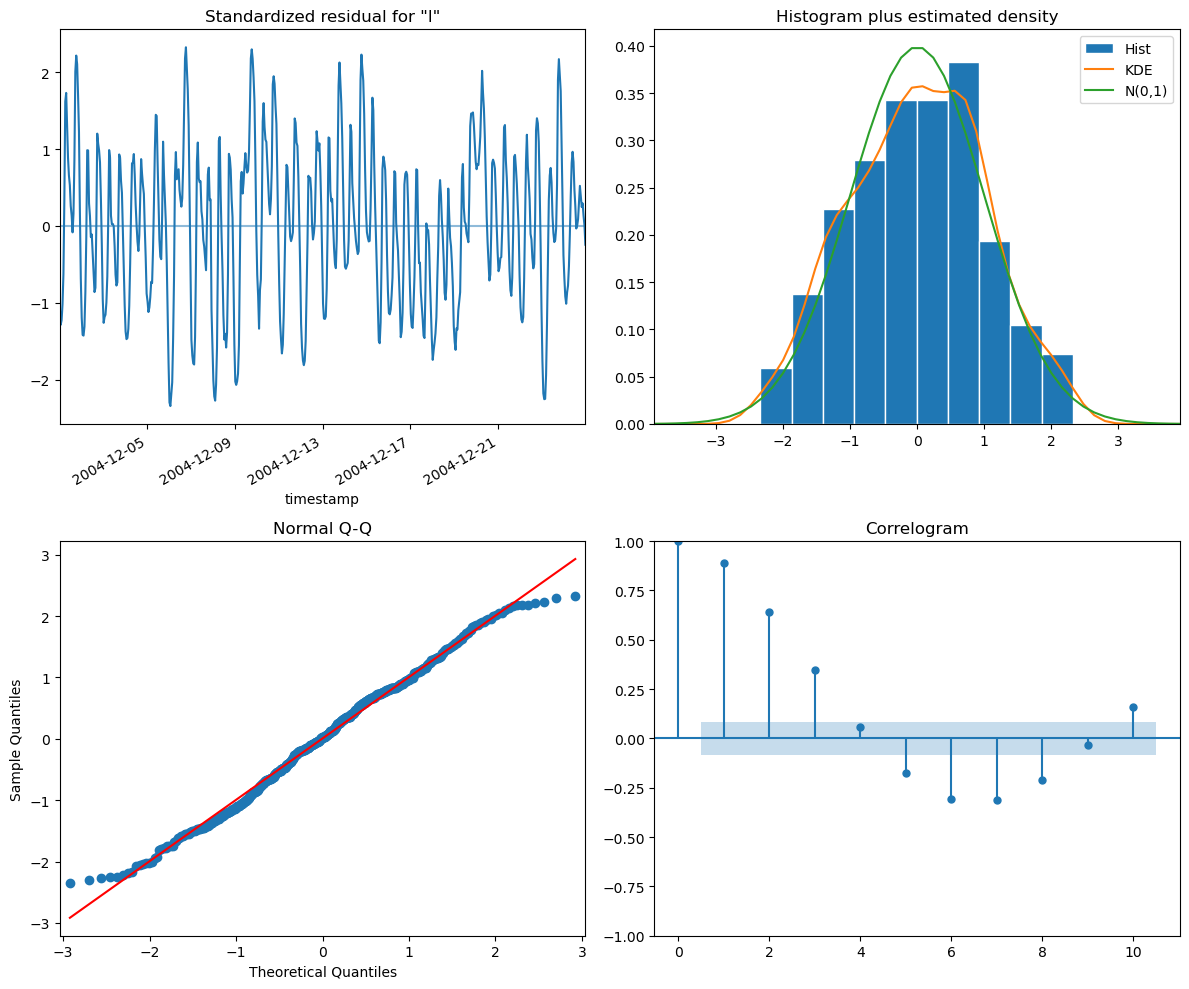

In [154]:
# Diagnostics (for (0,0,0,0))

import statsmodels.api as sm
SARIMA_model = sm.tsa.statespace.SARIMAX(
        endog = load_long_z1_2004_dec_train["log_load_rs"].asfreq('h'), 
        exog = load_long_z1_2004_dec_train[["HDK", "CDK", "holiday","const", "trend"]].asfreq('h'), 
        order=(0,0,0),  # non-seasonal: with no differencing
        seasonal_order=(0,0,0,24) # seasonal: with no seasonal differencing
)

SARIMA_model_fit = SARIMA_model.fit(disp=False, maxiter=500)
SARIMA_model_fit.plot_diagnostics(figsize=(12,10))
plt.tight_layout()
plt.show()

Again, there is uncaptured correlation. Both harmonics and AR/MA components are absent.

In [155]:
# are residuals stationary?
fitted_z1_2004_dec_train = SARIMA_model_fit.predict(start=load_long_z1_2004_dec_train["log_load_rs"].index[0], end=load_long_z1_2004_dec_train["log_load_rs"].index[-1])

check_stationarity(load_long_z1_2004_dec_train["log_load_rs"] - fitted_z1_2004_dec_train)

ADF Statistic: -3.83307117420792
p-value: 0.002586510633518293
Stationary


In [116]:
# Creating test data
load_long_z1_2004_dec_test = mul_df.loc[mul_df.month == 12,:]
load_long_z1_2004_dec_test = load_long_z1_2004_dec_test.set_index("timestamp")
load_long_z1_2004_dec_test = load_long_z1_2004_dec_test['2004-12-25 00:30:00':]
load_long_z1_2004_dec_test.index = pd.to_datetime(load_long_z1_2004_dec_test.index)
load_long_z1_2004_dec_test.head()

year  month  day   hour  log_load_rs  temp_weighted  \
timestamp                                                                  
2004-12-25 00:30:00  2004     12   25  00:30     3.270443      25.586955   
2004-12-25 01:30:00  2004     12   25  01:30     3.272530      24.675567   
2004-12-25 02:30:00  2004     12   25  02:30     3.290191      24.681275   
2004-12-25 03:30:00  2004     12   25  03:30     3.314804      24.588997   
2004-12-25 04:30:00  2004     12   25  04:30     3.350676      24.320518   

                     holiday        HDK  CDK  const  
timestamp                                            
2004-12-25 00:30:00        0  29.413045  0.0      1  
2004-12-25 01:30:00        0  30.324433  0.0      1  
2004-12-25 02:30:00        0  30.318725  0.0      1  
2004-12-25 03:30:00        0  30.411003  0.0      1  
2004-12-25 04:30:00        0  30.679482  0.0      1

In [117]:
# Adding periodicities
from statsmodels.tsa.deterministic import Fourier
from statsmodels.tsa.deterministic import DeterministicProcess

# Defining the sine wave
dp = DeterministicProcess(
    index=load_long_z1_2004_dec_test.index,
    period=None,         # It's not defined so that frequency can be read from the index
    constant=False,      # defined later
    order=1,             # linear trend not required since seasonal diff made the series stationary
    seasonal=False      # no seasonal dummies
)

trend_df = dp.in_sample()

# Combining trend with other variables
load_long_z1_2004_dec_test = load_long_z1_2004_dec_test.merge(trend_df, on='timestamp', how='left')
load_long_z1_2004_dec_test.head()

year  month  day   hour  log_load_rs  temp_weighted  \
timestamp                                                                  
2004-12-25 00:30:00  2004     12   25  00:30     3.270443      25.586955   
2004-12-25 01:30:00  2004     12   25  01:30     3.272530      24.675567   
2004-12-25 02:30:00  2004     12   25  02:30     3.290191      24.681275   
2004-12-25 03:30:00  2004     12   25  03:30     3.314804      24.588997   
2004-12-25 04:30:00  2004     12   25  04:30     3.350676      24.320518   

                     holiday        HDK  CDK  const  trend  
timestamp                                                   
2004-12-25 00:30:00        0  29.413045  0.0      1    1.0  
2004-12-25 01:30:00        0  30.324433  0.0      1    2.0  
2004-12-25 02:30:00        0  30.318725  0.0      1    3.0  
2004-12-25 03:30:00        0  30.411003  0.0      1    4.0  
2004-12-25 04:30:00        0  30.679482  0.0      1    5.0

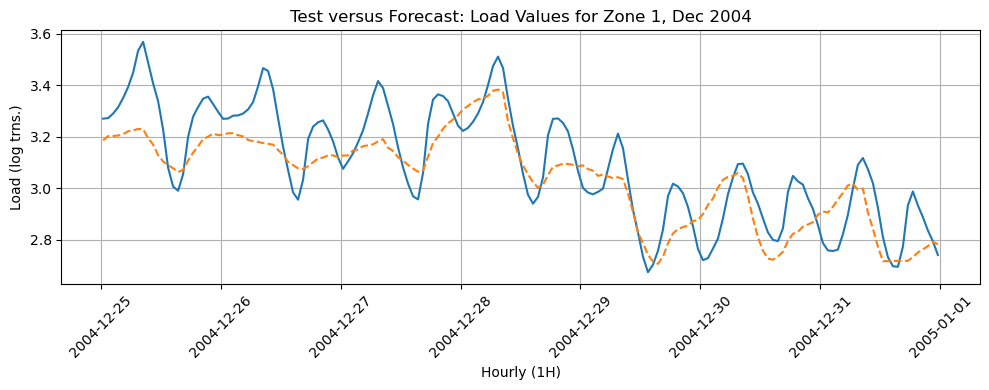

In [118]:
# Predicting 24*7 steps ahead
forecast_dec04 = SARIMA_model_fit.get_forecast(
    steps=24*7, 
    exog = load_long_z1_2004_dec_test[["HDK", "CDK", "holiday","const", "trend"]].asfreq('h')
).predicted_mean

# Fit on the test data
import seaborn as sns
fig, ax = plt.subplots(figsize=(10, 4))
sns.lineplot(data=load_long_z1_2004_dec_test, x=load_long_z1_2004_dec_test.index, y=load_long_z1_2004_dec_test["log_load_rs"].asfreq('h'), ax=ax)
sns.lineplot(forecast_dec04, linestyle = '--')
ax.set_title("Test versus Forecast: Load Values for Zone 1, Dec 2004")
ax.set_xlabel("Hourly (1H)")
ax.set_ylabel("Load (log trns.)")
ax.grid(True)
ax.tick_params(axis="x", rotation=45)

plt.tight_layout()
plt.show()

In [119]:
# Performance on test set

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
print(f"R2 score: {r2_score(load_long_z1_2004_dec_test.log_load_rs, forecast_dec04)}")
print(f'MSE score: {mean_squared_error(load_long_z1_2004_dec_test.log_load_rs, forecast_dec04)}')
print(f'MAE score: {mean_absolute_error(load_long_z1_2004_dec_test.log_load_rs, forecast_dec04)}')
print(f'MAPE score: {mean_absolute_percentage_error(load_long_z1_2004_dec_test.log_load_rs, forecast_dec04)}')

R2 score: 0.6502250641886818
MSE score: 0.016412699611189092
MAE score: 0.1076384918719307
MAPE score: 0.034405743780393086


Performance is strong here.

## Removing Fourier Terms with SARIMAX (D=1)
- The model removes fourier terms, as used in time series regression. This is then combined with SARIMAX, where seasonal AR\MA components are also defined.
- Seasonal differencing is done here.
- Intercept is added using the "const" column

##### Testing on Last Week of Jan 2004 (Zone 1)
Last week of Jan 2004 is used for testing. Multiple SARIMAX models are evaluated and compared. 

In [120]:
# Comparing models - auto_arima

import pmdarima as pm
smodel_jan = pm.auto_arima(y = load_long_z1_2004_jan_train["log_load_rs"].asfreq('h'), 
                           X = load_long_z1_2004_jan_train[["HDK", "CDK", "holiday","const", "trend"]].asfreq('h'),
                           start_p=0, start_q=0,test='adf',
                           max_p=3, max_q=3, m=24,
                           start_P=0, start_Q=0, max_P=2, max_Q=2, seasonal=True,
                           d=0, D=1, trace=True,
                           error_action='ignore',
                           suppress_warnings=True, 
                           stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[24] intercept   : AIC=inf, Time=nan sec
 ARIMA(1,0,0)(1,1,0)[24] intercept   : AIC=inf, Time=nan sec
 ARIMA(0,0,1)(0,1,1)[24] intercept   : AIC=inf, Time=nan sec
 ARIMA(0,0,0)(0,1,0)[24]             : AIC=-904.790, Time=4.68 sec
 ARIMA(0,0,0)(1,1,0)[24] intercept   : AIC=inf, Time=nan sec
 ARIMA(0,0,0)(0,1,1)[24] intercept   : AIC=inf, Time=nan sec
 ARIMA(0,0,0)(1,1,1)[24] intercept   : AIC=inf, Time=nan sec
 ARIMA(1,0,0)(0,1,0)[24] intercept   : AIC=inf, Time=nan sec
 ARIMA(0,0,1)(0,1,0)[24] intercept   : AIC=inf, Time=nan sec
 ARIMA(1,0,1)(0,1,0)[24] intercept   : AIC=inf, Time=nan sec

Best model:  ARIMA(0,0,0)(0,1,0)[24]          
Total fit time: 4.689 seconds


The order of the seasonal and non-seasonal AR/MA components has now changed, compared to the case of using SARIMAX without external regressors.

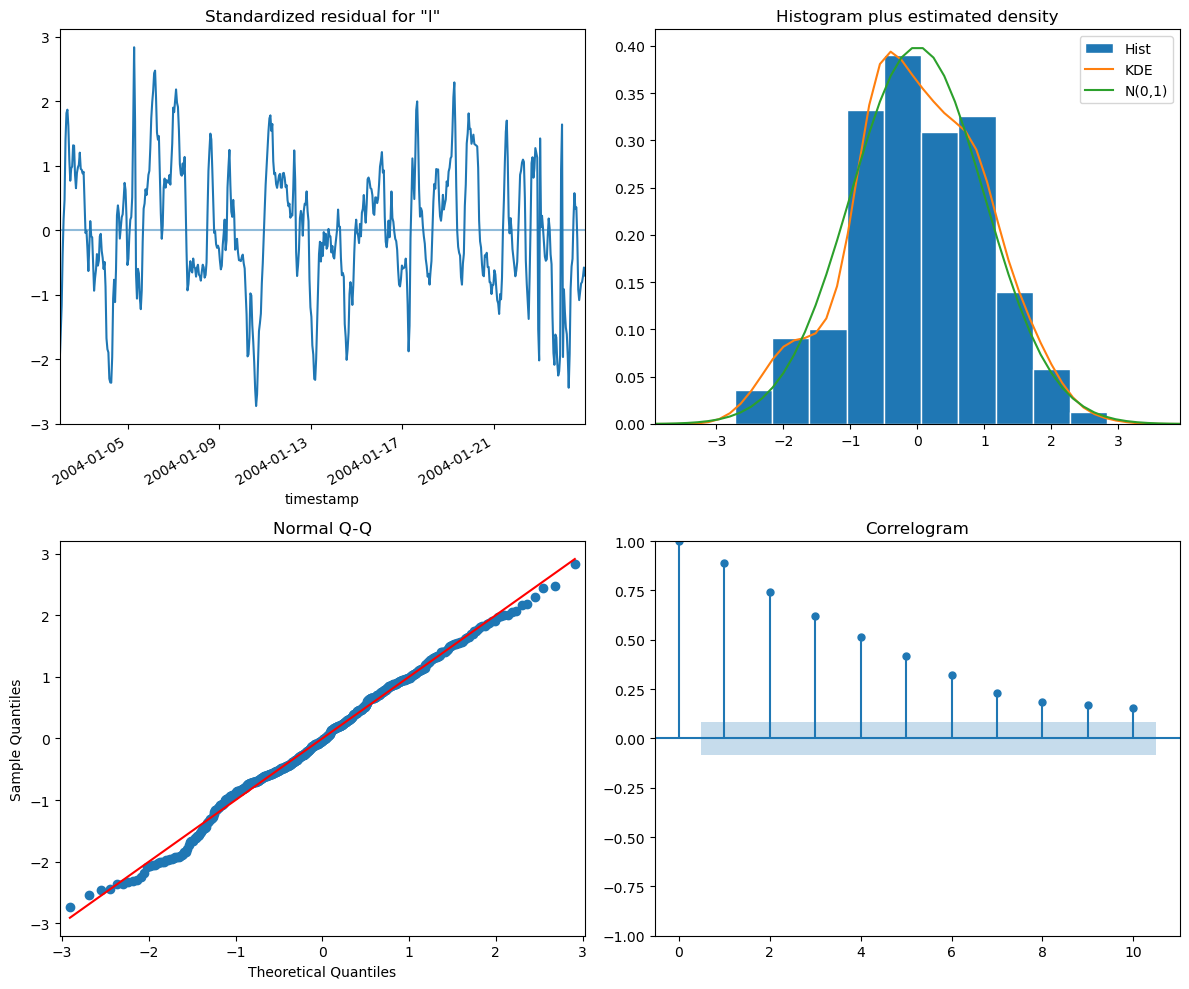

In [156]:
# Diagnostics (for (0,0,0,0))

import statsmodels.api as sm
SARIMA_model = sm.tsa.statespace.SARIMAX(
        endog = load_long_z1_2004_jan_train["log_load_rs"].asfreq('h'), 
        exog = load_long_z1_2004_jan_train[["HDK", "CDK", "holiday","const", "trend"]].asfreq('h'), 
        order=(0,0,0),  # non-seasonal: with no differencing
        seasonal_order=(0,1,0,24) # seasonal: with no seasonal differencing
)

SARIMA_model_fit = SARIMA_model.fit(disp=False, maxiter=500)
SARIMA_model_fit.plot_diagnostics(figsize=(12,10))
plt.tight_layout()
plt.show()

Again, there is uncaptured correlation. Both harmonics and AR/MA components are absent.

In [157]:
# are residuals stationary?
fitted_z1_2004_jan_train = SARIMA_model_fit.predict(start=load_long_z1_2004_jan_train["log_load_rs"].index[0], end=load_long_z1_2004_jan_train["log_load_rs"].index[-1])

check_stationarity(load_long_z1_2004_jan_train["log_load_rs"] - fitted_z1_2004_jan_train)

ADF Statistic: -4.8379128429721385
p-value: 4.59957068987969e-05
Stationary


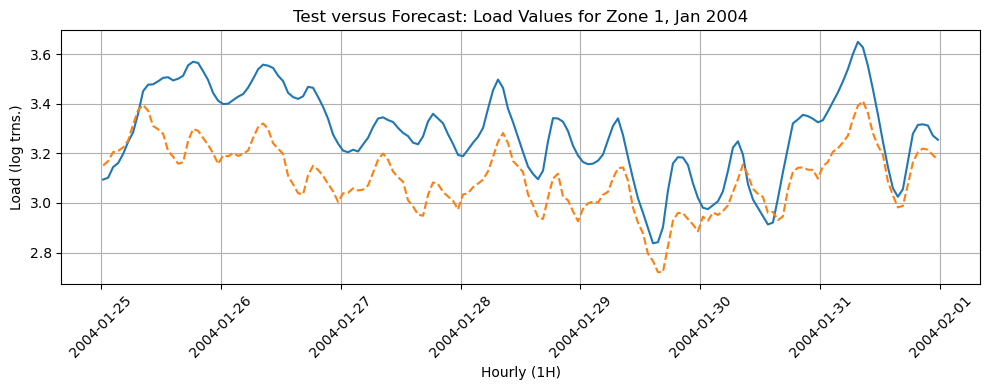

In [122]:
# Predicting 24*7 steps ahead
forecast_jan04 = SARIMA_model_fit.get_forecast(
    steps=24*7, 
    exog = load_long_z1_2004_jan_test[["HDK", "CDK", "holiday","const", "trend"]].asfreq('h')
).predicted_mean

# Fit on the test data
import seaborn as sns
fig, ax = plt.subplots(figsize=(10, 4))
sns.lineplot(data=load_long_z1_2004_jan_test, x=load_long_z1_2004_jan_test.index, y=load_long_z1_2004_jan_test["log_load_rs"].asfreq('h'), ax=ax)
sns.lineplot(forecast_jan04, linestyle = '--')
ax.set_title("Test versus Forecast: Load Values for Zone 1, Jan 2004")
ax.set_xlabel("Hourly (1H)")
ax.set_ylabel("Load (log trns.)")
ax.grid(True)
ax.tick_params(axis="x", rotation=45)

plt.tight_layout()
plt.show()

In [123]:
# Performance on test set

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
print(f"R2 score: {r2_score(load_long_z1_2004_jan_test.log_load_rs, forecast_jan04)}")
print(f'MSE score: {mean_squared_error(load_long_z1_2004_jan_test.log_load_rs, forecast_jan04)}')
print(f'MAE score: {mean_absolute_error(load_long_z1_2004_jan_test.log_load_rs, forecast_jan04)}')
print(f'MAPE score: {mean_absolute_percentage_error(load_long_z1_2004_jan_test.log_load_rs, forecast_jan04)}')

R2 score: -0.3560750359178524
MSE score: 0.04141661892028705
MAE score: 0.18406791155615687
MAPE score: 0.05530988655595008


Performance detoriated.

##### Testing on Last Week of Apr 2004 (Zone 1)
Last week of Jan 2004 is used for testing. Multiple SARIMAX models are evaluated and compared. 

In [124]:
# Comparing models - auto_arima

import pmdarima as pm
smodel_jan = pm.auto_arima(y = load_long_z1_2004_apr_train["log_load_rs"].asfreq('h'), 
                           X = load_long_z1_2004_apr_train[["HDK", "CDK", "holiday","const", "trend"]].asfreq('h'),
                           start_p=0, start_q=0,test='adf',
                           max_p=3, max_q=3, m=24,
                           start_P=0, start_Q=0, max_P=2, max_Q=2, seasonal=True,
                           d=0, D=1, trace=True,
                           error_action='ignore',
                           suppress_warnings=True, 
                           stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[24] intercept   : AIC=inf, Time=nan sec
 ARIMA(1,0,0)(1,1,0)[24] intercept   : AIC=inf, Time=nan sec
 ARIMA(0,0,1)(0,1,1)[24] intercept   : AIC=inf, Time=nan sec
 ARIMA(0,0,0)(0,1,0)[24]             : AIC=-833.371, Time=2.88 sec
 ARIMA(0,0,0)(1,1,0)[24] intercept   : AIC=inf, Time=nan sec
 ARIMA(0,0,0)(0,1,1)[24] intercept   : AIC=inf, Time=nan sec
 ARIMA(0,0,0)(1,1,1)[24] intercept   : AIC=inf, Time=nan sec
 ARIMA(1,0,0)(0,1,0)[24] intercept   : AIC=inf, Time=nan sec
 ARIMA(0,0,1)(0,1,0)[24] intercept   : AIC=inf, Time=nan sec
 ARIMA(1,0,1)(0,1,0)[24] intercept   : AIC=inf, Time=nan sec

Best model:  ARIMA(0,0,0)(0,1,0)[24]          
Total fit time: 2.884 seconds


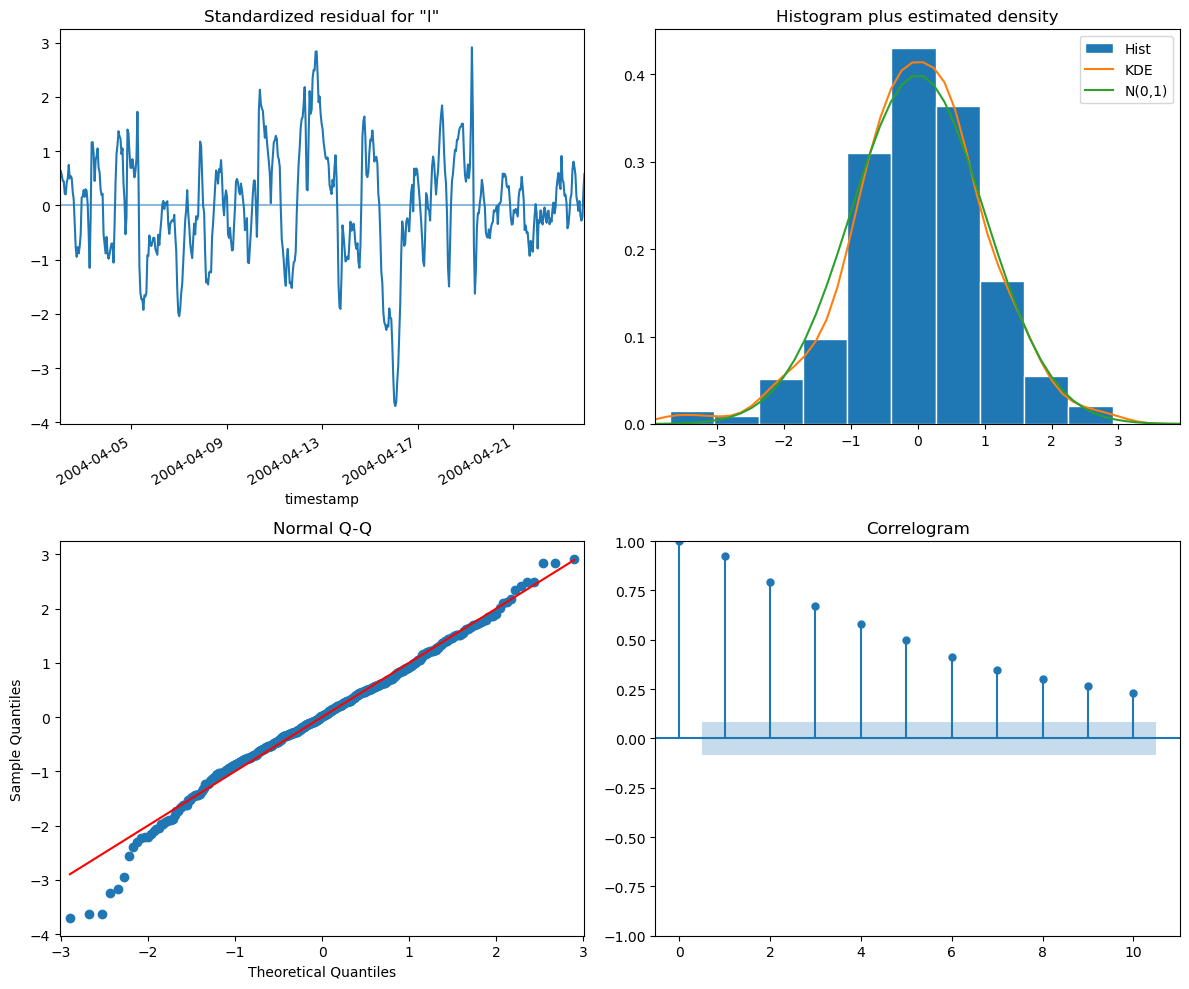

In [158]:
# Diagnostics (for (0,0,0,0))

import statsmodels.api as sm
SARIMA_model = sm.tsa.statespace.SARIMAX(
        endog = load_long_z1_2004_apr_train["log_load_rs"].asfreq('h'), 
        exog = load_long_z1_2004_apr_train[["HDK", "CDK", "holiday","const", "trend"]].asfreq('h'), 
        order=(0,0,0),  # non-seasonal: with no differencing
        seasonal_order=(0,1,0,24) # seasonal: with no seasonal differencing
)

SARIMA_model_fit = SARIMA_model.fit(disp=False, maxiter=500)
SARIMA_model_fit.plot_diagnostics(figsize=(12,10))
plt.tight_layout()
plt.show()

Again, there is uncaptured correlation. Both harmonics and AR/MA components are absent.

In [159]:
# are residuals stationary?
fitted_z1_2004_apr_train = SARIMA_model_fit.predict(start=load_long_z1_2004_apr_train["log_load_rs"].index[0], end=load_long_z1_2004_apr_train["log_load_rs"].index[-1])

check_stationarity(load_long_z1_2004_apr_train["log_load_rs"] - fitted_z1_2004_apr_train)

ADF Statistic: -4.5498071070567025
p-value: 0.00015966927867028125
Stationary


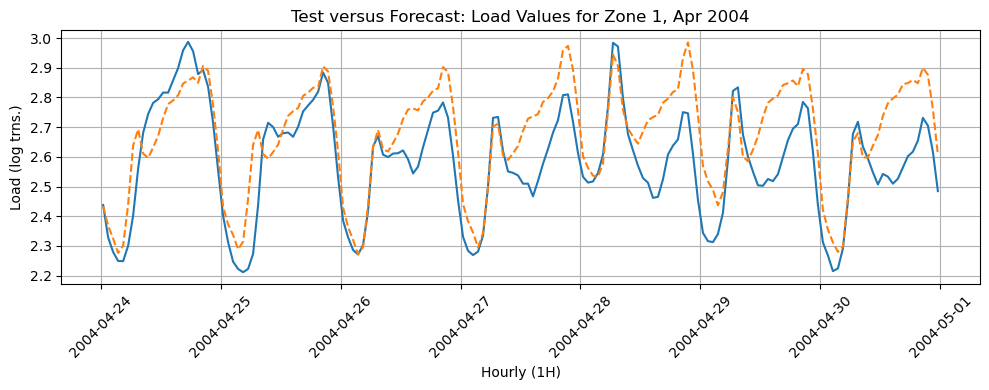

In [126]:
# Predicting 24*7 steps ahead
forecast_apr04 = SARIMA_model_fit.get_forecast(
    steps=24*7, 
    exog = load_long_z1_2004_apr_test[["HDK", "CDK", "holiday","const", "trend"]].asfreq('h')
).predicted_mean

# Fit on the test data
import seaborn as sns
fig, ax = plt.subplots(figsize=(10, 4))
sns.lineplot(data=load_long_z1_2004_apr_test, x=load_long_z1_2004_apr_test.index, y=load_long_z1_2004_apr_test["log_load_rs"].asfreq('h'), ax=ax)
sns.lineplot(forecast_apr04, linestyle = '--')
ax.set_title("Test versus Forecast: Load Values for Zone 1, Apr 2004")
ax.set_xlabel("Hourly (1H)")
ax.set_ylabel("Load (log trns.)")
ax.grid(True)
ax.tick_params(axis="x", rotation=45)

plt.tight_layout()
plt.show()

In [127]:
# Performance on test set

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
print(f"R2 score: {r2_score(load_long_z1_2004_apr_test.log_load_rs, forecast_apr04)}")
print(f'MSE score: {mean_squared_error(load_long_z1_2004_apr_test.log_load_rs, forecast_apr04)}')
print(f'MAE score: {mean_absolute_error(load_long_z1_2004_apr_test.log_load_rs, forecast_apr04)}')
print(f'MAPE score: {mean_absolute_percentage_error(load_long_z1_2004_apr_test.log_load_rs, forecast_apr04)}')

R2 score: 0.42663699818512624
MSE score: 0.019612503337703497
MAE score: 0.112191378777614
MAPE score: 0.04389719015932984


Here, performance increase is notable

##### Testing on Last Week of Jul 2004 (Zone 1)
Last week of Jul 2004 is used for testing. Multiple SARIMAX models are evaluated and compared. 

In [128]:
# Comparing models - auto_arima

import pmdarima as pm
smodel_jul = pm.auto_arima(y = load_long_z1_2004_jul_train["log_load_rs"].asfreq('h'), 
                           X = load_long_z1_2004_jul_train[["HDK", "CDK", "holiday","const", "trend"]].asfreq('h'),
                           start_p=0, start_q=0,test='adf',
                           max_p=3, max_q=3, m=24,
                           start_P=0, start_Q=0, max_P=2, max_Q=2, seasonal=True,
                           d=0, D=1, trace=True,
                           error_action='ignore',
                           suppress_warnings=True, 
                           stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[24] intercept   : AIC=inf, Time=nan sec
 ARIMA(1,0,0)(1,1,0)[24] intercept   : AIC=inf, Time=nan sec
 ARIMA(0,0,1)(0,1,1)[24] intercept   : AIC=inf, Time=nan sec
 ARIMA(0,0,0)(0,1,0)[24]             : AIC=-963.338, Time=2.25 sec
 ARIMA(0,0,0)(1,1,0)[24] intercept   : AIC=inf, Time=nan sec
 ARIMA(0,0,0)(0,1,1)[24] intercept   : AIC=inf, Time=nan sec
 ARIMA(0,0,0)(1,1,1)[24] intercept   : AIC=inf, Time=nan sec
 ARIMA(1,0,0)(0,1,0)[24] intercept   : AIC=inf, Time=nan sec
 ARIMA(0,0,1)(0,1,0)[24] intercept   : AIC=inf, Time=nan sec
 ARIMA(1,0,1)(0,1,0)[24] intercept   : AIC=inf, Time=nan sec

Best model:  ARIMA(0,0,0)(0,1,0)[24]          
Total fit time: 2.258 seconds


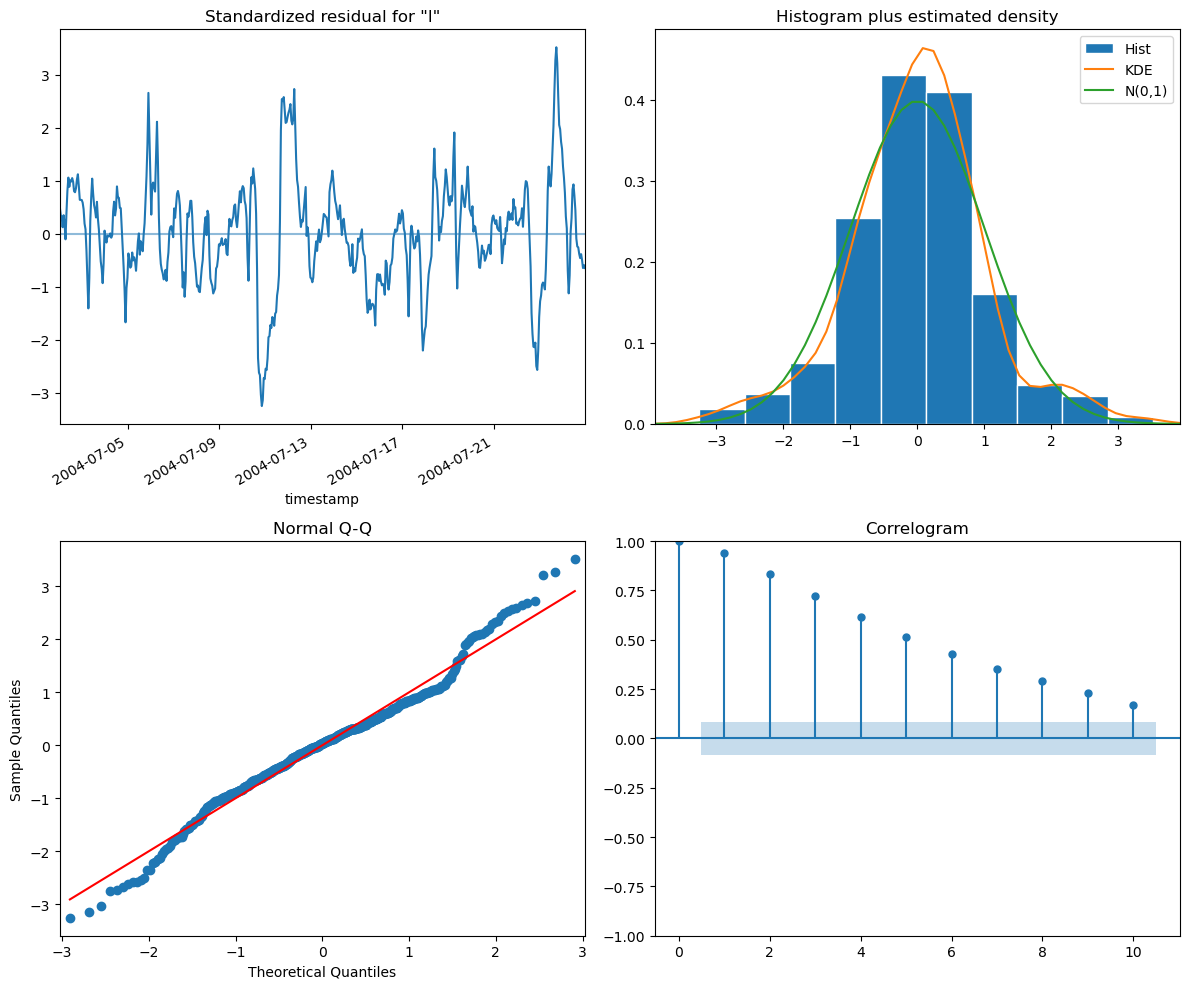

In [161]:
# Diagnostics (for (0,0,0,0))

import statsmodels.api as sm
SARIMA_model = sm.tsa.statespace.SARIMAX(
        endog = load_long_z1_2004_jul_train["log_load_rs"].asfreq('h'), 
        exog = load_long_z1_2004_jul_train[["HDK", "CDK", "holiday","const", "trend"]].asfreq('h'), 
        order=(0,0,0),  # non-seasonal: with no differencing
        seasonal_order=(0,1,0,24) # seasonal: with no seasonal differencing
)

SARIMA_model_fit = SARIMA_model.fit(disp=False, maxiter=500)
SARIMA_model_fit.plot_diagnostics(figsize=(12,10))
plt.tight_layout()
plt.show()

Again, there is uncaptured correlation. Both harmonics and AR/MA components are absent.

In [162]:
# are residuals stationary?
fitted_z1_2004_jul_train = SARIMA_model_fit.predict(start=load_long_z1_2004_jul_train["log_load_rs"].index[0], end=load_long_z1_2004_jul_train["log_load_rs"].index[-1])

check_stationarity(load_long_z1_2004_jul_train["log_load_rs"] - fitted_z1_2004_jul_train)

ADF Statistic: -4.594384642940677
p-value: 0.0001322832457970565
Stationary


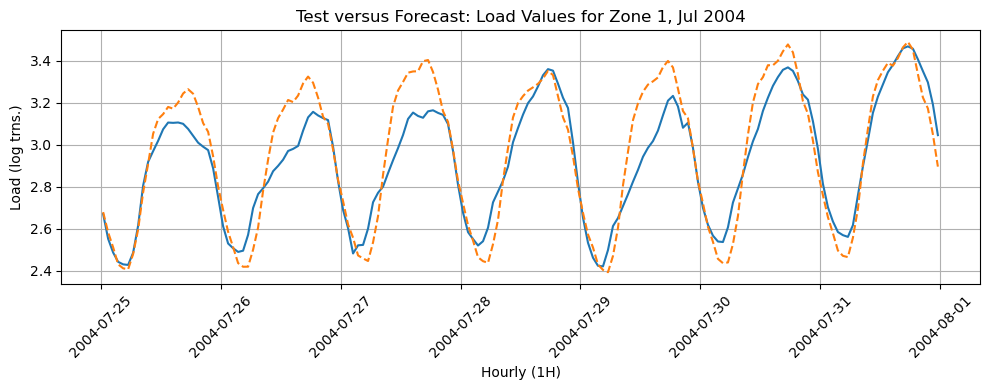

In [130]:
# Predicting 24*7 steps ahead
forecast_jul04 = SARIMA_model_fit.get_forecast(
    steps=24*7, 
    exog = load_long_z1_2004_jul_test[["HDK", "CDK", "holiday","const", "trend"]].asfreq('h')
).predicted_mean

# Fit on the test data
import seaborn as sns
fig, ax = plt.subplots(figsize=(10, 4))
sns.lineplot(data=load_long_z1_2004_jul_test, x=load_long_z1_2004_jul_test.index, y=load_long_z1_2004_jul_test["log_load_rs"].asfreq('h'), ax=ax)
sns.lineplot(forecast_jul04, linestyle = '--')
ax.set_title("Test versus Forecast: Load Values for Zone 1, Jul 2004")
ax.set_xlabel("Hourly (1H)")
ax.set_ylabel("Load (log trns.)")
ax.grid(True)
ax.tick_params(axis="x", rotation=45)

plt.tight_layout()
plt.show()

In [131]:
# Performance on test set

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
print(f"R2 score: {r2_score(load_long_z1_2004_jul_test.log_load_rs, forecast_jul04)}")
print(f'MSE score: {mean_squared_error(load_long_z1_2004_jul_test.log_load_rs, forecast_jul04)}')
print(f'MAE score: {mean_absolute_error(load_long_z1_2004_jul_test.log_load_rs, forecast_jul04)}')
print(f'MAPE score: {mean_absolute_percentage_error(load_long_z1_2004_jul_test.log_load_rs, forecast_jul04)}')

R2 score: 0.7939335614537792
MSE score: 0.01627424907417468
MAE score: 0.09896440846201807
MAPE score: 0.03371773077507574


Performance is again very good.

##### Testing on Last Week of Oct 2004 (Zone 1)
Last week of Oct 2004 is used for testing. Multiple SARIMAX models are evaluated and compared. 

In [132]:
# Comparing models - auto_arima

import pmdarima as pm
smodel_oct = pm.auto_arima(y = load_long_z1_2004_oct_train["log_load_rs"].asfreq('h'), 
                           X = load_long_z1_2004_oct_train[["HDK", "CDK", "holiday","const", "trend"]].asfreq('h'),
                           start_p=0, start_q=0,test='adf',
                           max_p=3, max_q=3, m=24,
                           start_P=0, start_Q=0, max_P=2, max_Q=2, seasonal=True,
                           d=0, D=1, trace=True,
                           error_action='ignore',
                           suppress_warnings=True, 
                           stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[24] intercept   : AIC=inf, Time=nan sec
 ARIMA(1,0,0)(1,1,0)[24] intercept   : AIC=inf, Time=nan sec
 ARIMA(0,0,1)(0,1,1)[24] intercept   : AIC=inf, Time=nan sec
 ARIMA(0,0,0)(0,1,0)[24]             : AIC=-1266.759, Time=2.72 sec
 ARIMA(0,0,0)(1,1,0)[24] intercept   : AIC=inf, Time=nan sec
 ARIMA(0,0,0)(0,1,1)[24] intercept   : AIC=inf, Time=nan sec
 ARIMA(0,0,0)(1,1,1)[24] intercept   : AIC=inf, Time=nan sec
 ARIMA(1,0,0)(0,1,0)[24] intercept   : AIC=inf, Time=nan sec
 ARIMA(0,0,1)(0,1,0)[24] intercept   : AIC=inf, Time=nan sec
 ARIMA(1,0,1)(0,1,0)[24] intercept   : AIC=inf, Time=nan sec

Best model:  ARIMA(0,0,0)(0,1,0)[24]          
Total fit time: 2.741 seconds


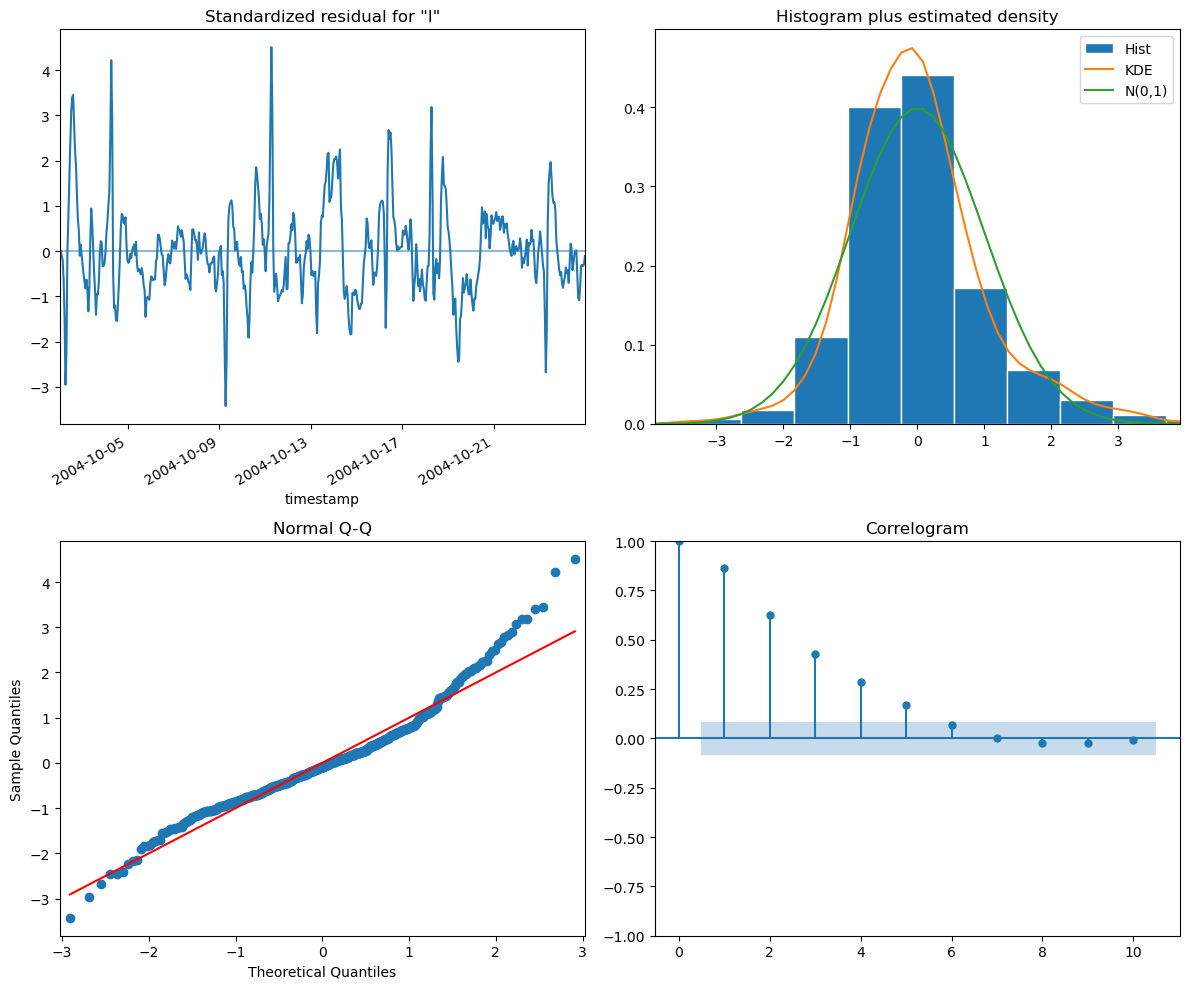

In [163]:
# Diagnostics (for (0,0,0,0))

import statsmodels.api as sm
SARIMA_model = sm.tsa.statespace.SARIMAX(
        endog = load_long_z1_2004_oct_train["log_load_rs"].asfreq('h'), 
        exog = load_long_z1_2004_oct_train[["HDK", "CDK", "holiday","const", "trend"]].asfreq('h'), 
        order=(0,0,0),  # non-seasonal: with no differencing
        seasonal_order=(0,1,0,24) # seasonal: with no seasonal differencing
)

SARIMA_model_fit = SARIMA_model.fit(disp=False, maxiter=500)
SARIMA_model_fit.plot_diagnostics(figsize=(12,10))
plt.tight_layout()
plt.show()

Again, there is uncaptured correlation. Both harmonics and AR/MA components are absent.

In [164]:
# are residuals stationary?
fitted_z1_2004_oct_train = SARIMA_model_fit.predict(start=load_long_z1_2004_oct_train["log_load_rs"].index[0], end=load_long_z1_2004_oct_train["log_load_rs"].index[-1])

check_stationarity(load_long_z1_2004_oct_train["log_load_rs"] - fitted_z1_2004_oct_train)

ADF Statistic: -4.663398075934837
p-value: 9.853520629018146e-05
Stationary


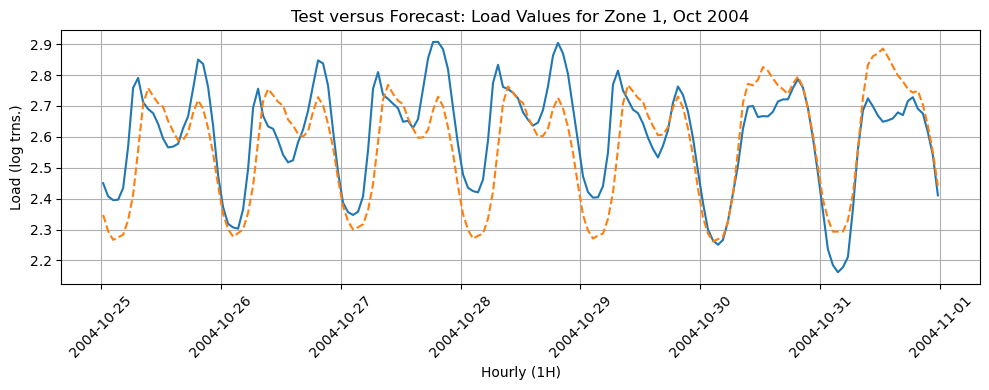

In [134]:
# Predicting 24*7 steps ahead
forecast_oct04 = SARIMA_model_fit.get_forecast(
    steps=24*7, 
    exog = load_long_z1_2004_oct_test[["HDK", "CDK", "holiday","const", "trend"]].asfreq('h')
).predicted_mean

# Fit on the test data
import seaborn as sns
fig, ax = plt.subplots(figsize=(10, 4))
sns.lineplot(data=load_long_z1_2004_oct_test, x=load_long_z1_2004_oct_test.index, y=load_long_z1_2004_oct_test["log_load_rs"].asfreq('h'), ax=ax)
sns.lineplot(forecast_oct04, linestyle = '--')
ax.set_title("Test versus Forecast: Load Values for Zone 1, Oct 2004")
ax.set_xlabel("Hourly (1H)")
ax.set_ylabel("Load (log trns.)")
ax.grid(True)
ax.tick_params(axis="x", rotation=45)

plt.tight_layout()
plt.show()

In [135]:
# Performance on test set

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
print(f"R2 score: {r2_score(load_long_z1_2004_oct_test.log_load_rs, forecast_oct04)}")
print(f'MSE score: {mean_squared_error(load_long_z1_2004_oct_test.log_load_rs, forecast_oct04)}')
print(f'MAE score: {mean_absolute_error(load_long_z1_2004_oct_test.log_load_rs, forecast_oct04)}')
print(f'MAPE score: {mean_absolute_percentage_error(load_long_z1_2004_oct_test.log_load_rs, forecast_oct04)}')

R2 score: 0.46905400480522486
MSE score: 0.014992617583139457
MAE score: 0.09476334740991985
MAPE score: 0.036012479447710896


Performance is good.

##### Testing on Last Week of Dec 2004 (Zone 1)
Last week of Dec 2004 is used for testing. Multiple SARIMAX models are evaluated and compared. 

In [136]:
# Comparing models - auto_arima

import pmdarima as pm
smodel_oct = pm.auto_arima(y = load_long_z1_2004_dec_train["log_load_rs"].asfreq('h'), 
                           X = load_long_z1_2004_dec_train[["HDK", "CDK", "holiday","const", "trend"]].asfreq('h'),
                           start_p=0, start_q=0,test='adf',
                           max_p=3, max_q=3, m=24,
                           start_P=0, start_Q=0, max_P=2, max_Q=2, seasonal=True,
                           d=0, D=1, trace=True,
                           error_action='ignore',
                           suppress_warnings=True, 
                           stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[24] intercept   : AIC=inf, Time=nan sec
 ARIMA(1,0,0)(1,1,0)[24] intercept   : AIC=inf, Time=nan sec
 ARIMA(0,0,1)(0,1,1)[24] intercept   : AIC=inf, Time=nan sec
 ARIMA(0,0,0)(0,1,0)[24]             : AIC=-941.330, Time=2.44 sec
 ARIMA(0,0,0)(1,1,0)[24] intercept   : AIC=inf, Time=nan sec
 ARIMA(0,0,0)(0,1,1)[24] intercept   : AIC=inf, Time=nan sec
 ARIMA(0,0,0)(1,1,1)[24] intercept   : AIC=inf, Time=nan sec
 ARIMA(1,0,0)(0,1,0)[24] intercept   : AIC=inf, Time=nan sec
 ARIMA(0,0,1)(0,1,0)[24] intercept   : AIC=inf, Time=nan sec
 ARIMA(1,0,1)(0,1,0)[24] intercept   : AIC=inf, Time=nan sec

Best model:  ARIMA(0,0,0)(0,1,0)[24]          
Total fit time: 2.447 seconds


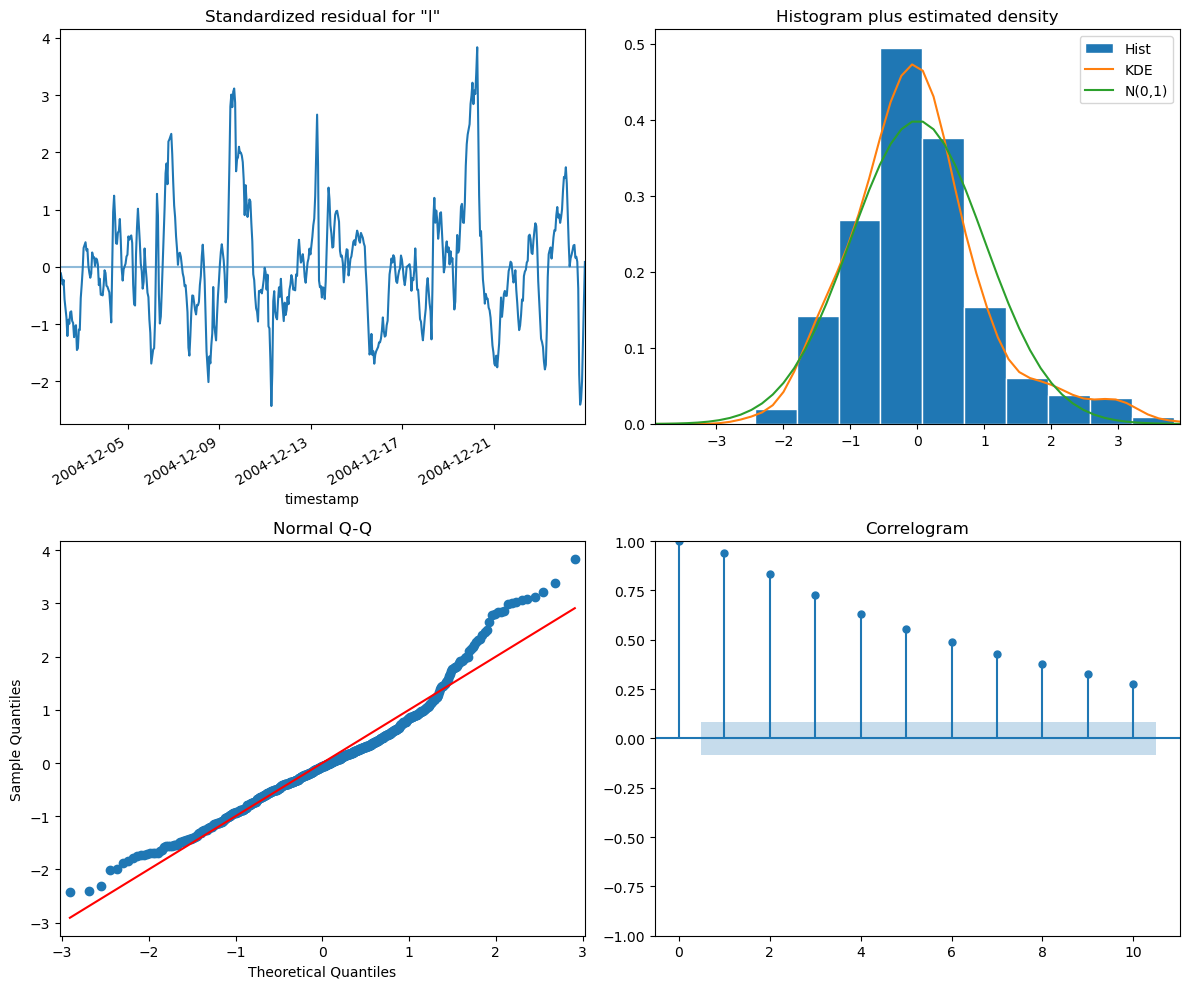

In [165]:
# Diagnostics (for (0,0,0,0))

import statsmodels.api as sm
SARIMA_model = sm.tsa.statespace.SARIMAX(
        endog = load_long_z1_2004_dec_train["log_load_rs"].asfreq('h'), 
        exog = load_long_z1_2004_dec_train[["HDK", "CDK", "holiday","const", "trend"]].asfreq('h'), 
        order=(0,0,0),  # non-seasonal: with no differencing
        seasonal_order=(0,1,0,24) # seasonal: with no seasonal differencing
)

SARIMA_model_fit = SARIMA_model.fit(disp=False, maxiter=500)
SARIMA_model_fit.plot_diagnostics(figsize=(12,10))
plt.tight_layout()
plt.show()

Again, there is uncaptured correlation. Both harmonics and AR/MA components are absent.

In [166]:
# are residuals stationary?
fitted_z1_2004_dec_train = SARIMA_model_fit.predict(start=load_long_z1_2004_dec_train["log_load_rs"].index[0], end=load_long_z1_2004_dec_train["log_load_rs"].index[-1])

check_stationarity(load_long_z1_2004_dec_train["log_load_rs"] - fitted_z1_2004_dec_train)

ADF Statistic: -4.531318424763021
p-value: 0.00017254509085325363
Stationary


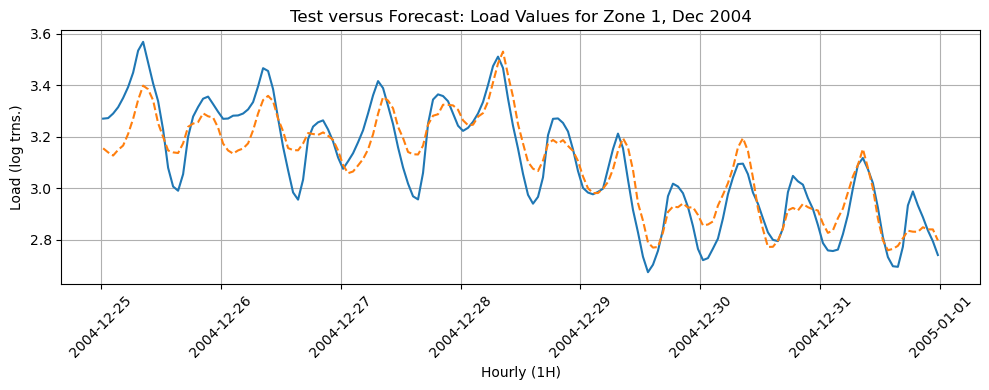

In [138]:
# Predicting 24*7 steps ahead
forecast_dec04 = SARIMA_model_fit.get_forecast(
    steps=24*7, 
    exog = load_long_z1_2004_dec_test[["HDK", "CDK", "holiday","const", "trend"]].asfreq('h')
).predicted_mean

# Fit on the test data
import seaborn as sns
fig, ax = plt.subplots(figsize=(10, 4))
sns.lineplot(data=load_long_z1_2004_dec_test, x=load_long_z1_2004_dec_test.index, y=load_long_z1_2004_dec_test["log_load_rs"].asfreq('h'), ax=ax)
sns.lineplot(forecast_dec04, linestyle = '--')
ax.set_title("Test versus Forecast: Load Values for Zone 1, Dec 2004")
ax.set_xlabel("Hourly (1H)")
ax.set_ylabel("Load (log trns.)")
ax.grid(True)
ax.tick_params(axis="x", rotation=45)

plt.tight_layout()
plt.show()

In [139]:
# Performance on test set

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
print(f"R2 score: {r2_score(load_long_z1_2004_dec_test.log_load_rs, forecast_dec04)}")
print(f'MSE score: {mean_squared_error(load_long_z1_2004_dec_test.log_load_rs, forecast_dec04)}')
print(f'MAE score: {mean_absolute_error(load_long_z1_2004_dec_test.log_load_rs, forecast_dec04)}')
print(f'MAPE score: {mean_absolute_percentage_error(load_long_z1_2004_dec_test.log_load_rs, forecast_dec04)}')

R2 score: 0.826578889760365
MSE score: 0.008137543023201197
MAE score: 0.07562212418685037
MAPE score: 0.024415692569678085


Performance is strong here.